## Nhóm: Kjæreste
## Thành viên
- Bùi Lê Khôi - 22127205
- Nguyễn Thanh Nam - 22127286

### Bối cảnh bài toán 
Trong thực tế, chúng ta thường gặp dữ liệu có **số chiều rất cao** (high-dimensional data):
- **Hình ảnh**: 1 ảnh 256×256 pixels = 65,536 chiều
- **Văn bản**: Mỗi tài liệu có thể được biểu diễn bằng hàng nghìn từ
- **Dữ liệu sinh học**: Gene expression data có thể có hàng chục nghìn chiều
- **Dữ liệu mạng xã hội**: Đồ thị với hàng triệu node

**Vấn đề**: Dữ liệu chiều cao rất khó:
- **Trực quan hóa** (visualize)
- **Phân tích** (analyze)
- **Tính toán** (compute - curse of dimensionality)

**Giải pháp**: **Dimensionality Reduction** (Giảm chiều)
- Chuyển từ không gian chiều cao → không gian chiều thấp (thường 2D hoặc 3D)
- **Bảo toàn cấu trúc** quan trọng của dữ liệu

### Ứng dụng thực tế

#### 1. **Phân tích dữ liệu sinh học**
- **Ví dụ cụ thể**: Phân loại các loại tế bào ung thư từ dữ liệu gene expression
- Có 20,000+ genes (chiều) nhưng chỉ cần 2-3 chiều để phân biệt các loại ung thư khác nhau
- Giúp bác sĩ **chẩn đoán** và chọn **phương pháp điều trị** phù hợp

#### 2. **Nhận dạng khuôn mặt**
- **Ví dụ cụ thể**: Face recognition trong hệ thống bảo mật
- Mỗi ảnh khuôn mặt 100×100 = 10,000 chiều
- Giảm xuống 50-100 chiều để lưu trữ và so sánh nhanh hơn
- Ứng dụng: FaceID trên iPhone, camera an ninh

#### 3. **Phân tích mạng xã hội**
- **Ví dụ cụ thể**: Phát hiện cộng đồng (community detection) trên Facebook/Twitter
- Mỗi người dùng là 1 node trong đồ thị với hàng triệu kết nối
- Giảm chiều để trực quan hóa các nhóm người dùng có mối quan hệ gần nhau
- Ứng dụng: Gợi ý kết bạn, quảng cáo targeted

#### 4. **Xử lý ngôn ngữ tự nhiên**
- **Ví dụ cụ thể**: Word embeddings (Word2Vec, GloVe)
- Từ vocabulary 100,000 từ → vector 300 chiều
- Các từ có nghĩa gần nhau sẽ ở gần nhau trong không gian embedding
- Ứng dụng: Chatbot, máy dịch, tìm kiếm ngữ nghĩa

---

# Manifold Learning


## 0. Import các thư viện cần thiết

In [57]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import SpectralEmbedding, MDS, trustworthiness
from sklearn.datasets import make_swiss_roll, make_s_curve, load_digits, make_blobs, fetch_openml
from sklearn.metrics import pairwise_distances, euclidean_distances, silhouette_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from scipy.stats import spearmanr
from scipy.spatial.distance import cdist
from sklearn.datasets import fetch_openml
from sklearn.utils import resample
import time
import warnings

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# Set global plotting style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")

In [58]:
# Dataset loading
def load_fashion_mnist(n_samples=5000):
    """
    Fashion MNIST: 28x28 grayscale images (784 features)
    10 classes: T-shirt, Trouser, Pullover, Dress, Coat, Sandal, Shirt, Sneaker, Bag, Ankle boot
    """
    print("Loading Fashion MNIST...")
    fashion = fetch_openml('Fashion-MNIST', version=1, parser='auto')
    X = fashion.data[:n_samples]
    y = fashion.target[:n_samples].astype(int)
    
    X = StandardScaler().fit_transform(X)
    
    return X, y, "Fashion MNIST"


def load_olivetti_faces(n_samples=400):
    """
    Olivetti Faces: 64x64 grayscale face images (4096 features)
    40 subjects, 10 images each
    """
    print("Loading Olivetti Faces...")
    from sklearn.datasets import fetch_olivetti_faces
    
    data = fetch_olivetti_faces()
    X = data.data[:n_samples]
    y = data.target[:n_samples]
    
    X = StandardScaler().fit_transform(X)
    
    return X, y, "Olivetti Faces"


def load_20newsgroups_tfidf():
    """
    20 Newsgroups Dataset with TF-IDF features
    Text classification dataset: ~18,000 newsgroup documents
    20 categories, TF-IDF features (high dimensional)
    """
    print("Loading 20 Newsgroups Dataset...")
    from sklearn.datasets import fetch_20newsgroups
    from sklearn.feature_extraction.text import TfidfVectorizer
    
    # Load subset for computational efficiency
    categories = ['alt.atheism', 'talk.religion.misc', 'comp.graphics', 
                  'sci.space', 'rec.sport.baseball']
    
    newsgroups = fetch_20newsgroups(subset='train', categories=categories, 
                                     remove=('headers', 'footers', 'quotes'))
    
    # Convert text to TF-IDF features
    vectorizer = TfidfVectorizer(max_features=500, max_df=0.95, min_df=2)
    X = vectorizer.fit_transform(newsgroups.data).toarray()
    y = newsgroups.target

    X = X[:10000]
    y = y[:10000]
    
    X = StandardScaler().fit_transform(X)
    
    return X, y, "20 Newsgroups (TF-IDF)"


def load_har_smartphone():
    """
    Human Activity Recognition Using Smartphones Dataset
    561 features from accelerometer and gyroscope 3-axial signals
    6 activities: Walking, Walking Upstairs, Walking Downstairs, Sitting, Standing, Laying
    ~10,000 samples
    """
    print("Loading HAR Smartphone Dataset...")
    try:
        # Try to load from OpenML
        har = fetch_openml('har', version=1, parser='auto')
        X = har.data
        y = LabelEncoder().fit_transform(har.target)

        X, y = resample(X, y, n_samples=10000, random_state=42, stratify=y)
        
        X = StandardScaler().fit_transform(X)
        return X, y, "HAR Smartphone"
    except:
        print("HAR dataset unavailable, skipping...")
        return None, None, None
    

def load_covertype():
    """
    Forest Cover Type Dataset: 54 features
    7 forest cover types from 30x30m cells
    ~581,000 samples (cartographic variables)
    Source: UCI ML Repository
    """
    print("Loading Covertype Dataset...")
    try:
        cover = fetch_openml('covertype', version=3, parser='auto')
        X = cover.data
        y = cover.target.astype(int)
        
        # Subsample for computational efficiency
        X, y = resample(X, y, n_samples=10000, random_state=42, stratify=y)
        
        X = StandardScaler().fit_transform(X)
        return X, y, "Forest Covertype"
    except:
        print("Covertype dataset unavailable, skipping...")
        return None, None, None
    

def load_spam_dataset():
    """
    Spambase Dataset: 57 features
    Email spam classification
    ~4600 samples
    Source: UCI ML Repository
    """
    print("Loading Spambase Dataset...")
    try:
        url = "https://archive.ics.uci.edu/ml/machine-learning-databases/spambase/spambase.data"
        df = pd.read_csv(url, header=None)
        X = df.iloc[:, :-1].values
        y = df.iloc[:, -1].values

        X = StandardScaler().fit_transform(X)
        return X, y, "Spambase"
    except:
        print("Spambase dataset unavailable, skipping...")
        return None, None, None

## 1. Giới thiệu phương pháp

Chúng ta định nghĩa lại bài toán trên và một số thông tin liên quan trước khi tiến vào giải quyết vấn đề.

**Input**: Cho tập dữ liệu đầu vào $X$ gồm $N$ điểm dữ liệu trong không gian $D$ chiều:
$$X = \{x_1, x_2, ..., x_N\} \in \mathbb{R}^D$$

**Target**: Tìm một biểu diễn tương ứng $Y$ trong không gian $d$ chiều (với $d \ll D$ (d rất nhỏ so với D), thường là $d=2$ hoặc $d=3$ để dễ trực quan hóa, phân tích và làm các tính toán khác):
$$Y = \{y_1, y_2, ..., y_N\} \in \mathbb{R}^d$$

Hiểu đơn giản thì chúng ta cần tìm ánh xạ $f: \mathbb{R}^D \rightarrow \mathbb{R}^d$ để tạo ra biểu diễn $Y$, sao cho các đặc trưng hình học quan trọng của $X$ được bảo toàn trong $Y$.

Trong Seminar này, chúng ta sử dụng kỹ thuật **Manifold Learning** (Học đa tạp) để giảm chiều dữ liệu, với 2 thuật toán là **MDS - Multidimensional Scaling** và **Spectral Embedding**.

Manifold Learning (Học đa tạp) là một kỹ thuật quan trọng để giảm chiều dữ liệu phi tuyến tính. Notebook này sẽ thực hiện một nghiên cứu so sánh chi tiết giữa hai thuật toán đại diện cho hai thuật toán khác nhau trên bộ dữ liệu như "Swiss Roll":
- MDS (Multidimensional Scaling): Tập trung bảo toàn khoảng cách toàn cục (Global Distance).
- Spectral Embedding: Tập trung bảo toàn tính chất địa phương/lân cận (Local Connectivity) dựa trên lý thuyết đồ thị.

Sự khác biệt giữa 2 thuật toán trên nằm ở hàm mục tiêu (Objective Function) mà mỗi thuật toán cố gắng tối ưu:
- Đối với MDS, thuật toán hướng đến việc xấp xỉ khoảng cách Euclide trong không gian gốc:
$$\|y_i - y_j\| \approx \|x_i - x_j\| \forall i, j$$
- Với Spectral Embedding, nó cố gắng bảo toàn cấu trúc lân cận: Nếu $x_i, x_j$ gần nhau (hoặc có cạnh nối trong đồ thị k-NN), thì khoảng cách $\|y_i - y_j\|$ phải nhỏ nhất có thể.

## 2. Thuật toán MDS - Multidimensional Scaling (MDS)

MDS là một thuật toán giảm chiều dữ liệu được sử dụng để chiếu dữ liệu đa chiều xuống không gian có chiều thấp hơn, đồng thời bảo toàn tối đa khoảng cách giữa các điểm dữ liệu, nhờ đó bảo toàn mối quan hệ giữa các điểm dữ liệu mà vẫn có thể làm nổi bật các mô hình và xu hướng (trends) vốn có thể không rõ ràng trong không gian ban đầu.

MDS có thể được áp dụng cho nhiều loại dữ liệu khác nhau, từ số, phân loại, hay hỗn hợp. Nhờ đó mà nó trở thành 1 công cụ linh hoạt để sử dụng trong nhiều trường hợp khác nhau, thậm chí là với các tập dữ liệu đa phương thức phức tạp (complex multi-modal datasets).

### 2.1. Cơ chế toán học

Giả sử ta có ma trận khoảng cách đầu vào $D$ (Dissimilarity matrix) với $d_{ij}$ là khoảng cách giữa $x_i$ và $x_j$. Ta cần tìm các toạ độ $y_1, ..., y_N \in \mathbb{R}^d$ để tối thiểu hóa hàm mất mát, thường được gọi là **Stress function**:

$$\text{Stress} = \sqrt{\sum_{i,j} (d_{ij} - \hat{d}_{ij})^2}$$

Trong đó:
- $d_{ij} = \|x_i - x_j\|$: Là khoảng cách Euclide giữa hai điểm $i$ và $j$ trong không gian gốc (High-dimensional space).
- $\hat{d}_{ij} = \|y_i - y_j\|$: Là khoảng cách Euclide giữa hai điểm tương ứng trong không gian mới (Low-dimensional embedding).
- Mục tiêu: Tìm cấu hình $Y$ sao cho tổng sai số bình phương giữa $d$ và $\hat{d}$ là nhỏ nhất.

> *Trong một số tài liệu như trên [geeksforgeeks](https://www.geeksforgeeks.org/machine-learning/multidimensional-scaling-mds-using-scikit-learn), người ta thêm hệ số $\frac{1}{2n^2}$ để thuận tiện cho việc tính đạo hàm và loại bỏ sai số, nhưng về mặt hình học, công thức trên là định nghĩa chuẩn.*

### 2.2. Thuật toán Classical MDS 

Classical MDS (đôi khi còn gọi là **PCoA** - Principal Coordinate Analysis) là phiên bản phổ biến nhất, giải quyết bài toán bằng Đại số tuyến tính. Các bước của thuật toán:
- Bước 1. Dựng ma trận bình phương khoảng cách: $D^{(2)} = [d_{ij}^2]$.
- Bước 2. Double Centering: $B = -\frac{1}{2} J D^{(2)} J$, với $J = I - \frac{1}{n}\mathbf{1}\mathbf{1}^T$.
- Bước 3. Phân rã trị riêng (Eigen-decomposition): Tìm các trị riêng và vector riêng của $B$.
- Bước 4. Tính toạ độ mới: $Y = E_d \Lambda_d^{1/2}$ (Lấy $d$ trị riêng lớn nhất).

Trong thư viện `sklearn`, thuật toán MDS có hai chế độ hoạt động chính là Metric MDS và Non-Metric MDS:

- Metric MDS: Cố gắng giữ nguyên giá trị khoảng cách (số mét, cm...).
- Non-metric MDS: Chỉ cố gắng giữ nguyên thứ tự khoảng cách (A gần B hơn C).

Tại sao chúng ta cần tham số `metric`?
- `metric=True` (MDS cổ điển): Cố gắng sao chép chính xác khoảng cách. Nó cứng nhắc.
    - Phù hợp: Dữ liệu địa lý (bản đồ thành phố).
- `metric=False` (Non-metric MDS): Chỉ quan tâm đến **thứ tự** (Rank order). Nó cho phép "co giãn" khoảng cách.
    - Phù hợp: Dữ liệu tâm lý học, khảo sát (nơi con số 1-5 chỉ là mức độ, không phải khoảng cách mét).
    - Code: Trong sklearn, `metric=False` kích hoạt thuật toán SMACOF để tối ưu hóa Stress đơn điệu (Monotonic Stress).

> Tham khảo các loại thuật toán trên [MATH3030 - Chapter 6 Multidimensional Scaling (MDS)](https://rich-d-wilkinson.github.io/MATH3030/6-mds.html)

## 3. Thuật toán Spectral Embedding

Khác với MDS, Spectral Embedding bỏ qua khoảng cách xa và chỉ tập trung vào việc những điểm gần nhau phải ở cạnh nhau. 

Spectral Embedding trên lý thuyết phổ đồ thị (Spectral Graph Theory).

### 3.1. Cơ sở toán học

Quá trình ánh xạ được thực hiện qua 3 bước toán học chính:

- Bước 1: Xây dựng đồ thị lân cận. Ta coi mỗi điểm dữ liệu $x_i$ là một đỉnh (node) của đồ thị $G=(V, E)$. Ma trận kề có trọng số $W$ (Adjacency Matrix) được xây dựng để biểu diễn độ tương đồng:
  - Nếu $x_i$ và $x_j$ "gần" nhau: $W_{ij} > 0$.
  - Nếu xa nhau: $W_{ij} = 0$.

- Bước 2: Xây dựng Ma trận Laplacian ($L$). Từ ma trận $W$ ở bước 1, ta tính toán hai ma trận quan trọng:
  - **Ma trận bậc (Degree Matrix) $D$:** Là ma trận đường chéo, với $D_{ii} = \sum_{j} W_{ij}$ (tổng trọng số các cạnh nối với điểm $i$).
  - **Ma trận Laplacian $L$:** $$L = D - W$$

- Bước 3: Tối ưu: Tìm các toạ độ mới $Y = (y_1, ..., y_N)$ để tối thiểu hóa hàm mất mát (Loss function):
$$\min_Y \sum_{i,j} W_{ij} \|y_i - y_j\|^2$$ Việc này tương đương với việc giải phương trình trị riêng $$Lf = \lambda Df$$
Các vector riêng (eigenvectors) ứng với trị riêng nhỏ nhất sẽ là tọa độ mới.

Nhận xét:

- Nếu $W_{ij}$ lớn (hai điểm rất giống nhau), để tổng này nhỏ, thì khoảng cách $\|y_i - y_j\|$ bắt buộc phải nhỏ $\rightarrow$ **Bảo toàn tính địa phương (Locality Preserving).**
- Nếu $W_{ij} = 0$, khoảng cách giữa $y_i, y_j$ có thể lớn tùy ý mà không ảnh hưởng hàm mục tiêu $\rightarrow$ **Bỏ qua cấu trúc toàn cục.**

Spectral Embedding cực kỳ mạnh mẽ để "duỗi" các cấu trúc bị cuộn (unfolding manifolds) mà MDS thường thất bại.

### 3.2. Xây dựng đồ thị (Graph Construction)

Bước quan trọng nhất quyết định thành bại của Spectral Embedding là cách xây dựng ma trận kề $W$ (Affinity Matrix).

Tham số `affinity` quyết định cách đồ thị được xây dựng:
- `affinity='rbf'` (Radial Basis Function):
    - Sử dụng công thức Gaussian: $W_{ij} = e^{-\gamma ||x_i - x_j||^2}$.
    - Tạo ra đồ thị dày đặc (kết nối mềm).
    - Nhược điểm: Với dữ liệu cuộn (Swiss Roll), nó dễ bị "xuyên tường" (nối nhầm 2 lớp giấy gần nhau trong không gian 3D nhưng xa nhau trên bề mặt).
- `affinity='nearest_neighbors'`:
    - Chỉ nối $k$ điểm gần nhất (ví dụ $k=10$).
    - Ưu điểm: Nó cắt bỏ các liên kết xa. Đây là cấu hình **bắt buộc** để "trải phẳng" (unfold) các đa tạp phi tuyến tính như Swiss Roll.

## 4. So sánh lý thuyết (Theoretical Comparison)

Chúng ta có bảng tổng hợp so sánh sự khác biệt cốt lõi giữa hai phương pháp:

| Tiêu chí | MDS | Spectral Embedding |
| :--- | :--- | :--- |
| **Bản chất** | **Global Preservation (Toàn cục):** Cố gắng giữ nguyên khoảng cách giữa tất cả các cặp điểm, bất kể xa hay gần. | **Local Preservation (Địa phương):** Chỉ quan tâm đến việc giữ các điểm "hàng xóm" ở gần nhau, khoảng cách xa không quan trọng. |
| **Input** | Ma trận khoảng cách $D$ chứa các giá trị $d_{ij}$. | Ma trận kề có trọng số $W$ được xây dựng từ đồ thị (k-NN hoặc RBF). |
| **Công cụ toán học** | Tối ưu hóa hàm **Stress**. | Tối ưu hóa hàm mục tiêu **Laplacian**. |
| **Khả năng "Duỗi" (Unfolding)** | **Thấp.** Không thể phân biệt được hai lớp dữ liệu cuộn tròn nếu chúng ở gần nhau trong không gian Euclide (bị "short-circuit"). | **Cao.** Có thể "đi" dọc theo bề mặt đa tạp để trải phẳng nó (miễn là đồ thị liên thông). |
| **Độ phức tạp** | $O(N^2) \rightarrow O(N^3)$ (Classical MDS), rất tốn kém bộ nhớ và thời gian nếu $N > 5000$. | $O(N^2) \rightarrow O(N^3)$, tuy nhiên nếu dùng đồ thị thưa (k-NN), các thuật toán giải trị riêng (như Arpack) có thể chạy nhanh hơn. |
| **Điểm mạnh** | Tốt cho dữ liệu phân bổ đều, cấu trúc phẳng. | Tốt cho dữ liệu phi tuyến (manifold), cụm xoắn ốc. |
| **Điểm yếu** | Nhạy cảm với **outliers**. 1 outlier ở xa có thể làm lệch toàn bộ cấu trúc. | Nhạy cảm với **tham số $k$**. Nếu $k$ quá nhỏ, đồ thị bị gãy khúc; nếu $k$ quá lớn, đồ thị mất tính địa phương (Local), trở thành PCA/MDS. |

## 5. Tiêu chí đánh giá (Evaluation Metrics)

Để so sánh công bằng, chúng ta sẽ sử dụng 2 chỉ số chính:

### 5.1. Trustworthiness (Độ tin cậy)

Chỉ số này trả lời câu hỏi: "Những điểm đứng cạnh nhau trong không gian mới (2D) có thực sự là hàng xóm của nhau trong không gian gốc hay không?".

- Phạm vi: $0 \to 1$.

- Ý nghĩa: Càng gần 1 càng tốt.

### 5.2. Stress (Độ căng/méo)

Đo lường sự sai lệch về khoảng cách. Tuy nhiên, để đảm bảo công bằng, ta sẽ dùng công thức chuẩn hóa của Stress (Công thức Kruskal's Stress-1):

$$Stress = \sqrt{\frac{\sum_{i,j} (d_{ij} - \hat{d}_{ij})^2}{\sum_{i,j} d_{ij}^2}}$$

Trong đó:
- $d_{ij}$: Khoảng cách trong không gian gốc.
- $\hat{d}_{ij}$: Khoảng cách trong không gian nhúng (embedding).
- Ý nghĩa: Càng thấp càng tốt.

Chúng ta sử dụng `n_neighbors=12` cho hàm `trustworthiness`. 
- Lý do: Đây là con số cân bằng. Nếu chọn $k$ quá nhỏ ($k=1$), chỉ số sẽ bị ảnh hưởng bởi nhiễu. Nếu chọn $k$ quá lớn, nó không còn phản ánh tính chất "địa phương" nữa.
- Stress đã được chuẩn hóa (Normalized) để chúng ta có thể so sánh giữa các bộ dữ liệu có quy mô (scale) khác nhau.

In [59]:
def compute_continuity(X_original, X_embedded, k_neighbors=12):
    """
    Continuity: Đo lường xem các điểm là neighbors trong không gian gốc
    có còn là neighbors trong không gian embedding không.
    
    Higher is better (max = 1.0)
    """
    n_samples = X_original.shape[0]
    
    # Tính k-nearest neighbors trong không gian gốc
    dist_original = pairwise_distances(X_original)
    nn_original = np.argsort(dist_original, axis=1)[:, 1:k_neighbors+1]
    
    # Tính k-nearest neighbors trong không gian embedding
    dist_embedded = pairwise_distances(X_embedded)
    nn_embedded = np.argsort(dist_embedded, axis=1)[:, 1:k_neighbors+1]
    
    # Tính continuity
    continuity_sum = 0
    for i in range(n_samples):
        # Các điểm là neighbors trong gốc nhưng KHÔNG phải trong embedding
        false_negatives = set(nn_original[i]) - set(nn_embedded[i])
        
        for j in false_negatives:
            # Rank của j trong embedding (càng xa càng tệ)
            rank_embedded = np.where(np.argsort(dist_embedded[i]) == j)[0][0]
            continuity_sum += (rank_embedded - k_neighbors)
    
    # Normalize
    max_sum = n_samples * k_neighbors * (2 * n_samples - 3 * k_neighbors - 1) / 2
    continuity = 1 - (2 * continuity_sum / max_sum)
    
    return continuity


def compute_quality_metrics(X_original, X_embedded, y_labels=None, k_neighbors=12):
    """
    Compute quality metrics for the embedding.
    
    Args:
        X_original: Data in high-dimensional space
        X_embedded: Data in low-dimensional space
        
    Returns:
        Dictionary containing metric scores
    """
    metrics = {}
    # Trustworthiness (higher is better, max=1.0)
    # Checks if k-nearest neighbors are preserved
    # Measures: Did we introduce fake neighbors?
    metrics['trustworthiness'] = trustworthiness(X_original, X_embedded, n_neighbors=k_neighbors)

    # Continuity (higher is better, max=1.0)
    # Measures: Did we lose neighbors?
    metrics['continuity'] = compute_continuity(X_original, X_embedded, k_neighbors)
    
    # Stress calculation (lower is better)
    # Compare pairwise distances in original vs embedded space
    # Measures: How much did we distort the distances?
    D_original = pairwise_distances(X_original)
    D_embedded = pairwise_distances(X_embedded)
    
    # Normalize by original distances to get a scale-invariant score
    metrics['stress'] = np.sqrt(np.sum((D_original - D_embedded)**2) / np.sum(D_original**2))

    # Correlation between distance matrices
    D_orig_flat = D_original[np.triu_indices_from(D_original, k=1)]
    D_emb_flat = D_embedded[np.triu_indices_from(D_embedded, k=1)]
    metrics['distance_correlation'] = np.corrcoef(D_orig_flat, D_emb_flat)[0, 1]

    # Spearman Rank Correlation (Non-metric MDS)
    metrics['spearman_correlation'] = spearmanr(D_orig_flat, D_emb_flat)[0]

    # Silhouette Score (if labels are provided)
    if y_labels is not None:
        try:
            metrics['silhouette'] = silhouette_score(X_embedded, y_labels)
        except:
            metrics['silhouette'] = None

    return metrics

## 6. Implementation

Dựa trên thư viện `sklearn`, ta xây dựng các hàm wrapper để thực thi và đo lường hiệu năng của MDS và Spectral Embedding.

Hàm MDS:

In [60]:
def run_mds(X, metric=True, n_components=2):
    """
    Run MDS algorithm and measure performance.
    
    Args:
        X: Input data
        metric: If True use Metric MDS, else Non-metric MDS
        n_components: Target dimensions
    """
    start_time = time.time()
    
    # Initialize MDS
    # max_iter=300 is standard for convergence
    mds = MDS(n_components=n_components, 
              metric=metric, 
              max_iter=300, 
              n_init=4, 
              random_state=42, 
              dissimilarity='euclidean')
    
    # Fit and transform
    X_embedded = mds.fit_transform(X)
    embedding_time = time.time() - start_time
    
    # Compute metrics
    metrics = compute_quality_metrics(X, X_embedded)
    metrics['time'] = embedding_time
    metrics['method'] = 'MDS (Metric)' if metric else 'MDS (Non-metric)'
    
    return X_embedded, metrics

Hàm Spectral:

In [61]:
def run_spectral(X, affinity='nearest_neighbors', n_components=2, **kwargs):
    """
    Run Spectral Embedding algorithm.
    
    Args:
        X: Input data
        affinity: 'nearest_neighbors' or 'rbf'
        kwargs: Extra parameters like n_neighbors or gamma
    """
    start_time = time.time()
    
    # Initialize Spectral Embedding
    se = SpectralEmbedding(n_components=n_components, 
                           affinity=affinity,
                           random_state=42,
                           **kwargs)
    
    # Fit and transform
    X_embedded = se.fit_transform(X)
    embedding_time = time.time() - start_time
    
    # Compute metrics
    metrics = compute_quality_metrics(X, X_embedded)
    metrics['time'] = embedding_time
    metrics['method'] = f'Spectral ({affinity})'
    
    return X_embedded, metrics

## 7. Chuẩn bị Dữ liệu & Hàm so sánh

In [62]:
import matplotlib.patches as mpatches

def get_class_names(dataset_name):
    """Mapping tên lớp cho các dataset cụ thể"""
    if "Fashion MNIST" in dataset_name:
        return ['T-shirt', 'Trouser', 'Pullover', 'Dress', 'Coat', 
                'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Boot']
    elif "HAR" in dataset_name:
        return ['Walk', 'Walk_Up', 'Walk_Down', 'Sit', 'Stand', 'Lay']
    return None


def compare_and_visualize(X, y, dataset_name):
    """
    Run both algorithms on the dataset and plot results side-by-side.
    """
    print(f"Processing: {dataset_name} (Shape: {X.shape})...")
    
    # 1. Run Spectral Embedding (using nearest_neighbors is best for unfolding)
    X_se, m_se = run_spectral(X, affinity='nearest_neighbors', n_neighbors=15)
    
    # 2. Run Metric MDS
    X_mds, m_mds = run_mds(X, metric=True)
    
    # 3. Visualization
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    # Plot Original (First 2 dim or 3D projection logic if needed, here simplified)
    # Note: For true 3D viz we need Axes3D, but for simple comparison 
    # we often plot the embedding result directly.
    # Let's plot the embeddings.
    
    # Helper to plot
    def plot_emb(ax, data, labels, title, metrics):
        scatter = ax.scatter(data[:, 0], data[:, 1], c=labels, cmap='Spectral', s=15, alpha=0.7)
        subtitle = f"Trust: {metrics['trustworthiness']:.3f}, Stress: {metrics['stress']:.3f}"
        ax.set_title(f"{title}\n{subtitle}")
        ax.grid(True, alpha=0.3)

    # We will plot a 3D view for the original data if it is 3D
    if X.shape[1] == 3:
        ax1 = fig.add_subplot(131, projection='3d')
        ax1.scatter(X[:, 0], X[:, 1], X[:, 2], c=y, cmap='Spectral', s=15)
        ax1.set_title(f"Original 3D Data\n{dataset_name}")
        ax1.view_init(10, -70) # Good angle for Swiss Roll
    else:
        # For high dim data like digits, we skip 3D plot or use PCA for preview
        axes[0].text(0.5, 0.5, "High-Dim Data\nNo 3D View", ha='center')
    
    # Plot MDS
    plot_emb(axes[1], X_mds, y, "Metric MDS", m_mds)
    
    # Plot Spectral
    plot_emb(axes[2], X_se, y, "Spectral Embedding", m_se)
    
    plt.tight_layout()
    plt.show()
    
    res_mds = {
        'Dataset': dataset_name,
        'Method': 'MDS (Metric)',
        'Trustworthiness': m_mds['trustworthiness'],
        'Norm Stress': m_mds['stress'],
        'Time (s)': m_mds['time']
    }
    
    res_spec = {
        'Dataset': dataset_name,
        'Method': 'Spectral',
        'Trustworthiness': m_se['trustworthiness'],
        'Norm Stress': m_se['stress'],
        'Time (s)': m_se['time']
    }
    
    # Print textual summary
    print(f"--- Summary for {dataset_name} ---")
    print(f"MDS      -> Trust: {m_mds['trustworthiness']:.4f}, Time: {m_mds['time']:.4f}s")
    print(f"Spectral -> Trust: {m_se['trustworthiness']:.4f}, Time: {m_se['time']:.4f}s")
    print("-" * 50 + "\n")
    
    return [res_mds, res_spec]


def plot_comparison(X_mds, X_spectral, y, metrics_mds, metrics_spectral, dataset_name):
    """
    Vẽ so sánh kết quả embedding của 2 thuật toán
    """
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # MDS Result
    scatter1 = axes[0].scatter(
        X_mds[:, 0], X_mds[:, 1],
        c=y, cmap='tab10', s=20, alpha=0.6, edgecolors='k', linewidth=0.3
    )
    axes[0].set_title(
        f"MDS (Metric)\n"
        f"Trust: {metrics_mds['trustworthiness']:.4f} | "
        f"Stress: {metrics_mds['stress']:.4f} | "
        f"Time: {metrics_mds['time']:.2f}s",
        fontsize=12, fontweight='bold'
    )
    axes[0].set_xlabel('Dimension 1')
    axes[0].set_ylabel('Dimension 2')
    axes[0].grid(True, alpha=0.3)
    plt.colorbar(scatter1, ax=axes[0], label='Class')
    
    # Spectral Result
    scatter2 = axes[1].scatter(
        X_spectral[:, 0], X_spectral[:, 1],
        c=y, cmap='tab10', s=20, alpha=0.6, edgecolors='k', linewidth=0.3
    )
    axes[1].set_title(
        f"Spectral Embedding\n"
        f"Trust: {metrics_spectral['trustworthiness']:.4f} | "
        f"Stress: {metrics_spectral['stress']:.4f} | "
        f"Time: {metrics_spectral['time']:.2f}s",
        fontsize=12, fontweight='bold'
    )
    axes[1].set_xlabel('Dimension 1')
    axes[1].set_ylabel('Dimension 2')
    axes[1].grid(True, alpha=0.3)
    plt.colorbar(scatter2, ax=axes[1], label='Class')
    
    plt.suptitle(f"Dataset: {dataset_name} | Shape: {X_mds.shape}", 
                 fontsize=14, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.show()


def compare_algorithms(X, y, dataset_name):
    """
    So sánh toàn diện với tất cả metrics mới
    """
    print(f"\n{'='*80}")
    print(f"COMPREHENSIVE EVALUATION")
    print(f"Dataset: {dataset_name}")
    print(f"Shape: {X.shape} | Samples: {len(X)} | Features: {X.shape[1]}")
    print(f"{'='*80}")

    if len(X) > 10000:
        print(f"Subsampling to 10000 samples...")
        X, y = resample(X, y, n_samples=10000, random_state=42, stratify=y)
    
    # Run MDS
    print("Running MDS...")
    start_time = time.time()
    mds = MDS(n_components=2, metric=True, max_iter=300, n_init=4, random_state=42)
    X_mds = mds.fit_transform(X)
    metrics_mds = compute_quality_metrics(X, X_mds, y)
    metrics_mds['time'] = time.time() - start_time
    
    # Run Spectral
    print("Running Spectral Embedding...")
    start_time = time.time()
    se = SpectralEmbedding(n_components=2, affinity='nearest_neighbors', 
                          n_neighbors=15, random_state=42)
    X_spectral = se.fit_transform(X)
    metrics_spectral = compute_quality_metrics(X, X_spectral, y)
    metrics_spectral['time'] = time.time() - start_time
    
    # Visualize with enhanced metrics
    fig = plt.figure(figsize=(20, 12))
    
    # Embeddings
    ax1 = plt.subplot(2, 3, 1)
    scatter1 = ax1.scatter(X_mds[:, 0], X_mds[:, 1], c=y, cmap='tab10', 
                          s=20, alpha=0.6, edgecolors='k', linewidth=0.3)
    ax1.set_title(f"MDS\nTrust: {metrics_mds['trustworthiness']:.3f} | "
                 f"Cont: {metrics_mds['continuity']:.3f}\n"
                 f"Sil: {metrics_mds.get('silhouette', 0):.3f}",
                 fontsize=11, fontweight='bold')
    plt.colorbar(scatter1, ax=ax1)
    
    ax2 = plt.subplot(2, 3, 2)
    scatter2 = ax2.scatter(X_spectral[:, 0], X_spectral[:, 1], c=y, cmap='tab10',
                          s=20, alpha=0.6, edgecolors='k', linewidth=0.3)
    ax2.set_title(f"Spectral\nTrust: {metrics_spectral['trustworthiness']:.3f} | "
                 f"Cont: {metrics_spectral['continuity']:.3f}\n"
                 f"Sil: {metrics_spectral.get('silhouette', 0):.3f}",
                 fontsize=11, fontweight='bold')
    plt.colorbar(scatter2, ax=ax2)
    
    # Metrics comparison bars
    ax3 = plt.subplot(2, 3, 3)
    metrics_names = ['trustworthiness', 'continuity', 'silhouette']
    x_pos = np.arange(len(metrics_names))
    mds_vals = [metrics_mds.get(m, 0) for m in metrics_names]
    spec_vals = [metrics_spectral.get(m, 0) for m in metrics_names]
    
    width = 0.35
    ax3.bar(x_pos - width/2, mds_vals, width, label='MDS', color='#2E86AB')
    ax3.bar(x_pos + width/2, spec_vals, width, label='Spectral', color='#A23B72')
    ax3.set_xticks(x_pos)
    ax3.set_xticklabels(['Trust', 'Cont', 'Sil'], rotation=45)
    ax3.set_ylabel('Score', fontweight='bold')
    ax3.set_title('Quality Metrics Comparison', fontweight='bold')
    ax3.legend()
    ax3.grid(True, alpha=0.3, axis='y')
    
    # Distance preservation
    ax4 = plt.subplot(2, 3, 4)
    D_orig = pairwise_distances(X)
    D_mds = pairwise_distances(X_mds)
    D_orig_flat = D_orig[np.triu_indices_from(D_orig, k=1)]
    D_mds_flat = D_mds[np.triu_indices_from(D_mds, k=1)]
    ax4.scatter(D_orig_flat, D_mds_flat, alpha=0.3, s=5, color='#2E86AB')
    ax4.plot([D_orig_flat.min(), D_orig_flat.max()],
             [D_orig_flat.min(), D_orig_flat.max()], 'r--', lw=2, alpha=0.7)
    ax4.set_xlabel('Original Distance', fontweight='bold')
    ax4.set_ylabel('Embedded Distance', fontweight='bold')
    ax4.set_title(f'MDS Distance Preservation\nPearson: {metrics_mds["distance_correlation"]:.3f} | '
                 f'Spearman: {metrics_mds["spearman_correlation"]:.3f}',
                 fontweight='bold')
    ax4.grid(True, alpha=0.3)
    
    ax5 = plt.subplot(2, 3, 5)
    D_spec = pairwise_distances(X_spectral)
    D_spec_flat = D_spec[np.triu_indices_from(D_spec, k=1)]
    ax5.scatter(D_orig_flat, D_spec_flat, alpha=0.3, s=5, color='#A23B72')
    ax5.plot([D_orig_flat.min(), D_orig_flat.max()],
             [D_orig_flat.min(), D_orig_flat.max()], 'r--', lw=2, alpha=0.7)
    ax5.set_xlabel('Original Distance', fontweight='bold')
    ax5.set_ylabel('Embedded Distance', fontweight='bold')
    ax5.set_title(f'Spectral Distance Preservation\nPearson: {metrics_spectral["distance_correlation"]:.3f} | '
                 f'Spearman: {metrics_spectral["spearman_correlation"]:.3f}',
                 fontweight='bold')
    ax5.grid(True, alpha=0.3)
    
    # Time and stress comparison
    ax6 = plt.subplot(2, 3, 6)
    methods = ['MDS', 'Spectral']
    times = [metrics_mds['time'], metrics_spectral['time']]
    stresses = [metrics_mds['stress'], metrics_spectral['stress']]
    
    x_pos = np.arange(len(methods))
    ax6_twin = ax6.twinx()
    
    bars1 = ax6.bar(x_pos - 0.2, times, 0.4, label='Time (s)', color='#F18F01', alpha=0.7)
    bars2 = ax6_twin.bar(x_pos + 0.2, stresses, 0.4, label='Stress', color='#C73E1D', alpha=0.7)
    
    ax6.set_xticks(x_pos)
    ax6.set_xticklabels(methods)
    ax6.set_ylabel('Time (seconds)', fontweight='bold', color='#F18F01')
    ax6_twin.set_ylabel('Normalized Stress', fontweight='bold', color='#C73E1D')
    ax6.set_title('Time & Stress Comparison', fontweight='bold')
    ax6.tick_params(axis='y', labelcolor='#F18F01')
    ax6_twin.tick_params(axis='y', labelcolor='#C73E1D')
    
    plt.suptitle(f"Comprehensive Evaluation | {dataset_name}", 
                 fontsize=14, fontweight='bold', y=0.995)
    plt.tight_layout()
    plt.show()
    
    # Print summary
    print(f"\n--- SUMMARY ---")
    print(f"MDS:")
    print(f"  Trust: {metrics_mds['trustworthiness']:.4f}, Cont: {metrics_mds['continuity']:.4f}")
    print(f"  Stress: {metrics_mds['stress']:.4f}, Sil: {metrics_mds.get('silhouette', 'N/A')}")
    print(f"  Time: {metrics_mds['time']:.2f}s")
    print(f"\nSpectral:")
    print(f"  Trust: {metrics_spectral['trustworthiness']:.4f}, Cont: {metrics_spectral['continuity']:.4f}")
    print(f"  Stress: {metrics_spectral['stress']:.4f}, Sil: {metrics_spectral.get('silhouette', 'N/A')}")
    print(f"  Time: {metrics_spectral['time']:.2f}s")
    
    return {
        'Dataset': dataset_name,
        'N_samples': len(X),
        'N_features': X.shape[1],
        'MDS_Trust': metrics_mds['trustworthiness'],
        'MDS_Cont': metrics_mds['continuity'],
        'MDS_Stress': metrics_mds['stress'],
        'MDS_Sil': metrics_mds.get('silhouette', None),
        'MDS_Time': metrics_mds['time'],
        'Spectral_Trust': metrics_spectral['trustworthiness'],
        'Spectral_Cont': metrics_spectral['continuity'],
        'Spectral_Stress': metrics_spectral['stress'],
        'Spectral_Sil': metrics_spectral.get('silhouette', None),
        'Spectral_Time': metrics_spectral['time']
    }

## 8. Evaluation

### 8.1. Bài toán 1: Swiss Roll

Đây là bộ dữ liệu chuẩn mực (Benchmark) cho Manifold Learning. Nó là một mặt phẳng 2D bị cuộn tròn trong 3D.
- Dự đoán: MDS sẽ thất bại (ép bẹp cuộn giấy). Spectral sẽ thành công (trải phẳng cuộn giấy).

Generating Swiss Roll data...
Processing: Swiss Roll (Shape: (1000, 3))...


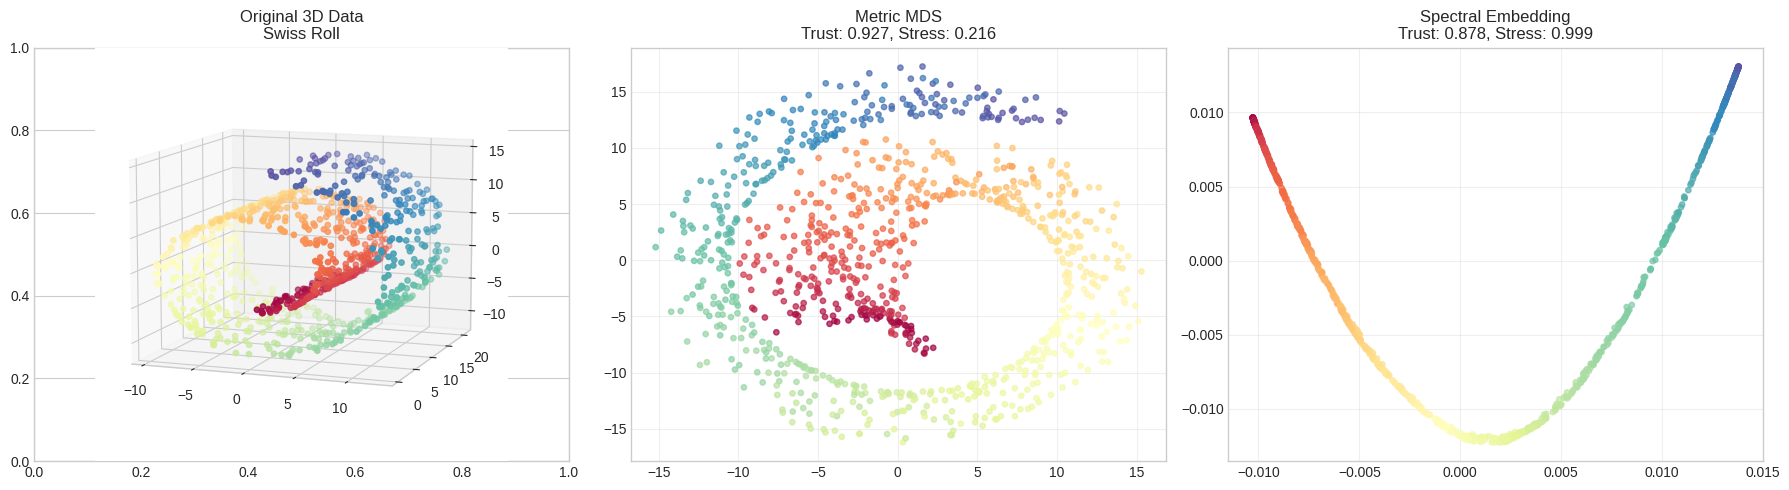

--- Summary for Swiss Roll ---
MDS      -> Trust: 0.9271, Time: 6.6159s
Spectral -> Trust: 0.8782, Time: 0.1454s
--------------------------------------------------



In [63]:
# Danh sách chứa toàn bộ kết quả để lập bảng evaluation
all_results = []

# Generate Swiss Roll data
print("Generating Swiss Roll data...")
X_swiss, y_swiss = make_swiss_roll(n_samples=1000, noise=0.05, random_state=42)

# Run comparison
all_results.extend(compare_and_visualize(X_swiss, y_swiss, "Swiss Roll"))

### 8.2. Bài toán 2: S-Curve

Tương tự như Swiss Roll nhưng hình dạng chữ S. Đây cũng là một đa tạp phi tuyến tính điển hình.

Generating S-Curve data...
Processing: S-Curve (Shape: (1000, 3))...


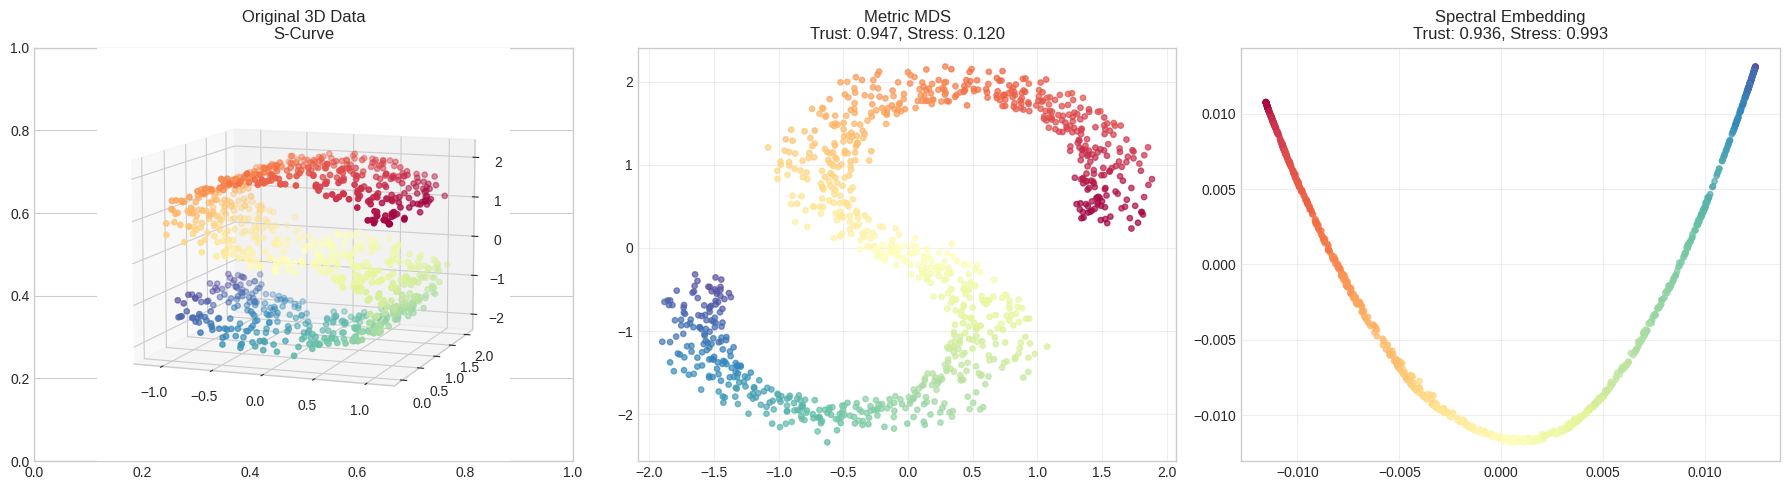

--- Summary for S-Curve ---
MDS      -> Trust: 0.9467, Time: 6.9304s
Spectral -> Trust: 0.9363, Time: 0.0409s
--------------------------------------------------



In [64]:
# Generate S-Curve data
print("Generating S-Curve data...")
X_scurve, y_scurve = make_s_curve(n_samples=1000, noise=0.05, random_state=42)

# Run comparison
all_results.extend(compare_and_visualize(X_scurve, y_scurve, "S-Curve"))

### 8.3. Bài toán 3: Dữ liệu số viết tay (Digits)

Đây là dữ liệu thực tế gồm các ảnh 8x8 pixel (64 chiều). Chúng ta xem các thuật toán phân cụm các số (0-9) như thế nào.

Loading Digits dataset...
Processing: Digits (64D) (Shape: (1797, 64))...


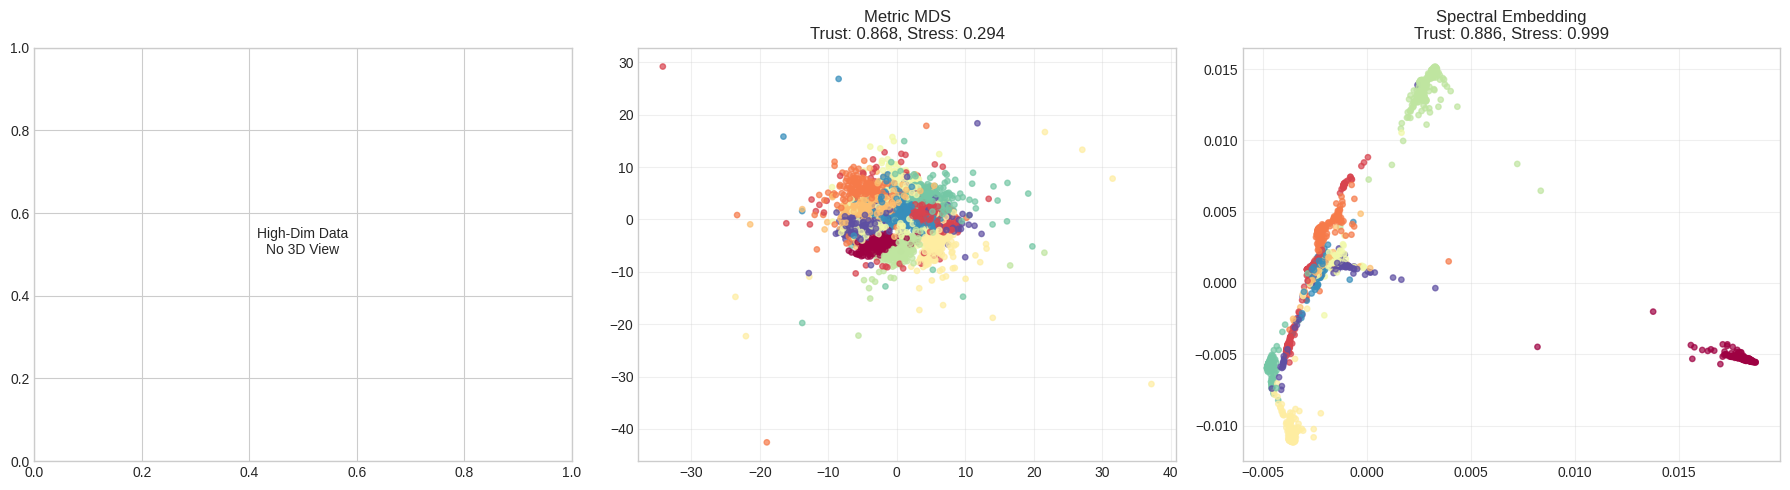

--- Summary for Digits (64D) ---
MDS      -> Trust: 0.8682, Time: 49.9699s
Spectral -> Trust: 0.8858, Time: 0.1764s
--------------------------------------------------



In [65]:
# Load Digits data
print("Loading Digits dataset...")
digits = load_digits()
X_digits = digits.data
y_digits = digits.target

# Standardize features (important for distance calculations)
X_digits = StandardScaler().fit_transform(X_digits)

# Run comparison
all_results.extend(compare_and_visualize(X_digits, y_digits, "Digits (64D)"))

### 8.4. Bài toán 4: Bộ dữ liệu MNIST

Đây là dữ liệu thực tế gồm các ảnh 28x28 pixel (784 chiều). Là phiên bản đầy đủ hơn của Digits. 
Ta dự đoán MDS sẽ chạy rất lâu do phải nhân số lượng rất lớn ma trận. Chúng ta xem các thuật toán phân cụm các số (0-9) như thế nào.

Loading full MNIST dataset from OpenML ...
Dataset shape after sampling: (3000, 784)
Standardizing features...
Running comparison on MNIST...
Processing: MNIST Small (3000 samples) (Shape: (3000, 784))...


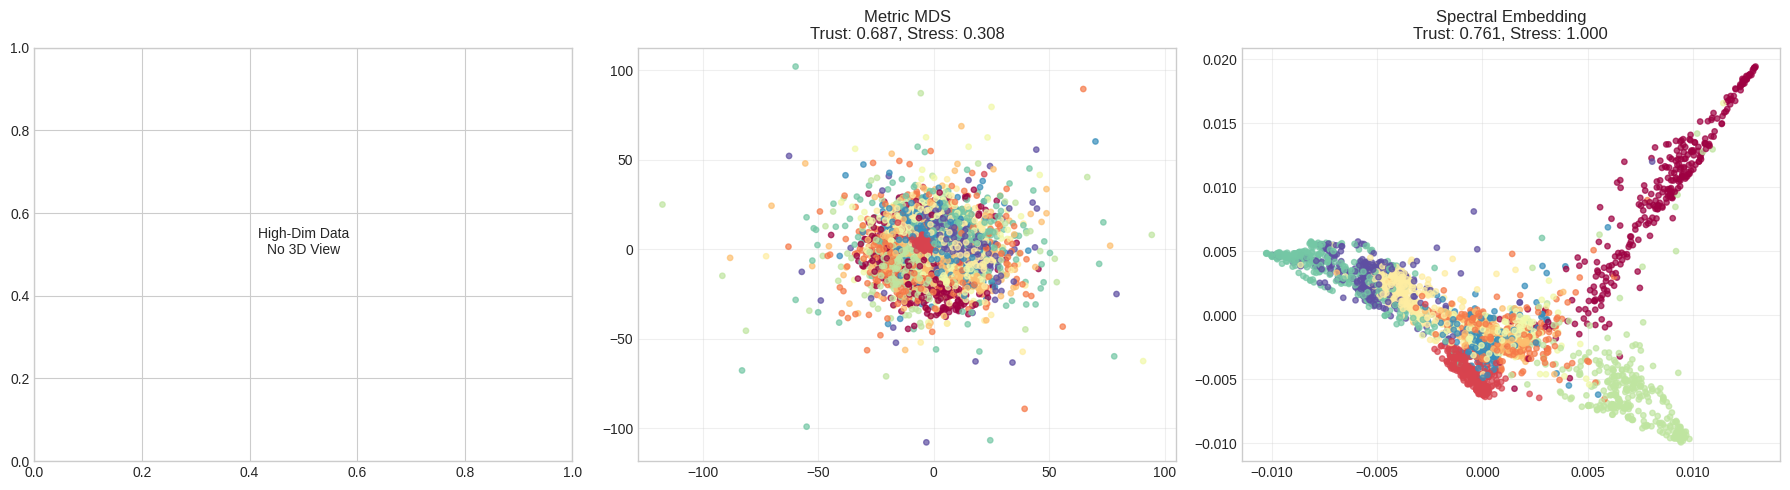

--- Summary for MNIST Small (3000 samples) ---
MDS      -> Trust: 0.6867, Time: 211.9401s
Spectral -> Trust: 0.7612, Time: 0.9254s
--------------------------------------------------



In [66]:
print("Loading full MNIST dataset from OpenML ...")

mnist = fetch_openml('mnist_784', version=1, as_frame=False, parser='auto')
X_full = mnist.data
y_full = mnist.target.astype(int)

# Subsampling
# Taking just 3000 samples to keep MDS manageable
# stratify=y to maintain class balance
n_samples = 3000 
X_mnist, y_mnist = resample(X_full, y_full, n_samples=n_samples, random_state=42, stratify=y_full)

print(f"Dataset shape after sampling: {X_mnist.shape}")

# Standardize features (important for distance calculations)
print("Standardizing features...")
X_mnist = StandardScaler().fit_transform(X_mnist)

# Run comparison
print("Running comparison on MNIST...")
all_results.extend(compare_and_visualize(X_mnist, y_mnist, f"MNIST Small ({n_samples} samples)"))

### 8.5. Bảng tổng hợp kết quả

In [67]:
df_results = pd.DataFrame(all_results)

df = df_results.copy()

print("BẢNG TỔNG HỢP KẾT QUẢ THỰC NGHIỆM (PHÂN THEO DATASET)")

def highlight_by_dataset(data):
    styles = pd.DataFrame('', index=data.index, columns=data.columns)

    dataset_groups = df_results.groupby('Dataset')

    for dataset, idx in dataset_groups.groups.items():
        group = df_results.loc[idx]

        # Trustworthiness và Continuity: max là tốt
        max_trust = group['Trustworthiness'].max()
        mask = group['Trustworthiness'] == max_trust
        styles.loc[mask.index[mask], 'Trustworthiness'] = \
            'color: green; font-weight: bold'

        # Norm Stress & Time: min là tốt
        for col in ['Norm Stress', 'Time (s)']:
            min_val = group[col].min()
            mask = group[col] == min_val
            styles.loc[mask.index[mask], col] = \
                'color: green; font-weight: bold'

    return styles

styled = (
    df.style
      .format({
          'Trustworthiness': '{:.4f}',
          'Continuity': '{:.4f}',
          'Norm Stress': '{:.4f}',
          'Time (s)': '{:.4f}'
      })
      .apply(highlight_by_dataset, axis=None)
)

display(styled)


BẢNG TỔNG HỢP KẾT QUẢ THỰC NGHIỆM (PHÂN THEO DATASET)


### Nhận xét

- Ở bài toán Swiss Roll:
  - Dễ thấy Spectral Embedding thành công "duỗi thẳng" các cuộn giấy thành một dải màu các điểm từ đỏ đến tím. Trong khi đó MDS cho kết quả giống như một cuộn giấy bị "ép bẹp" thành hình xoắn ốc.
  - Thời gian chạy cũng có sự khác biệt lớn: MDS tốn khoảng trên dưới 20s, trong khi Spectral chỉ tốn $\approx$ 0.1s.
  - Tuy nhiên, MDS là thuật toán trả về Trustworthiness tốt hơn một chút so với Spectral (0.9271 so với 0.8782) và Stress tốt hơn hẳn (0.2159 so với 0.9991).
  - Để giải thích cho hiện tượng này, ta biết rằng MDS hướng tới bảo toàn khoảng cách toàn cục. Trong không gian 3D, các lớp giấy cuộn tròn nằm rất gần nhau về mặt không gian, nên khi ép chúng về mặt phẳng 2D, cấu trúc thực sự của dữ liệu bị mất đi, gây ra hiện tượng "short-circuit". Trong khi đó, Spectral phá vỡ những khoảng cách này bằng cách kéo dãn 2 đầu ra xa, khiến Stress tăng cao, nhưng đảm bảo xây dựng được hình phẳng của đa tạp.
  
  $\Rightarrow$ Spectral hiệu quả hơn trong bài toán này.

- Ở bài toán S-Curve:
  - Hiện tượng khá tương đồng với bài toán thứ nhất: Spectral trải dữ liệu ra thành 1 đường cong rất đẹp, còn MDS khiến dữ liệu bị "ép bẹp" thành hình giống chữ S.
  - MDS tốn hơn 20s, trong khi Spectral chỉ tốn $\approx$ 0.1s.
  - Cả 2 thuật toán cho giá trị Trustworthiness gần như nhau (0.9467 so với 0.9263). Stress của Spectral lên tới 0.9933, cao hơn hẳn so với của MDS là 0.1205.
  - Hiện tượng xảy ra cũng có cùng lời giải thích như với bài toán trước. Do hình chữ S đơn giản hơn, MDS vẫn bảo toàn được tương đối tốt cấu trúc dữ liệu. Trong khi đó Spectral hiệu quả hay không phụ thuộc vào việc chọn $k$ khi xây dưng k-NN. Ở đây $k=15$ là một giá trị khá tối ưu do đó đồ thị thu được có hình dạng khá đẹp.

  $\Rightarrow$ 2 thuật toán cho đồ thị có chất lượng hình học khá tương đương. Tuy nhiên xét về tốc độ, Spectral hiệu quả hơn hẳn.

- Ở bài toán Digits:
  - Với lượng dữ liệu lớn hơn nhiều và số chiều cao (64), MDS lộ rõ sự chậm chạp khi tốn tới hơn 2 phút để xử lí bài toán, trong khi Spectral mất chưa đến 1s.
  - Trust của Spectral trong thí nghiệm này đã vượt MDS (0.8858 so với 0.8682).
  - Spectral cho ra kết quả là các cụm điểm với các màu khác nhau tương ứng là các số 0, 1, 2, ..., khá dễ nhìn ra các cụm điểm phân biệt. Trong khi đó, MDS cho ra biểu đồ là 1 đám mây lớn với các cụm điểm có sự chồng chéo lên nhau, khó phân biệt hơn.
  - Giải thích cho kết quả trên, ta quay lại bản chất của Spectral là 1 thuật toán theo hướng gom cụm (Clustering). Điều này khiến nó cực kì hiệu quả trong các bài toán tìm và phân lập ra các nhóm điểm dữ liệu trong 1 tập dữ liệu, dẫn đến kết quả tốt khi tách các chữ số. MDS thì chỉ sắp xếp sao cho đúng tỉ lệ, bảo toàn tính toàn cục chứ không hướng đến việc gom nhóm, nên cho ra kết quả là 1 "đám mấy" các điểm đè lên nhau.
  - Ngoài ra, do số chiều của dữ liệu gốc lên đến 64, nên MDS tốn rất nhiều thời gian để tính toán khoảng cách giữa các cặp điểm và các tính toán trên ma trận. Spectral chỉ quan tâm đến các điểm lân cận, nên số chiều không ảnh hưởng nhiều đến tốc độ tính toán.

  $\Rightarrow$ Spectral hiệu quả hơn hẳn bài toán này.

- Ở bài toán MNIST:
  - Chênh lệch về tốc độ là rất lớn:
    - MDS mất tới 335s (hơn 5 phút) để chạy xong.
    - Spectral chỉ tốn khoảng 1.5s, tức nhanh hơn MDS tới hơn 200 lần.
  - Spectral tiếp tục vượt trội ở chỉ số Trustworthiness (0.7612 so với 0.6867 của MDS), chứng tỏ khả năng giữ cấu trúc lân cận tốt hơn ngay cả khi dữ liệu phức tạp hơn.
  - Trên biểu đồ, ta thấy MDS hoàn toàn thất bại trong việc tách lớp, tạo ra một đám mây điểm hỗn độn, không thể phân biệt được các cụm. Ngược lại, Spectral vẫn tách được các chữ số thành các cụm riêng biệt khá rõ ràng.
  - Dễ thấy dữ liệu MNIST có số chiều rất lớn khi so với Digits (64 (Digits) lên 784 (MNIST)). MDS bị quá tải do phải tính toán và tối ưu khoảng cách Euclidean trong không gian quá lớn.Spectral Embedding dựa trên đồ thị thưa (chỉ quan tâm $k$ hàng xóm) nên gần như "miễn nhiễm" với số chiều cao, giúp thuật toán chạy cực nhanh và bắt được cấu trúc phi tuyến của ảnh chữ số.

  $\Rightarrow$ Spectral Embedding chiến thắng tuyệt đối cả về tốc độ lẫn chất lượng trên dữ liệu ảnh có số chiều cao.

$\Rightarrow$ Với kết quả của 4 bài toán, ta thấy hiệu quả vượt trội của Spectral Embedding khi xử lí các dữ liệu nhiều chiều và cần tính phân loại cao.

## 9. Ablation Study

Xét trên MDS. Ở các bài toán trên ta cấu hình cho ```metric = true```, tức bảo toàn giá trị khoảng cách. Ta sẽ xét xem việc bảo toàn thứ tự khoảng cách, ```metric = false```, có khác biệt gì không?

------------------------------------------------------------
Ablation Study: Metric vs Non-metric MDS
Dataset: S-Curve
Data shape: (1000, 3)


Metric                    Metric MDS           Non-metric MDS      
-----------------------------------------------------------------
trustworthiness           0.927137             0.926152            
stress                    0.215857             0.940564            
distance_correlation      0.866724             0.867974            
time                      9.0563               176.0966            


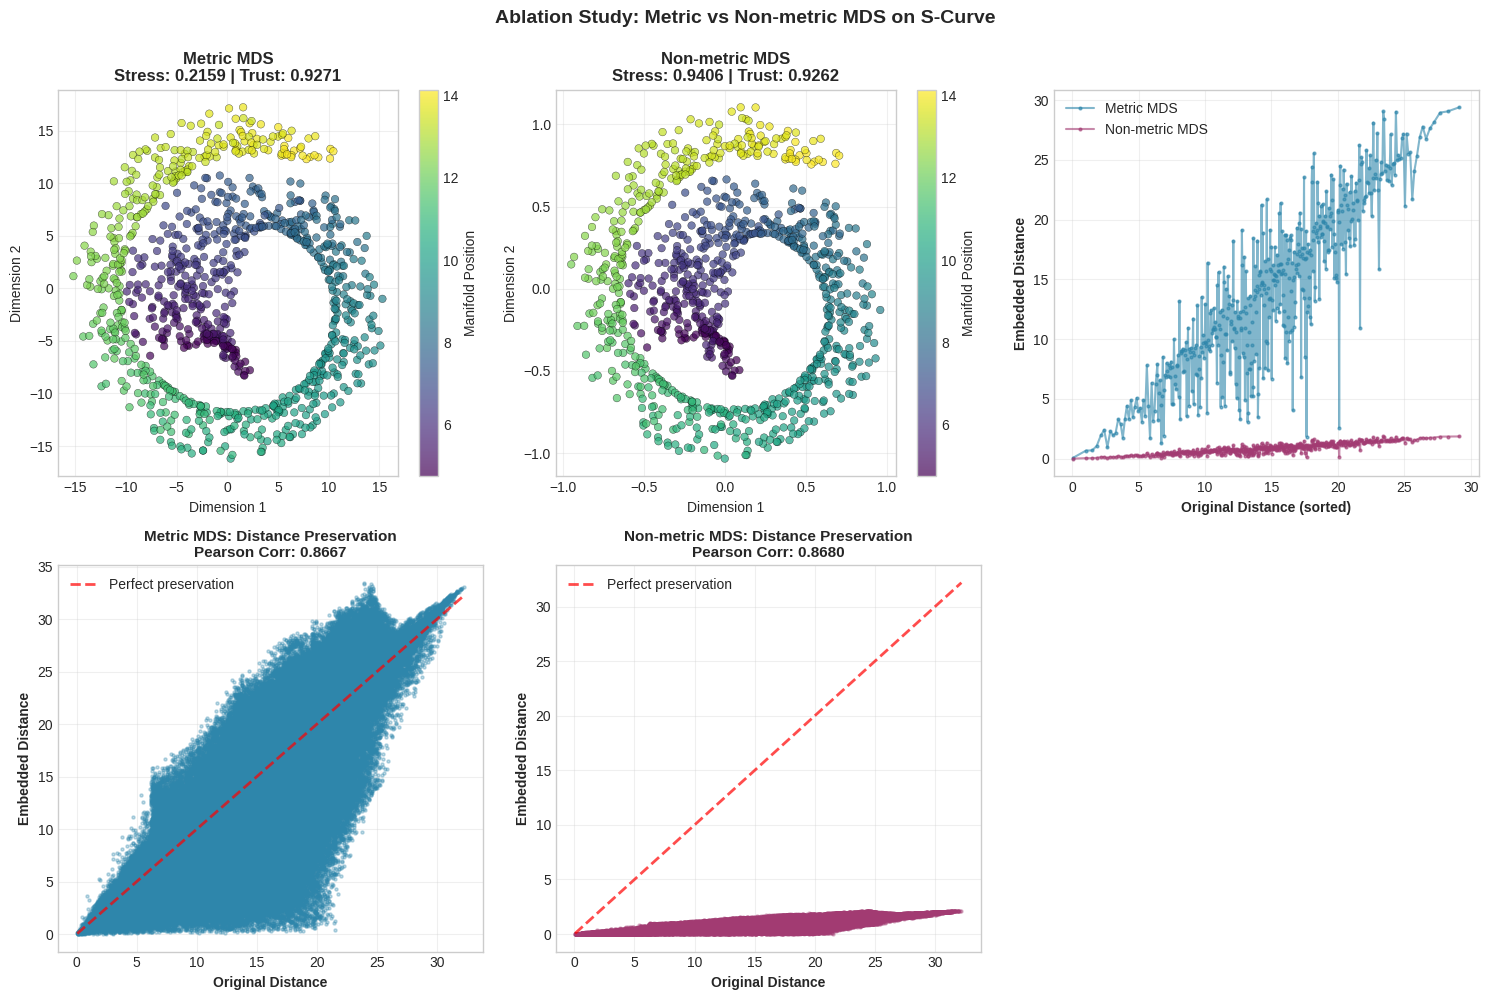

In [68]:
def ablation_mds_metric_vs_nonmetric(X, color=None, dataset_name="Dataset"):
    """
    Compare Metric MDS vs Non-metric MDS with visualization.
    
    Args:
        X: Input data (n_samples, n_features)
        color: Color values for visualization (optional)
        dataset_name: Name of dataset for plotting
    """
    print(f"{'-'*60}")
    print(f"Ablation Study: Metric vs Non-metric MDS")
    print(f"Dataset: {dataset_name}")
    print(f"Data shape: {X.shape}")
    print(f"\n")
    
    X_metric, metrics_metric = run_mds(X, metric=True)
    X_nonmetric, metrics_nonmetric = run_mds(X, metric=False)
    
    # Comparison table
    print(f"{'Metric':<25} {'Metric MDS':<20} {'Non-metric MDS':<20}")
    print("-" * 65)
    
    metric_order = ['trustworthiness', 'stress', 'distance_correlation', 'time']
    
    for key in metric_order:
        val_metric = metrics_metric[key]
        val_nonmetric = metrics_nonmetric[key]

        if key == 'time':
            print(f"{key:<25} {val_metric:<20.4f} {val_nonmetric:<20.4f}")
        else:
            print(f"{key:<25} {val_metric:<20.6f} {val_nonmetric:<20.6f}")
    
    if color is None:
        color = np.arange(len(X))

    fig = plt.figure(figsize=(15, 10))
    
    # 1. Metric MDS embedding
    ax1 = plt.subplot(2, 3, 1)
    scatter1 = ax1.scatter(X_metric[:, 0], X_metric[:, 1], 
                          c=color, cmap='viridis', 
                          s=30, alpha=0.7, edgecolors='black', linewidth=0.3)
    ax1.set_title(f'Metric MDS\nStress: {metrics_metric["stress"]:.4f} | Trust: {metrics_metric["trustworthiness"]:.4f}', 
                  fontsize=12, fontweight='bold')
    ax1.set_xlabel('Dimension 1')
    ax1.set_ylabel('Dimension 2')
    plt.colorbar(scatter1, ax=ax1, label='Manifold Position')
    ax1.grid(True, alpha=0.3)
    
    # 2. Non-metric MDS embedding
    ax2 = plt.subplot(2, 3, 2)
    scatter2 = ax2.scatter(X_nonmetric[:, 0], X_nonmetric[:, 1], 
                          c=color, cmap='viridis', 
                          s=30, alpha=0.7, edgecolors='black', linewidth=0.3)
    ax2.set_title(f'Non-metric MDS\nStress: {metrics_nonmetric["stress"]:.4f} | Trust: {metrics_nonmetric["trustworthiness"]:.4f}', 
                  fontsize=12, fontweight='bold')
    ax2.set_xlabel('Dimension 1')
    ax2.set_ylabel('Dimension 2')
    plt.colorbar(scatter2, ax=ax2, label='Manifold Position')
    ax2.grid(True, alpha=0.3)
    
    # 3. Distance preservation scatter (Metric)
    ax3 = plt.subplot(2, 3, 4)
    D_original = pairwise_distances(X)
    D_metric = pairwise_distances(X_metric)
    D_orig_flat = D_original[np.triu_indices_from(D_original, k=1)]
    D_metric_flat = D_metric[np.triu_indices_from(D_metric, k=1)]
    
    ax3.scatter(D_orig_flat, D_metric_flat, alpha=0.3, s=5, color='#2E86AB')
    ax3.plot([D_orig_flat.min(), D_orig_flat.max()], 
             [D_orig_flat.min(), D_orig_flat.max()], 
             'r--', lw=2, label='Perfect preservation', alpha=0.7)
    ax3.set_xlabel('Original Distance', fontweight='bold')
    ax3.set_ylabel('Embedded Distance', fontweight='bold')
    ax3.set_title(f'Metric MDS: Distance Preservation\nPearson Corr: {metrics_metric["distance_correlation"]:.4f}',
                  fontsize=11, fontweight='bold')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    
    # 4. Distance preservation scatter (Non-metric)
    ax4 = plt.subplot(2, 3, 5)
    D_nonmetric = pairwise_distances(X_nonmetric)
    D_nonmetric_flat = D_nonmetric[np.triu_indices_from(D_nonmetric, k=1)]
    
    ax4.scatter(D_orig_flat, D_nonmetric_flat, alpha=0.3, s=5, color='#A23B72')
    ax4.plot([D_orig_flat.min(), D_orig_flat.max()], 
             [D_orig_flat.min(), D_orig_flat.max()], 
             'r--', lw=2, label='Perfect preservation', alpha=0.7)
    ax4.set_xlabel('Original Distance', fontweight='bold')
    ax4.set_ylabel('Embedded Distance', fontweight='bold')
    ax4.set_title(f'Non-metric MDS: Distance Preservation\nPearson Corr: {metrics_nonmetric["distance_correlation"]:.4f}',
                  fontsize=11, fontweight='bold')
    ax4.legend()
    ax4.grid(True, alpha=0.3)
    
    # 5. Shepard diagram for rank preservation comparison
    ax5 = plt.subplot(2, 3, 3)
    
    # Sort by original distances
    sorted_idx = np.argsort(D_orig_flat)
    orig_sorted = D_orig_flat[sorted_idx]
    metric_sorted = D_metric_flat[sorted_idx]
    nonmetric_sorted = D_nonmetric_flat[sorted_idx]
    
    step = max(1, len(orig_sorted) // 500)
    ax5.plot(orig_sorted[::step], metric_sorted[::step], 'o-', 
             alpha=0.6, label='Metric MDS', linewidth=1.5, markersize=2, color='#2E86AB')
    ax5.plot(orig_sorted[::step], nonmetric_sorted[::step], 'o-', 
             alpha=0.6, label='Non-metric MDS', linewidth=1.5, markersize=2, color='#A23B72')
    ax5.set_xlabel('Original Distance (sorted)', fontweight='bold')
    ax5.set_ylabel('Embedded Distance', fontweight='bold')
    ax5.legend()
    ax5.grid(True, alpha=0.3)
    
    plt.suptitle(f'Ablation Study: Metric vs Non-metric MDS on {dataset_name}', 
                 fontsize=14, fontweight='bold', y=0.995)
    plt.tight_layout()
    plt.show()
    
    return X_metric, X_nonmetric, metrics_metric, metrics_nonmetric

n_samples = 1000
X_S_curve, color_swiss = make_swiss_roll(n_samples=n_samples, noise=0.05, random_state=42)
X_metric, X_nonmetric, metrics_metric, metrics_nonmetric = ablation_mds_metric_vs_nonmetric(
    X_S_curve, color=color_swiss, dataset_name="S-Curve"
)

Ta thấy:

- Cả 2 cách đều trải phẳng dữ liệu thành xoắn ốc. Trust của 2 phương pháp gần như tương đương nhau ($\approx$ 0.94), tuy nhiên có sự khác biệt ở Stress: Metric (0.21) < Non-metric (0.94). Thời gian chạy khi dùng Non-Metric cũng lâu hơn đáng kể so với Metric (>200s so với $\approx$ 20s).
- Ở đồ thị Distance Preservation, các điểm của Metric MDS phân tán xung quanh đường đỏ, có độ lệch nhưng vẫn bám theo đường thẳng tuyến tính. Embedded distance tăng dần đều từ 0 $\rightarrow$ 32, tức là Metric MDS ưu tiên giữ khoảng cách toàn cục của các điểm. 
- Non-metric MDS thì ép bẹp tất cả các điểm, nén khoảng cách giữa các điểm chỉ còn trong khoảng nhỏ từ 0 $\rightarrow$ 3.
- Khi chiếu lên Shepard Diagram, ta thấy rõ sự tách biệt sự phân phối các điểm giữa 2 phương pháp.
- Lí giải cho việc Non-metric MDS có Stress cao hơn hẳn, ta nhận thấy Non-metric MDS ưu tiên bảo toàn thứ tự khoảng cách, nên nó sẽ flatten các embedded distance về giá trị nhỏ nhất có thể miễn là không thay đổi thứ tự này. Các giá trị khoảng cách thực tế bị nén rất mạnh, dẫn đến Stress tăng vọt.
- Ta có thể kết luận được, Metric MDS sẽ hiệu quả khi dữ liệu thể hiện các dữ liệu định lượng như khoảng cách, tọa độ. Non-Metric MDS sẽ hoạt động tốt khi dữ liệu là định tính, như xếp hạng.

Tiếp theo chúng ta sẽ xem xét tham số n_neighbors ảnh hưởng thế nào đến chất lượng của Spectral Embedding.
- Nếu $k$ quá nhỏ: Đồ thị bị rời rạc.
- Nếu $k$ quá lớn: Các kết nối "tắt" xuất hiện làm sai lệch cấu trúc hình học.

Running Ablation Study on n_neighbors...
k=5: Trust=0.938
k=10: Trust=0.888
k=20: Trust=0.944
k=50: Trust=0.910
k=100: Trust=0.916


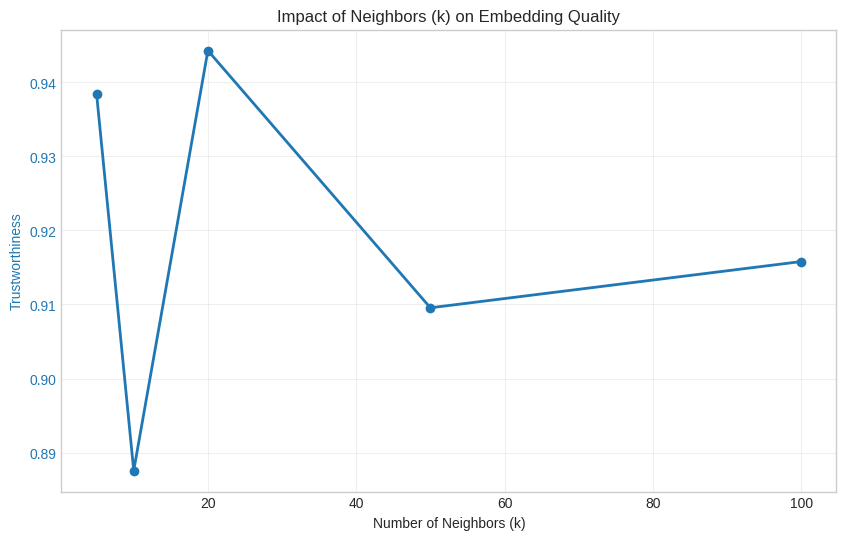

In [69]:
def ablation_study_neighbors(X, y):
    """
    Study how n_neighbors affects Spectral Embedding performance.
    """
    neighbors_list = [5, 10, 20, 50, 100]
    trust_scores = []
    stress_scores = []
    
    print("Running Ablation Study on n_neighbors...")
    
    for k in neighbors_list:
        # Run Spectral with specific k
        se = SpectralEmbedding(n_components=2, affinity='nearest_neighbors', n_neighbors=k)
        X_emb = se.fit_transform(X)
        
        # Calculate metrics
        metrics = compute_quality_metrics(X, X_emb)
        trust_scores.append(metrics['trustworthiness'])
        stress_scores.append(metrics['stress'])
        print(f"k={k}: Trust={metrics['trustworthiness']:.3f}")

    # Plotting results
    fig, ax1 = plt.subplots(figsize=(10, 6))

    color = 'tab:blue'
    ax1.set_xlabel('Number of Neighbors (k)')
    ax1.set_ylabel('Trustworthiness', color=color)
    ax1.plot(neighbors_list, trust_scores, marker='o', color=color, linewidth=2)
    ax1.tick_params(axis='y', labelcolor=color)
    ax1.set_title("Impact of Neighbors (k) on Embedding Quality")
    ax1.grid(True, alpha=0.3)

    plt.show()

# Run ablation on Swiss Roll
ablation_study_neighbors(X_swiss, y_swiss)

Hãy xem điều gì xảy ra với Swiss Roll nếu ta chọn sai cấu hình `affinity='rbf'` cho Spectral Embedding.
- Kỳ vọng: Nó sẽ thất bại, không trải được cuộn giấy ra, hoặc làm méo mó dữ liệu.

Demonstrating the impact of wrong configuration on Swiss Roll...


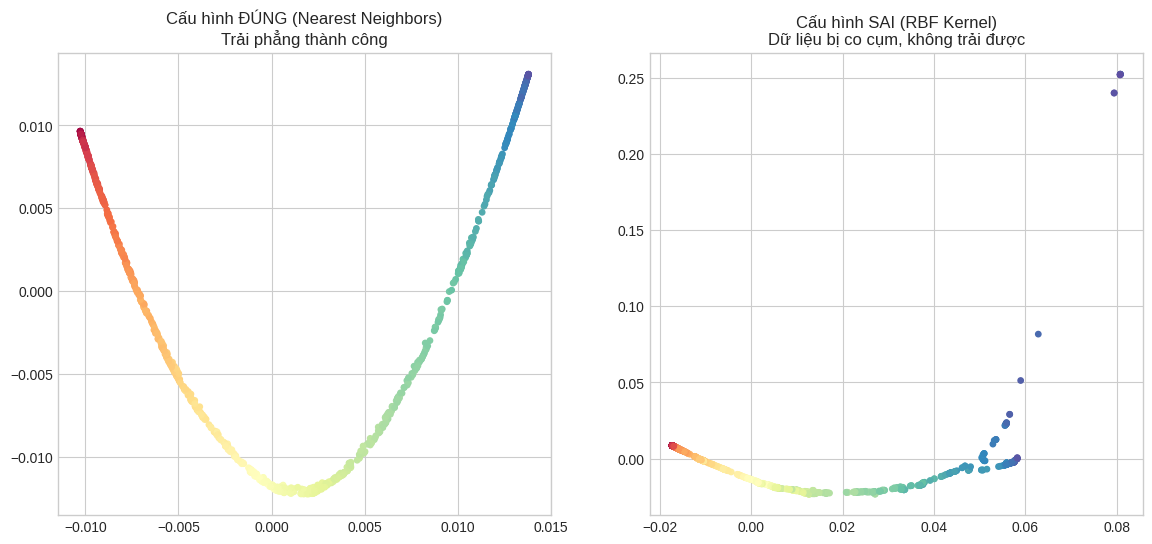

In [70]:
def demonstrate_config_impact(X, y):
    print("Demonstrating the impact of wrong configuration on Swiss Roll...")
    
    # Correct Config: Nearest Neighbors
    se_correct = SpectralEmbedding(n_components=2, affinity='nearest_neighbors', n_neighbors=15)
    X_correct = se_correct.fit_transform(X)
    
    # Wrong Config: RBF (Gaussian Kernel)
    # Gamma=1.0 makes it look at Euclidean distances globally in a radius
    se_wrong = SpectralEmbedding(n_components=2, affinity='rbf', gamma=1.0)
    X_wrong = se_wrong.fit_transform(X)
    
    # Visualize
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
    
    ax1.scatter(X_correct[:, 0], X_correct[:, 1], c=y, cmap='Spectral', s=15)
    ax1.set_title("Cấu hình ĐÚNG (Nearest Neighbors)\nTrải phẳng thành công")
    
    ax2.scatter(X_wrong[:, 0], X_wrong[:, 1], c=y, cmap='Spectral', s=15)
    ax2.set_title("Cấu hình SAI (RBF Kernel)\nDữ liệu bị co cụm, không trải được")
    
    plt.show()


demonstrate_config_impact(X_swiss, y_swiss)

In [71]:
def ablation_mds_metric(X, y, dataset_name):
    """
    So sánh Metric vs Non-Metric MDS với FULL METRICS
    """
    print(f"\n{'='*80}")
    print(f"ABLATION 1: Metric vs Non-Metric MDS (ENHANCED)")
    print(f"Dataset: {dataset_name}")
    print(f"{'='*80}\n")
    
    # Run both versions
    print("Running Metric MDS...")
    start = time.time()
    mds_metric = MDS(n_components=2, metric=True, max_iter=300, n_init=4, random_state=42)
    X_metric = mds_metric.fit_transform(X)
    metrics_metric = compute_quality_metrics(X, X_metric, y)
    metrics_metric['time'] = time.time() - start
    
    print("Running Non-Metric MDS...")
    start = time.time()
    mds_nonmetric = MDS(n_components=2, metric=False, max_iter=300, n_init=4, random_state=42)
    X_nonmetric = mds_nonmetric.fit_transform(X)
    metrics_nonmetric = compute_quality_metrics(X, X_nonmetric, y)
    metrics_nonmetric['time'] = time.time() - start
    
    # Print comprehensive comparison
    print(f"\n{'Metric':<30} {'Metric MDS':<20} {'Non-Metric MDS':<20} {'Winner':<10}")
    print("-" * 80)
    
    metrics_to_compare = [
        ('trustworthiness', 'higher'),
        ('continuity', 'higher'),
        ('stress', 'lower'),
        ('distance_correlation', 'higher'),
        ('spearman_correlation', 'higher'),
        ('silhouette', 'higher'),
        ('time', 'lower')
    ]
    
    for metric, direction in metrics_to_compare:
        val_metric = metrics_metric.get(metric, 0)
        val_nonmetric = metrics_nonmetric.get(metric, 0)
        
        if val_metric is None or val_nonmetric is None:
            continue
            
        if direction == 'higher':
            winner = 'Metric' if val_metric > val_nonmetric else 'Non-Metric'
        else:
            winner = 'Metric' if val_metric < val_nonmetric else 'Non-Metric'
        
        print(f"{metric:<30} {val_metric:<20.4f} {val_nonmetric:<20.4f} {winner:<10}")
    
    # Enhanced Visualization
    fig = plt.figure(figsize=(20, 12))
    
    # 1. Embeddings
    ax1 = plt.subplot(3, 3, 1)
    scatter1 = ax1.scatter(X_metric[:, 0], X_metric[:, 1], c=y, cmap='viridis', 
                          s=30, alpha=0.7, edgecolors='k', linewidth=0.3)
    ax1.set_title(f"Metric MDS\nTrust: {metrics_metric['trustworthiness']:.3f} | "
                 f"Sil: {metrics_metric.get('silhouette', 0):.3f}",
                 fontsize=11, fontweight='bold')
    plt.colorbar(scatter1, ax=ax1)
    
    ax2 = plt.subplot(3, 3, 2)
    scatter2 = ax2.scatter(X_nonmetric[:, 0], X_nonmetric[:, 1], c=y, cmap='viridis',
                          s=30, alpha=0.7, edgecolors='k', linewidth=0.3)
    ax2.set_title(f"Non-Metric MDS\nTrust: {metrics_nonmetric['trustworthiness']:.3f} | "
                 f"Sil: {metrics_nonmetric.get('silhouette', 0):.3f}",
                 fontsize=11, fontweight='bold')
    plt.colorbar(scatter2, ax=ax2)
    
    # 2. Metrics comparison bar chart
    ax3 = plt.subplot(3, 3, 3)
    metrics_names = ['Trust', 'Cont', 'Sil']
    metric_vals = [metrics_metric['trustworthiness'], metrics_metric['continuity'], 
                   metrics_metric.get('silhouette', 0)]
    nonmetric_vals = [metrics_nonmetric['trustworthiness'], metrics_nonmetric['continuity'],
                     metrics_nonmetric.get('silhouette', 0)]
    
    x = np.arange(len(metrics_names))
    width = 0.35
    ax3.bar(x - width/2, metric_vals, width, label='Metric', color='#2E86AB')
    ax3.bar(x + width/2, nonmetric_vals, width, label='Non-Metric', color='#A23B72')
    ax3.set_xticks(x)
    ax3.set_xticklabels(metrics_names)
    ax3.set_ylabel('Score', fontweight='bold')
    ax3.set_title('Quality Metrics', fontweight='bold')
    ax3.legend()
    ax3.grid(True, alpha=0.3, axis='y')
    
    # 3. Distance preservation (Metric)
    ax4 = plt.subplot(3, 3, 4)
    D_orig = pairwise_distances(X)
    D_metric = pairwise_distances(X_metric)
    D_orig_flat = D_orig[np.triu_indices_from(D_orig, k=1)]
    D_metric_flat = D_metric[np.triu_indices_from(D_metric, k=1)]
    
    ax4.scatter(D_orig_flat, D_metric_flat, alpha=0.3, s=5, color='#2E86AB')
    ax4.plot([D_orig_flat.min(), D_orig_flat.max()],
             [D_orig_flat.min(), D_orig_flat.max()], 'r--', lw=2, alpha=0.7)
    ax4.set_xlabel('Original Distance', fontweight='bold')
    ax4.set_ylabel('Embedded Distance', fontweight='bold')
    ax4.set_title(f'Metric MDS: Distance Preservation\n'
                 f'Pearson: {metrics_metric["distance_correlation"]:.3f} | '
                 f'Spearman: {metrics_metric["spearman_correlation"]:.3f}',
                 fontsize=10, fontweight='bold')
    ax4.grid(True, alpha=0.3)
    
    # 4. Distance preservation (Non-Metric)
    ax5 = plt.subplot(3, 3, 5)
    D_nonmetric = pairwise_distances(X_nonmetric)
    D_nonmetric_flat = D_nonmetric[np.triu_indices_from(D_nonmetric, k=1)]
    
    ax5.scatter(D_orig_flat, D_nonmetric_flat, alpha=0.3, s=5, color='#A23B72')
    ax5.plot([D_orig_flat.min(), D_orig_flat.max()],
             [D_orig_flat.min(), D_orig_flat.max()], 'r--', lw=2, alpha=0.7)
    ax5.set_xlabel('Original Distance', fontweight='bold')
    ax5.set_ylabel('Embedded Distance', fontweight='bold')
    ax5.set_title(f'Non-Metric MDS: Distance Preservation\n'
                 f'Pearson: {metrics_nonmetric["distance_correlation"]:.3f} | '
                 f'Spearman: {metrics_nonmetric["spearman_correlation"]:.3f}',
                 fontsize=10, fontweight='bold')
    ax5.grid(True, alpha=0.3)
    
    # 5. Shepard Diagram (Rank preservation)
    ax6 = plt.subplot(3, 3, 6)
    sorted_idx = np.argsort(D_orig_flat)
    step = max(1, len(sorted_idx) // 500)
    
    ax6.plot(D_orig_flat[sorted_idx][::step], D_metric_flat[sorted_idx][::step], 
             'o-', alpha=0.6, label='Metric', markersize=2, linewidth=1.5, color='#2E86AB')
    ax6.plot(D_orig_flat[sorted_idx][::step], D_nonmetric_flat[sorted_idx][::step],
             'o-', alpha=0.6, label='Non-Metric', markersize=2, linewidth=1.5, color='#A23B72')
    ax6.set_xlabel('Original Distance (sorted)', fontweight='bold')
    ax6.set_ylabel('Embedded Distance', fontweight='bold')
    ax6.set_title('Shepard Diagram\n(Rank Preservation)', fontweight='bold')
    ax6.legend()
    ax6.grid(True, alpha=0.3)
    
    # 6. Stress comparison
    ax7 = plt.subplot(3, 3, 7)
    methods = ['Metric', 'Non-Metric']
    stresses = [metrics_metric['stress'], metrics_nonmetric['stress']]
    colors = ['#2E86AB', '#A23B72']
    bars = ax7.bar(methods, stresses, color=colors, alpha=0.7, edgecolor='black')
    ax7.set_ylabel('Normalized Stress', fontweight='bold')
    ax7.set_title('Stress Comparison', fontweight='bold')
    ax7.grid(True, alpha=0.3, axis='y')
    
    # Add value labels on bars
    for bar, val in zip(bars, stresses):
        height = bar.get_height()
        ax7.text(bar.get_x() + bar.get_width()/2., height,
                f'{val:.4f}', ha='center', va='bottom', fontweight='bold')
    
    # 7. Time comparison
    ax8 = plt.subplot(3, 3, 8)
    times = [metrics_metric['time'], metrics_nonmetric['time']]
    bars = ax8.bar(methods, times, color=colors, alpha=0.7, edgecolor='black')
    ax8.set_ylabel('Time (seconds)', fontweight='bold')
    ax8.set_title('Computation Time', fontweight='bold')
    ax8.grid(True, alpha=0.3, axis='y')
    
    for bar, val in zip(bars, times):
        height = bar.get_height()
        ax8.text(bar.get_x() + bar.get_width()/2., height,
                f'{val:.2f}s', ha='center', va='bottom', fontweight='bold')
    
    # 8. Distance histogram comparison
    ax9 = plt.subplot(3, 3, 9)
    ax9.hist(D_metric_flat, bins=50, alpha=0.5, label='Metric', color='#2E86AB', density=True)
    ax9.hist(D_nonmetric_flat, bins=50, alpha=0.5, label='Non-Metric', color='#A23B72', density=True)
    ax9.set_xlabel('Embedded Distance', fontweight='bold')
    ax9.set_ylabel('Density', fontweight='bold')
    ax9.set_title('Distance Distribution', fontweight='bold')
    ax9.legend()
    ax9.grid(True, alpha=0.3, axis='y')
    
    plt.suptitle(f"Ablation: Metric vs Non-Metric MDS | {dataset_name}",
                 fontsize=14, fontweight='bold', y=0.995)
    plt.tight_layout()
    plt.show()
    
    return metrics_metric, metrics_nonmetric
    

def ablation_spectral_neighbors(X, y, dataset_name):
    """
    Nghiên cứu n_neighbors với visualization embeddings
    """
    print(f"\n{'='*80}")
    print(f"ABLATION 2: Spectral Embedding n_neighbors (ENHANCED)")
    print(f"Dataset: {dataset_name}")
    print(f"{'='*80}\n")
    
    k_values = [5, 10, 15, 20, 30, 50]
    results = []
    embeddings = []
    
    for k in k_values:
        print(f"Testing k={k}...")
        start = time.time()
        se = SpectralEmbedding(n_components=2, affinity='nearest_neighbors',
                              n_neighbors=k, random_state=42)
        X_emb = se.fit_transform(X)
        embeddings.append(X_emb)
        
        metrics = compute_quality_metrics(X, X_emb, y)
        metrics['time'] = time.time() - start
        metrics['k'] = k
        
        results.append(metrics)
    
    df = pd.DataFrame(results)
    
    # Find optimal k
    combined_quality = (df['trustworthiness'] + df['continuity']) / 2
    optimal_idx = combined_quality.idxmax()
    optimal_k = df.iloc[optimal_idx]['k']
    
    print(f"\n>>> Optimal k: {optimal_k} (Combined Quality: {combined_quality.iloc[optimal_idx]:.4f})")
    
    # Enhanced Visualization
    fig = plt.figure(figsize=(20, 16))
    
    # Row 1: Metrics plots
    ax1 = plt.subplot(4, 3, 1)
    ax1.plot(df['k'], df['trustworthiness'], 'o-', linewidth=2, markersize=8, color='#2E86AB')
    ax1.axvline(x=optimal_k, color='r', linestyle='--', alpha=0.5, label=f'Optimal k={optimal_k}')
    ax1.set_xlabel('n_neighbors (k)', fontweight='bold')
    ax1.set_ylabel('Trustworthiness', fontweight='bold')
    ax1.set_title('Trustworthiness vs k', fontweight='bold')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    ax2 = plt.subplot(4, 3, 2)
    ax2.plot(df['k'], df['continuity'], 'o-', linewidth=2, markersize=8, color='#A23B72')
    ax2.axvline(x=optimal_k, color='r', linestyle='--', alpha=0.5)
    ax2.set_xlabel('n_neighbors (k)', fontweight='bold')
    ax2.set_ylabel('Continuity', fontweight='bold')
    ax2.set_title('Continuity vs k', fontweight='bold')
    ax2.grid(True, alpha=0.3)
    
    ax3 = plt.subplot(4, 3, 3)
    ax3.plot(df['k'], df['stress'], 'o-', linewidth=2, markersize=8, color='#F18F01')
    ax3.axvline(x=optimal_k, color='r', linestyle='--', alpha=0.5)
    ax3.set_xlabel('n_neighbors (k)', fontweight='bold')
    ax3.set_ylabel('Normalized Stress', fontweight='bold')
    ax3.set_title('Stress vs k', fontweight='bold')
    ax3.grid(True, alpha=0.3)
    
    # Row 2: More metrics
    ax4 = plt.subplot(4, 3, 4)
    if 'silhouette' in df.columns and df['silhouette'].notna().any():
        ax4.plot(df['k'], df['silhouette'], 'o-', linewidth=2, markersize=8, color='#2E86AB')
        ax4.axvline(x=optimal_k, color='r', linestyle='--', alpha=0.5)
        ax4.set_xlabel('n_neighbors (k)', fontweight='bold')
        ax4.set_ylabel('Silhouette Score', fontweight='bold')
        ax4.set_title('Cluster Quality vs k', fontweight='bold')
        ax4.grid(True, alpha=0.3)
    
    ax5 = plt.subplot(4, 3, 5)
    ax5.plot(df['k'], df['time'], 'o-', linewidth=2, markersize=8, color='#F18F01')
    ax5.set_xlabel('n_neighbors (k)', fontweight='bold')
    ax5.set_ylabel('Time (seconds)', fontweight='bold')
    ax5.set_title('Computation Time vs k', fontweight='bold')
    ax5.grid(True, alpha=0.3)
    
    ax6 = plt.subplot(4, 3, 6)
    ax6.plot(df['k'], combined_quality, 'o-', linewidth=2, markersize=8, color='#2E86AB')
    ax6.axvline(x=optimal_k, color='r', linestyle='--', alpha=0.5, label=f'Optimal={optimal_k}')
    ax6.set_xlabel('n_neighbors (k)', fontweight='bold')
    ax6.set_ylabel('Combined Quality', fontweight='bold')
    ax6.set_title('Overall Quality (Trust+Cont)/2', fontweight='bold')
    ax6.legend()
    ax6.grid(True, alpha=0.3)
    
    # Rows 3-4: Embedding visualizations for key k values
    key_k_indices = [0, 2, 4, 5]  # k=5, 15, 30, 50
    for i, idx in enumerate(key_k_indices):
        ax = plt.subplot(4, 3, 7 + i)
        k = k_values[idx]
        scatter = ax.scatter(embeddings[idx][:, 0], embeddings[idx][:, 1],
                           c=y, cmap='viridis', s=20, alpha=0.7, edgecolors='k', linewidth=0.3)
        
        is_optimal = (k == optimal_k)
        title_prefix = "★ " if is_optimal else ""
        ax.set_title(f'{title_prefix}k={k}\n'
                    f'Trust: {df.iloc[idx]["trustworthiness"]:.3f} | '
                    f'Sil: {df.iloc[idx].get("silhouette", 0):.3f}',
                    fontsize=10, fontweight='bold',
                    color='red' if is_optimal else 'black')
        plt.colorbar(scatter, ax=ax)
    
    plt.suptitle(f"Ablation: Spectral n_neighbors | {dataset_name}",
                 fontsize=14, fontweight='bold', y=0.995)
    plt.tight_layout()
    plt.show()
    
    print("\nResults Table:")
    print(df.to_string(index=False))
    
    return df


def ablation_spectral_affinity(X, y, dataset_name):
    """
    So sánh affinity functions với phân tích sâu
    """
    print(f"\n{'='*80}")
    print(f"ABLATION 3: Spectral Affinity Functions (ENHANCED)")
    print(f"Dataset: {dataset_name}")
    print(f"{'='*80}\n")
    
    # Test both affinity functions
    print("Running Nearest Neighbors...")
    start = time.time()
    se_nn = SpectralEmbedding(n_components=2, affinity='nearest_neighbors',
                             n_neighbors=15, random_state=42)
    X_nn = se_nn.fit_transform(X)
    metrics_nn = compute_quality_metrics(X, X_nn, y)
    metrics_nn['time'] = time.time() - start
    
    print("Running RBF Kernel...")
    start = time.time()
    se_rbf = SpectralEmbedding(n_components=2, affinity='rbf',
                              gamma=1.0, random_state=42)
    X_rbf = se_rbf.fit_transform(X)
    metrics_rbf = compute_quality_metrics(X, X_rbf, y)
    metrics_rbf['time'] = time.time() - start
    
    # Comparison
    print(f"\n{'Metric':<30} {'Nearest Neighbors':<20} {'RBF Kernel':<20} {'Winner':<10}")
    print("-" * 80)
    
    for metric, direction in [('trustworthiness', 'higher'), ('continuity', 'higher'),
                             ('stress', 'lower'), ('silhouette', 'higher'), ('time', 'lower')]:
        val_nn = metrics_nn.get(metric, 0)
        val_rbf = metrics_rbf.get(metric, 0)
        
        if val_nn is None or val_rbf is None:
            continue
        
        if direction == 'higher':
            winner = 'NN' if val_nn > val_rbf else 'RBF'
        else:
            winner = 'NN' if val_nn < val_rbf else 'RBF'
        
        print(f"{metric:<30} {val_nn:<20.4f} {val_rbf:<20.4f} {winner:<10}")
    
    # Enhanced Visualization
    fig = plt.figure(figsize=(20, 10))
    
    # Embeddings
    ax1 = plt.subplot(2, 4, 1)
    scatter1 = ax1.scatter(X_nn[:, 0], X_nn[:, 1], c=y, cmap='viridis',
                          s=30, alpha=0.7, edgecolors='k', linewidth=0.3)
    ax1.set_title(f"Nearest Neighbors (k=15)\n"
                 f"Trust: {metrics_nn['trustworthiness']:.3f} | "
                 f"Sil: {metrics_nn.get('silhouette', 0):.3f}",
                 fontsize=11, fontweight='bold')
    plt.colorbar(scatter1, ax=ax1)
    
    ax2 = plt.subplot(2, 4, 2)
    scatter2 = ax2.scatter(X_rbf[:, 0], X_rbf[:, 1], c=y, cmap='viridis',
                          s=30, alpha=0.7, edgecolors='k', linewidth=0.3)
    ax2.set_title(f"RBF Kernel (γ=1.0)\n"
                 f"Trust: {metrics_rbf['trustworthiness']:.3f} | "
                 f"Sil: {metrics_rbf.get('silhouette', 0):.3f}",
                 fontsize=11, fontweight='bold')
    plt.colorbar(scatter2, ax=ax2)
    
    # Metrics comparison
    ax3 = plt.subplot(2, 4, 3)
    metrics_names = ['Trust', 'Cont', 'Sil']
    nn_vals = [metrics_nn['trustworthiness'], metrics_nn['continuity'],
               metrics_nn.get('silhouette', 0)]
    rbf_vals = [metrics_rbf['trustworthiness'], metrics_rbf['continuity'],
                metrics_rbf.get('silhouette', 0)]
    
    x = np.arange(len(metrics_names))
    width = 0.35
    ax3.bar(x - width/2, nn_vals, width, label='NN', color='#2E86AB')
    ax3.bar(x + width/2, rbf_vals, width, label='RBF', color='#A23B72')
    ax3.set_xticks(x)
    ax3.set_xticklabels(metrics_names)
    ax3.set_ylabel('Score', fontweight='bold')
    ax3.set_title('Quality Metrics', fontweight='bold')
    ax3.legend()
    ax3.grid(True, alpha=0.3, axis='y')
    
    # Stress & Time
    ax4 = plt.subplot(2, 4, 4)
    methods = ['NN', 'RBF']
    stresses = [metrics_nn['stress'], metrics_rbf['stress']]
    times = [metrics_nn['time'], metrics_rbf['time']]
    
    x = np.arange(len(methods))
    ax4_twin = ax4.twinx()
    
    bars1 = ax4.bar(x - 0.2, stresses, 0.4, label='Stress', color='#F18F01', alpha=0.7)
    bars2 = ax4_twin.bar(x + 0.2, times, 0.4, label='Time', color='#C73E1D', alpha=0.7)
    
    ax4.set_xticks(x)
    ax4.set_xticklabels(methods)
    ax4.set_ylabel('Stress', fontweight='bold', color='#F18F01')
    ax4_twin.set_ylabel('Time (s)', fontweight='bold', color='#C73E1D')
    ax4.set_title('Stress & Time', fontweight='bold')
    ax4.tick_params(axis='y', labelcolor='#F18F01')
    ax4_twin.tick_params(axis='y', labelcolor='#C73E1D')
    
    # Distance preservation comparison
    D_orig = pairwise_distances(X)
    D_orig_flat = D_orig[np.triu_indices_from(D_orig, k=1)]
    
    ax5 = plt.subplot(2, 4, 5)
    D_nn = pairwise_distances(X_nn)
    D_nn_flat = D_nn[np.triu_indices_from(D_nn, k=1)]
    ax5.scatter(D_orig_flat, D_nn_flat, alpha=0.3, s=5, color='#2E86AB')
    ax5.plot([D_orig_flat.min(), D_orig_flat.max()],
             [D_orig_flat.min(), D_orig_flat.max()], 'r--', lw=2, alpha=0.7)
    ax5.set_xlabel('Original Distance', fontweight='bold')
    ax5.set_ylabel('Embedded Distance', fontweight='bold')
    ax5.set_title(f'NN Distance Preservation\n'
                 f'Corr: {metrics_nn["distance_correlation"]:.3f}',
                 fontweight='bold')
    ax5.grid(True, alpha=0.3)
    
    ax6 = plt.subplot(2, 4, 6)
    D_rbf = pairwise_distances(X_rbf)
    D_rbf_flat = D_rbf[np.triu_indices_from(D_rbf, k=1)]
    ax6.scatter(D_orig_flat, D_rbf_flat, alpha=0.3, s=5, color='#A23B72')
    ax6.plot([D_orig_flat.min(), D_orig_flat.max()],
             [D_orig_flat.min(), D_orig_flat.max()], 'r--', lw=2, alpha=0.7)
    ax6.set_xlabel('Original Distance', fontweight='bold')
    ax6.set_ylabel('Embedded Distance', fontweight='bold')
    ax6.set_title(f'RBF Distance Preservation\n'
                 f'Corr: {metrics_rbf["distance_correlation"]:.3f}',
                 fontweight='bold')
    ax6.grid(True, alpha=0.3)
    
    # Graph connectivity visualization (conceptual)
    ax7 = plt.subplot(2, 4, 7)
    ax7.text(0.5, 0.7, 'Nearest Neighbors\nGraph Type:', 
            ha='center', va='center', fontsize=12, fontweight='bold')
    ax7.text(0.5, 0.5, 'Sparse Graph', 
            ha='center', va='center', fontsize=14, color='#2E86AB')
    ax7.text(0.5, 0.3, f'k={15} connections per node',
            ha='center', va='center', fontsize=10)
    ax7.axis('off')
    
    ax8 = plt.subplot(2, 4, 8)
    ax8.text(0.5, 0.7, 'RBF Kernel\nGraph Type:',
            ha='center', va='center', fontsize=12, fontweight='bold')
    ax8.text(0.5, 0.5, 'Dense Graph',
            ha='center', va='center', fontsize=14, color='#A23B72')
    ax8.text(0.5, 0.3, f'γ={1.0} controls decay',
            ha='center', va='center', fontsize=10)
    ax8.axis('off')
    
    plt.suptitle(f"Ablation: Spectral Affinity Functions | {dataset_name}",
                 fontsize=14, fontweight='bold', y=0.995)
    plt.tight_layout()
    plt.show()
    
    return metrics_nn, metrics_rbf


def ablation_mds_init_methods(X, y, dataset_name):
    """
    So sánh các phương pháp khởi tạo của MDS
    """
    print(f"\n{'='*80}")
    print(f"ABLATION STUDY 1: MDS Initialization Methods")
    print(f"Dataset: {dataset_name}")
    print(f"{'='*80}\n")
    
    # n_init controls number of times algorithm runs with different seeds
    # We test: 1, 4, 10
    n_init_values = [1, 4, 10]
    results = []
    
    for n_init in n_init_values:
        print(f"Testing n_init={n_init}...")
        start_time = time.time()
        
        mds = MDS(n_components=2, metric=True, max_iter=300, 
                  n_init=n_init, random_state=42)
        X_embedded = mds.fit_transform(X)
        
        metrics = compute_quality_metrics(X, X_embedded, y)
        metrics['time'] = time.time() - start_time
        metrics['n_init'] = n_init
        
        results.append(metrics)
    
    df = pd.DataFrame(results)
    
    # Visualization
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # Trust & Continuity
    ax = axes[0, 0]
    ax.plot(df['n_init'], df['trustworthiness'], 'o-', label='Trustworthiness', 
            linewidth=2, markersize=8, color='#2E86AB')
    ax.plot(df['n_init'], df['continuity'], 's-', label='Continuity', 
            linewidth=2, markersize=8, color='#A23B72')
    ax.set_xlabel('n_init', fontweight='bold')
    ax.set_ylabel('Score', fontweight='bold')
    ax.set_title('Neighborhood Preservation', fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # Stress
    ax = axes[0, 1]
    ax.plot(df['n_init'], df['stress'], 'o-', linewidth=2, markersize=8, color='#F18F01')
    ax.set_xlabel('n_init', fontweight='bold')
    ax.set_ylabel('Normalized Stress', fontweight='bold')
    ax.set_title('Distance Distortion', fontweight='bold')
    ax.grid(True, alpha=0.3)
    
    # Correlations
    ax = axes[1, 0]
    ax.plot(df['n_init'], df['distance_correlation'], 'o-', 
            label='Pearson', linewidth=2, markersize=8, color='#2E86AB')
    ax.plot(df['n_init'], df['spearman_correlation'], 's-', 
            label='Spearman', linewidth=2, markersize=8, color='#A23B72')
    ax.set_xlabel('n_init', fontweight='bold')
    ax.set_ylabel('Correlation', fontweight='bold')
    ax.set_title('Distance Correlation', fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # Time
    ax = axes[1, 1]
    ax.plot(df['n_init'], df['time'], 'o-', linewidth=2, markersize=8, color='#F18F01')
    ax.set_xlabel('n_init', fontweight='bold')
    ax.set_ylabel('Time (seconds)', fontweight='bold')
    ax.set_title('Computation Time', fontweight='bold')
    ax.grid(True, alpha=0.3)
    
    plt.suptitle(f"Ablation: MDS n_init | {dataset_name}", 
                 fontsize=14, fontweight='bold', y=0.995)
    plt.tight_layout()
    plt.show()
    
    print("\nResults Table:")
    print(df.to_string(index=False))
    
    return df


def ablation_spectral_gamma(X, y, dataset_name):
    """
    Nghiên cứu ảnh hưởng của gamma trong RBF kernel
    """
    print(f"\n{'='*80}")
    print(f"ABLATION STUDY 2: Spectral Embedding RBF Gamma")
    print(f"Dataset: {dataset_name}")
    print(f"{'='*80}\n")
    
    gamma_values = [0.01, 0.1, 0.5, 1.0, 2.0, 5.0]
    results = []
    embeddings = []
    
    for gamma in gamma_values:
        print(f"Testing gamma={gamma}...")
        start_time = time.time()
        
        se = SpectralEmbedding(n_components=2, affinity='rbf', 
                               gamma=gamma, random_state=42)
        X_embedded = se.fit_transform(X)
        embeddings.append(X_embedded)
        
        metrics = compute_quality_metrics(X, X_embedded, y)
        metrics['time'] = time.time() - start_time
        metrics['gamma'] = gamma
        
        results.append(metrics)
    
    df = pd.DataFrame(results)
    
    # Visualization
    fig = plt.figure(figsize=(20, 12))
    
    # Metrics plots
    for i, (metric_name, ylabel) in enumerate([
        ('trustworthiness', 'Trustworthiness'),
        ('continuity', 'Continuity'),
        ('stress', 'Normalized Stress'),
        ('silhouette', 'Silhouette Score')
    ], 1):
        ax = plt.subplot(3, 3, i)
        ax.plot(df['gamma'], df[metric_name], 'o-', linewidth=2, markersize=8)
        ax.set_xlabel('Gamma (γ)', fontweight='bold')
        ax.set_ylabel(ylabel, fontweight='bold')
        ax.set_title(ylabel, fontweight='bold')
        ax.set_xscale('log')
        ax.grid(True, alpha=0.3)
    
    # Embedding visualizations for key gamma values
    key_gammas = [0.01, 0.5, 5.0]
    for i, gamma in enumerate(key_gammas, 5):
        idx = gamma_values.index(gamma)
        ax = plt.subplot(3, 3, i)
        scatter = ax.scatter(embeddings[idx][:, 0], embeddings[idx][:, 1], 
                            c=y, cmap='viridis', s=20, alpha=0.7)
        ax.set_title(f'γ={gamma}\nTrust={df.iloc[idx]["trustworthiness"]:.3f}',
                    fontweight='bold')
        plt.colorbar(scatter, ax=ax)
    
    plt.suptitle(f"Ablation: Spectral RBF Gamma | {dataset_name}", 
                 fontsize=14, fontweight='bold', y=0.995)
    plt.tight_layout()
    plt.show()
    
    print("\nResults Table:")
    print(df.to_string(index=False))
    
    return df


def ablation_mds_max_iter(X, y, dataset_name):
    """
    Nghiên cứu ảnh hưởng của max_iter đến convergence
    """
    print(f"\n{'='*80}")
    print(f"ABLATION STUDY 3: MDS max_iter (Convergence)")
    print(f"Dataset: {dataset_name}")
    print(f"{'='*80}\n")
    
    max_iter_values = [50, 100, 200, 300, 500]
    results = []
    
    for max_iter in max_iter_values:
        print(f"Testing max_iter={max_iter}...")
        start_time = time.time()
        
        mds = MDS(n_components=2, metric=True, max_iter=max_iter,
                  n_init=4, random_state=42)
        X_embedded = mds.fit_transform(X)
        
        metrics = compute_quality_metrics(X, X_embedded, y)
        metrics['time'] = time.time() - start_time
        metrics['max_iter'] = max_iter
        metrics['n_iter'] = mds.n_iter_  # Actual iterations used
        
        results.append(metrics)
    
    df = pd.DataFrame(results)
    
    # Visualization
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # Stress convergence
    ax = axes[0, 0]
    ax.plot(df['max_iter'], df['stress'], 'o-', linewidth=2, markersize=8, color='#F18F01')
    ax.set_xlabel('max_iter', fontweight='bold')
    ax.set_ylabel('Final Stress', fontweight='bold')
    ax.set_title('Stress Convergence', fontweight='bold')
    ax.grid(True, alpha=0.3)
    
    # Trust & Continuity
    ax = axes[0, 1]
    ax.plot(df['max_iter'], df['trustworthiness'], 'o-', label='Trustworthiness',
            linewidth=2, markersize=8, color='#2E86AB')
    ax.plot(df['max_iter'], df['continuity'], 's-', label='Continuity',
            linewidth=2, markersize=8, color='#A23B72')
    ax.set_xlabel('max_iter', fontweight='bold')
    ax.set_ylabel('Score', fontweight='bold')
    ax.set_title('Neighborhood Preservation', fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # Actual iterations vs max_iter
    ax = axes[1, 0]
    ax.plot(df['max_iter'], df['n_iter'], 'o-', linewidth=2, markersize=8, color='#2E86AB')
    ax.plot([df['max_iter'].min(), df['max_iter'].max()], 
            [df['max_iter'].min(), df['max_iter'].max()], 
            'r--', alpha=0.5, label='max_iter limit')
    ax.set_xlabel('max_iter (limit)', fontweight='bold')
    ax.set_ylabel('Actual iterations', fontweight='bold')
    ax.set_title('Convergence Before Limit', fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # Time vs quality tradeoff
    ax = axes[1, 1]
    scatter = ax.scatter(df['time'], df['stress'], s=df['max_iter'], 
                        c=df['max_iter'], cmap='viridis', alpha=0.7)
    ax.set_xlabel('Time (seconds)', fontweight='bold')
    ax.set_ylabel('Stress', fontweight='bold')
    ax.set_title('Time-Quality Tradeoff', fontweight='bold')
    plt.colorbar(scatter, ax=ax, label='max_iter')
    ax.grid(True, alpha=0.3)
    
    plt.suptitle(f"Ablation: MDS max_iter | {dataset_name}", 
                 fontsize=14, fontweight='bold', y=0.995)
    plt.tight_layout()
    plt.show()
    
    print("\nResults Table:")
    print(df.to_string(index=False))
    
    return df


def ablation_spectral_adaptive_k(X, y, dataset_name):
    """
    Nghiên cứu mối quan hệ giữa k_neighbors và mật độ dữ liệu
    """
    print(f"\n{'='*80}")
    print(f"ABLATION STUDY 4: Spectral Adaptive k (Data Density)")
    print(f"Dataset: {dataset_name}")
    print(f"{'='*80}\n")
    
    # Test k as percentage of dataset size
    n_samples = X.shape[0]
    k_percentages = [0.5, 1.0, 2.0, 3.0, 5.0]  # percentage
    k_values = [max(5, int(n_samples * p / 100)) for p in k_percentages]
    
    results = []
    
    for k, pct in zip(k_values, k_percentages):
        print(f"Testing k={k} ({pct}% of dataset)...")
        start_time = time.time()
        
        se = SpectralEmbedding(n_components=2, affinity='nearest_neighbors',
                               n_neighbors=k, random_state=42)
        X_embedded = se.fit_transform(X)
        
        metrics = compute_quality_metrics(X, X_embedded, y)
        metrics['time'] = time.time() - start_time
        metrics['k'] = k
        metrics['k_percentage'] = pct
        
        results.append(metrics)
    
    df = pd.DataFrame(results)
    
    # Visualization
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # Trust vs k percentage
    ax = axes[0, 0]
    ax.plot(df['k_percentage'], df['trustworthiness'], 'o-', 
            linewidth=2, markersize=8, color='#2E86AB')
    ax.set_xlabel('k (% of dataset size)', fontweight='bold')
    ax.set_ylabel('Trustworthiness', fontweight='bold')
    ax.set_title('Trustworthiness vs Relative k', fontweight='bold')
    ax.grid(True, alpha=0.3)
    
    # Silhouette vs k percentage
    ax = axes[0, 1]
    ax.plot(df['k_percentage'], df['silhouette'], 'o-', 
            linewidth=2, markersize=8, color='#A23B72')
    ax.set_xlabel('k (% of dataset size)', fontweight='bold')
    ax.set_ylabel('Silhouette Score', fontweight='bold')
    ax.set_title('Cluster Quality vs Relative k', fontweight='bold')
    ax.grid(True, alpha=0.3)
    
    # Time efficiency
    ax = axes[1, 0]
    ax.plot(df['k'], df['time'], 'o-', linewidth=2, markersize=8, color='#F18F01')
    ax.set_xlabel('k (absolute)', fontweight='bold')
    ax.set_ylabel('Time (seconds)', fontweight='bold')
    ax.set_title('Computation Time vs k', fontweight='bold')
    ax.grid(True, alpha=0.3)
    
    # Combined quality metric
    ax = axes[1, 1]
    combined_quality = (df['trustworthiness'] + df['continuity']) / 2
    ax.plot(df['k_percentage'], combined_quality, 'o-', 
            linewidth=2, markersize=8, color='#2E86AB')
    ax.set_xlabel('k (% of dataset size)', fontweight='bold')
    ax.set_ylabel('Combined Quality Score', fontweight='bold')
    ax.set_title('Overall Quality vs Relative k', fontweight='bold')
    ax.grid(True, alpha=0.3)
    
    plt.suptitle(f"Ablation: Spectral Adaptive k | {dataset_name}", 
                 fontsize=14, fontweight='bold', y=0.995)
    plt.tight_layout()
    plt.show()
    
    print("\nResults Table:")
    print(df.to_string(index=False))
    
    # Find optimal k
    optimal_idx = combined_quality.idxmax()
    print(f"\nOptimal k: {df.iloc[optimal_idx]['k']} ({df.iloc[optimal_idx]['k_percentage']}% of dataset)")
    
    return df


def ablation_scalability(X_full, y_full, dataset_name):
    """
    Phân tích khả năng mở rộng với kích thước dữ liệu khác nhau
    """
    print(f"\n{'='*80}")
    print(f"ABLATION STUDY 5: Scalability Analysis")
    print(f"Dataset: {dataset_name}")
    print(f"{'='*80}\n")
    
    # Test different sample sizes
    sample_sizes = [500, 1000, 2000, 3000, 5000]
    if len(X_full) > 10000:
        sample_sizes.append(10000)
    
    results = []
    
    for n in sample_sizes:
        if n > len(X_full):
            continue
            
        print(f"Testing n_samples={n}...")
        X_sub, y_sub = resample(X_full, y_full, n_samples=n, 
                                random_state=42, stratify=y_full)
        
        # MDS
        start_time = time.time()
        mds = MDS(n_components=2, metric=True, max_iter=300, 
                  n_init=4, random_state=42)
        X_mds = mds.fit_transform(X_sub)
        mds_time = time.time() - start_time
        mds_metrics = compute_quality_metrics(X_sub, X_mds, y_sub)
        
        # Spectral
        start_time = time.time()
        se = SpectralEmbedding(n_components=2, affinity='nearest_neighbors',
                              n_neighbors=min(15, n-1), random_state=42)
        X_spec = se.fit_transform(X_sub)
        spec_time = time.time() - start_time
        spec_metrics = compute_quality_metrics(X_sub, X_spec, y_sub)
        
        results.append({
            'n_samples': n,
            'mds_time': mds_time,
            'mds_trust': mds_metrics['trustworthiness'],
            'mds_stress': mds_metrics['stress'],
            'spectral_time': spec_time,
            'spectral_trust': spec_metrics['trustworthiness'],
            'spectral_stress': spec_metrics['stress']
        })
    
    df = pd.DataFrame(results)
    
    # Visualization
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # Time comparison
    ax = axes[0, 0]
    ax.plot(df['n_samples'], df['mds_time'], 'o-', label='MDS', 
            linewidth=2, markersize=8, color='#2E86AB')
    ax.plot(df['n_samples'], df['spectral_time'], 's-', label='Spectral',
            linewidth=2, markersize=8, color='#A23B72')
    ax.set_xlabel('Number of Samples', fontweight='bold')
    ax.set_ylabel('Time (seconds)', fontweight='bold')
    ax.set_title('Computation Time Scalability', fontweight='bold')
    ax.legend()
    ax.set_yscale('log')
    ax.grid(True, alpha=0.3)
    
    # Trust comparison
    ax = axes[0, 1]
    ax.plot(df['n_samples'], df['mds_trust'], 'o-', label='MDS',
            linewidth=2, markersize=8, color='#2E86AB')
    ax.plot(df['n_samples'], df['spectral_trust'], 's-', label='Spectral',
            linewidth=2, markersize=8, color='#A23B72')
    ax.set_xlabel('Number of Samples', fontweight='bold')
    ax.set_ylabel('Trustworthiness', fontweight='bold')
    ax.set_title('Quality vs Dataset Size', fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # Stress comparison
    ax = axes[1, 0]
    ax.plot(df['n_samples'], df['mds_stress'], 'o-', label='MDS',
            linewidth=2, markersize=8, color='#2E86AB')
    ax.plot(df['n_samples'], df['spectral_stress'], 's-', label='Spectral',
            linewidth=2, markersize=8, color='#A23B72')
    ax.set_xlabel('Number of Samples', fontweight='bold')
    ax.set_ylabel('Normalized Stress', fontweight='bold')
    ax.set_title('Stress vs Dataset Size', fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # Speedup factor
    ax = axes[1, 1]
    speedup = df['mds_time'] / df['spectral_time']
    ax.plot(df['n_samples'], speedup, 'o-', linewidth=2, markersize=8, color='#F18F01')
    ax.axhline(y=1, color='r', linestyle='--', alpha=0.5, label='Equal speed')
    ax.set_xlabel('Number of Samples', fontweight='bold')
    ax.set_ylabel('Speedup Factor (MDS/Spectral)', fontweight='bold')
    ax.set_title('Spectral Speedup over MDS', fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    plt.suptitle(f"Ablation: Scalability | {dataset_name}", 
                 fontsize=14, fontweight='bold', y=0.995)
    plt.tight_layout()
    plt.show()
    
    print("\nResults Table:")
    print(df.to_string(index=False))
    
    return df


def ablation_mds_dissimilarity(X, y, dataset_name):
    """
    So sánh các dissimilarity metrics khác nhau cho MDS
    """
    print(f"\n{'='*80}")
    print(f"ABLATION 4: MDS Dissimilarity Metrics (NEW)")
    print(f"Dataset: {dataset_name}")
    print(f"{'='*80}\n")
    
    from sklearn.metrics.pairwise import euclidean_distances, manhattan_distances, cosine_distances
    
    # Precompute different dissimilarity matrices
    print("Computing dissimilarity matrices...")
    D_euclidean = euclidean_distances(X)
    D_manhattan = manhattan_distances(X)
    D_cosine = cosine_distances(X)
    
    results = []
    embeddings = {}
    
    dissimilarity_matrices = {
        'Euclidean': D_euclidean,
        'Manhattan': D_manhattan,
        'Cosine': D_cosine
    }
    
    for name, D in dissimilarity_matrices.items():
        print(f"Running MDS with {name} distance...")
        start = time.time()
        
        mds = MDS(n_components=2, metric=True, max_iter=300, n_init=4,
                 dissimilarity='precomputed', random_state=42)
        X_emb = mds.fit_transform(D)
        embeddings[name] = X_emb
        
        metrics = compute_quality_metrics(X, X_emb, y)
        metrics['time'] = time.time() - start
        metrics['method'] = name
        
        results.append(metrics)
    
    df = pd.DataFrame(results)
    
    # Print comparison
    print(f"\n{'Metric':<25} {'Euclidean':<15} {'Manhattan':<15} {'Cosine':<15}")
    print("-" * 70)
    for metric in ['trustworthiness', 'continuity', 'stress', 'silhouette', 'time']:
        vals = [df[df['method']==m][metric].values[0] if metric in df.columns else 0 
                for m in ['Euclidean', 'Manhattan', 'Cosine']]
        print(f"{metric:<25} {vals[0]:<15.4f} {vals[1]:<15.4f} {vals[2]:<15.4f}")
    
    # Visualization
    fig = plt.figure(figsize=(20, 10))
    
    # Embeddings
    for i, (name, X_emb) in enumerate(embeddings.items(), 1):
        ax = plt.subplot(2, 4, i)
        scatter = ax.scatter(X_emb[:, 0], X_emb[:, 1], c=y, cmap='viridis',
                           s=30, alpha=0.7, edgecolors='k', linewidth=0.3)
        
        row = df[df['method'] == name].iloc[0]
        ax.set_title(f"{name} Distance\n"
                    f"Trust: {row['trustworthiness']:.3f} | "
                    f"Sil: {row.get('silhouette', 0):.3f}",
                    fontsize=11, fontweight='bold')
        plt.colorbar(scatter, ax=ax)
    
    # Metrics comparison
    ax4 = plt.subplot(2, 4, 4)
    metrics_names = ['Trust', 'Cont', 'Stress']
    x = np.arange(len(metrics_names))
    width = 0.25
    
    for i, method in enumerate(['Euclidean', 'Manhattan', 'Cosine']):
        row = df[df['method'] == method].iloc[0]
        vals = [row['trustworthiness'], row['continuity'], row['stress']]
        ax4.bar(x + i*width, vals, width, label=method)
    
    ax4.set_xticks(x + width)
    ax4.set_xticklabels(metrics_names)
    ax4.set_ylabel('Score', fontweight='bold')
    ax4.set_title('Metrics Comparison', fontweight='bold')
    ax4.legend()
    ax4.grid(True, alpha=0.3, axis='y')
    
    # Distance preservation for each
    D_orig = euclidean_distances(X)  # Use Euclidean as reference
    D_orig_flat = D_orig[np.triu_indices_from(D_orig, k=1)]
    
    for i, (name, X_emb) in enumerate(embeddings.items(), 5):
        ax = plt.subplot(2, 4, i)
        D_emb = euclidean_distances(X_emb)
        D_emb_flat = D_emb[np.triu_indices_from(D_emb, k=1)]
        
        ax.scatter(D_orig_flat, D_emb_flat, alpha=0.3, s=5)
        ax.plot([D_orig_flat.min(), D_orig_flat.max()],
                [D_orig_flat.min(), D_orig_flat.max()], 'r--', lw=2, alpha=0.7)
        
        row = df[df['method'] == name].iloc[0]
        ax.set_xlabel('Original Distance', fontweight='bold')
        ax.set_ylabel('Embedded Distance', fontweight='bold')
        ax.set_title(f'{name}: Preservation\nCorr: {row["distance_correlation"]:.3f}',
                    fontweight='bold')
        ax.grid(True, alpha=0.3)
    
    # Time comparison
    ax8 = plt.subplot(2, 4, 8)
    methods = df['method'].tolist()
    times = df['time'].tolist()
    colors = ['#2E86AB', '#A23B72', '#F18F01']
    bars = ax8.bar(methods, times, color=colors, alpha=0.7, edgecolor='black')
    ax8.set_ylabel('Time (seconds)', fontweight='bold')
    ax8.set_title('Computation Time', fontweight='bold')
    ax8.grid(True, alpha=0.3, axis='y')
    
    for bar, val in zip(bars, times):
        height = bar.get_height()
        ax8.text(bar.get_x() + bar.get_width()/2., height,
                f'{val:.2f}s', ha='center', va='bottom', fontweight='bold')
    
    plt.suptitle(f"Ablation: MDS Dissimilarity Metrics | {dataset_name}",
                 fontsize=14, fontweight='bold', y=0.995)
    plt.tight_layout()
    plt.show()
    
    print("\nResults Table:")
    print(df.to_string(index=False))
    
    return df


def ablation_noise_robustness(X, y, dataset_name):
    """
    Phân tích độ bền vững với noise và outliers
    """
    print(f"\n{'='*80}")
    print(f"ABLATION 5: Robustness to Noise/Outliers (NEW)")
    print(f"Dataset: {dataset_name}")
    print(f"{'='*80}\n")
    
    noise_levels = [0.0, 0.05, 0.1, 0.2, 0.5]
    results_mds = []
    results_spectral = []
    
    for noise_std in noise_levels:
        print(f"Testing noise level: {noise_std}")
        
        # Add Gaussian noise
        X_noisy = X + np.random.randn(*X.shape) * noise_std
        
        # MDS
        start = time.time()
        mds = MDS(n_components=2, metric=True, max_iter=300, n_init=4, random_state=42)
        X_mds = mds.fit_transform(X_noisy)
        metrics_mds = compute_quality_metrics(X_noisy, X_mds, y)
        metrics_mds['time'] = time.time() - start
        metrics_mds['noise_level'] = noise_std
        results_mds.append(metrics_mds)
        
        # Spectral
        start = time.time()
        se = SpectralEmbedding(n_components=2, affinity='nearest_neighbors',
                              n_neighbors=15, random_state=42)
        X_spec = se.fit_transform(X_noisy)
        metrics_spec = compute_quality_metrics(X_noisy, X_spec, y)
        metrics_spec['time'] = time.time() - start
        metrics_spec['noise_level'] = noise_std
        results_spectral.append(metrics_spec)
    
    df_mds = pd.DataFrame(results_mds)
    df_spec = pd.DataFrame(results_spectral)
    
    # Visualization
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    
    # Trustworthiness
    ax = axes[0, 0]
    ax.plot(df_mds['noise_level'], df_mds['trustworthiness'], 'o-', 
            label='MDS', linewidth=2, markersize=8, color='#2E86AB')
    ax.plot(df_spec['noise_level'], df_spec['trustworthiness'], 's-',
            label='Spectral', linewidth=2, markersize=8, color='#A23B72')
    ax.set_xlabel('Noise Level (std)', fontweight='bold')
    ax.set_ylabel('Trustworthiness', fontweight='bold')
    ax.set_title('Trustworthiness vs Noise', fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # Continuity
    ax = axes[0, 1]
    ax.plot(df_mds['noise_level'], df_mds['continuity'], 'o-',
            label='MDS', linewidth=2, markersize=8, color='#2E86AB')
    ax.plot(df_spec['noise_level'], df_spec['continuity'], 's-',
            label='Spectral', linewidth=2, markersize=8, color='#A23B72')
    ax.set_xlabel('Noise Level (std)', fontweight='bold')
    ax.set_ylabel('Continuity', fontweight='bold')
    ax.set_title('Continuity vs Noise', fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # Stress
    ax = axes[0, 2]
    ax.plot(df_mds['noise_level'], df_mds['stress'], 'o-',
            label='MDS', linewidth=2, markersize=8, color='#2E86AB')
    ax.plot(df_spec['noise_level'], df_spec['stress'], 's-',
            label='Spectral', linewidth=2, markersize=8, color='#A23B72')
    ax.set_xlabel('Noise Level (std)', fontweight='bold')
    ax.set_ylabel('Normalized Stress', fontweight='bold')
    ax.set_title('Stress vs Noise', fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # Silhouette
    ax = axes[1, 0]
    if 'silhouette' in df_mds.columns:
        ax.plot(df_mds['noise_level'], df_mds['silhouette'], 'o-',
                label='MDS', linewidth=2, markersize=8, color='#2E86AB')
        ax.plot(df_spec['noise_level'], df_spec['silhouette'], 's-',
                label='Spectral', linewidth=2, markersize=8, color='#A23B72')
        ax.set_xlabel('Noise Level (std)', fontweight='bold')
        ax.set_ylabel('Silhouette Score', fontweight='bold')
        ax.set_title('Cluster Quality vs Noise', fontweight='bold')
        ax.legend()
        ax.grid(True, alpha=0.3)
    
    # Degradation rate
    ax = axes[1, 1]
    trust_degrade_mds = (df_mds['trustworthiness'].iloc[0] - df_mds['trustworthiness']) / df_mds['trustworthiness'].iloc[0] * 100
    trust_degrade_spec = (df_spec['trustworthiness'].iloc[0] - df_spec['trustworthiness']) / df_spec['trustworthiness'].iloc[0] * 100
    
    ax.plot(df_mds['noise_level'], trust_degrade_mds, 'o-',
            label='MDS', linewidth=2, markersize=8, color='#2E86AB')
    ax.plot(df_spec['noise_level'], trust_degrade_spec, 's-',
            label='Spectral', linewidth=2, markersize=8, color='#A23B72')
    ax.set_xlabel('Noise Level (std)', fontweight='bold')
    ax.set_ylabel('Quality Degradation (%)', fontweight='bold')
    ax.set_title('Trustworthiness Degradation', fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # Summary table
    ax = axes[1, 2]
    ax.axis('off')
    
    summary_text = "Robustness Summary:\n\n"
    summary_text += f"MDS:\n"
    summary_text += f"  Trust drop: {trust_degrade_mds.iloc[-1]:.1f}%\n"
    summary_text += f"  Final Trust: {df_mds['trustworthiness'].iloc[-1]:.3f}\n\n"
    summary_text += f"Spectral:\n"
    summary_text += f"  Trust drop: {trust_degrade_spec.iloc[-1]:.1f}%\n"
    summary_text += f"  Final Trust: {df_spec['trustworthiness'].iloc[-1]:.3f}\n\n"
    
    if trust_degrade_mds.iloc[-1] < trust_degrade_spec.iloc[-1]:
        summary_text += "Winner: MDS (more robust)"
    else:
        summary_text += "Winner: Spectral (more robust)"
    
    ax.text(0.1, 0.5, summary_text, fontsize=11, family='monospace',
           verticalalignment='center')
    
    plt.suptitle(f"Ablation: Noise Robustness | {dataset_name}",
                 fontsize=14, fontweight='bold', y=0.995)
    plt.tight_layout()
    plt.show()
    
    print("\nMDS Results:")
    print(df_mds.to_string(index=False))
    print("\nSpectral Results:")
    print(df_spec.to_string(index=False))
    
    return df_mds, df_spec


def ablation_embedding_dimensions(X, y, dataset_name):
    """
    So sánh embedding vào 2D vs 3D
    """
    print(f"\n{'='*80}")
    print(f"ABLATION 6: Embedding Dimensions (2D vs 3D) (NEW)")
    print(f"Dataset: {dataset_name}")
    print(f"{'='*80}\n")
    
    dimensions = [2, 3]
    results_mds = []
    results_spectral = []
    embeddings = {}
    
    for n_dim in dimensions:
        print(f"\nTesting {n_dim}D embedding...")
        
        # MDS
        print(f"  Running MDS {n_dim}D...")
        start = time.time()
        mds = MDS(n_components=n_dim, metric=True, max_iter=300, n_init=4, random_state=42)
        X_mds = mds.fit_transform(X)
        embeddings[f'MDS_{n_dim}D'] = X_mds
        
        # For 3D, we need to compute metrics on first 2 components for fair comparison
        X_mds_eval = X_mds[:, :2] if n_dim == 3 else X_mds
        metrics_mds = compute_quality_metrics(X, X_mds_eval, y)
        metrics_mds['time'] = time.time() - start
        metrics_mds['dimensions'] = n_dim
        metrics_mds['stress_full'] = mds.stress_  # Full dimensional stress
        results_mds.append(metrics_mds)
        
        # Spectral
        print(f"  Running Spectral {n_dim}D...")
        start = time.time()
        se = SpectralEmbedding(n_components=n_dim, affinity='nearest_neighbors',
                              n_neighbors=15, random_state=42)
        X_spec = se.fit_transform(X)
        embeddings[f'Spectral_{n_dim}D'] = X_spec
        
        X_spec_eval = X_spec[:, :2] if n_dim == 3 else X_spec
        metrics_spec = compute_quality_metrics(X, X_spec_eval, y)
        metrics_spec['time'] = time.time() - start
        metrics_spec['dimensions'] = n_dim
        results_spectral.append(metrics_spec)
    
    df_mds = pd.DataFrame(results_mds)
    df_spec = pd.DataFrame(results_spectral)
    
    # Visualization
    fig = plt.figure(figsize=(20, 10))
    
    # 2D embeddings
    ax1 = plt.subplot(2, 4, 1)
    X_2d = embeddings['MDS_2D']
    scatter = ax1.scatter(X_2d[:, 0], X_2d[:, 1], c=y, cmap='viridis',
                         s=30, alpha=0.7, edgecolors='k', linewidth=0.3)
    ax1.set_title(f"MDS 2D\nTrust: {df_mds.iloc[0]['trustworthiness']:.3f}",
                 fontsize=11, fontweight='bold')
    plt.colorbar(scatter, ax=ax1)
    
    ax2 = plt.subplot(2, 4, 2)
    X_2d = embeddings['Spectral_2D']
    scatter = ax2.scatter(X_2d[:, 0], X_2d[:, 1], c=y, cmap='viridis',
                         s=30, alpha=0.7, edgecolors='k', linewidth=0.3)
    ax2.set_title(f"Spectral 2D\nTrust: {df_spec.iloc[0]['trustworthiness']:.3f}",
                 fontsize=11, fontweight='bold')
    plt.colorbar(scatter, ax=ax2)
    
    # 3D embeddings
    from mpl_toolkits.mplot3d import Axes3D
    
    ax3 = plt.subplot(2, 4, 3, projection='3d')
    X_3d = embeddings['MDS_3D']
    scatter = ax3.scatter(X_3d[:, 0], X_3d[:, 1], X_3d[:, 2], c=y, cmap='viridis',
                         s=20, alpha=0.7)
    ax3.set_title(f"MDS 3D\nTrust (2D proj): {df_mds.iloc[1]['trustworthiness']:.3f}",
                 fontsize=11, fontweight='bold')
    ax3.view_init(10, -70)
    
    ax4 = plt.subplot(2, 4, 4, projection='3d')
    X_3d = embeddings['Spectral_3D']
    scatter = ax4.scatter(X_3d[:, 0], X_3d[:, 1], X_3d[:, 2], c=y, cmap='viridis',
                         s=20, alpha=0.7)
    ax4.set_title(f"Spectral 3D\nTrust (2D proj): {df_spec.iloc[1]['trustworthiness']:.3f}",
                 fontsize=11, fontweight='bold')
    ax4.view_init(10, -70)
    
    # Metrics comparison
    ax5 = plt.subplot(2, 4, 5)
    methods = ['MDS 2D', 'MDS 3D', 'Spec 2D', 'Spec 3D']
    trusts = [df_mds.iloc[0]['trustworthiness'], df_mds.iloc[1]['trustworthiness'],
              df_spec.iloc[0]['trustworthiness'], df_spec.iloc[1]['trustworthiness']]
    colors = ['#2E86AB', '#5BA3C7', '#A23B72', '#C75B8E']
    
    bars = ax5.bar(methods, trusts, color=colors, alpha=0.7, edgecolor='black')
    ax5.set_ylabel('Trustworthiness', fontweight='bold')
    ax5.set_title('Trust Comparison', fontweight='bold')
    ax5.set_xticklabels(methods, rotation=45, ha='right')
    ax5.grid(True, alpha=0.3, axis='y')
    
    for bar, val in zip(bars, trusts):
        height = bar.get_height()
        ax5.text(bar.get_x() + bar.get_width()/2., height,
                f'{val:.3f}', ha='center', va='bottom', fontsize=9)
    
    # Stress comparison
    ax6 = plt.subplot(2, 4, 6)
    stresses = [df_mds.iloc[0]['stress'], df_mds.iloc[1]['stress'],
                df_spec.iloc[0]['stress'], df_spec.iloc[1]['stress']]
    
    bars = ax6.bar(methods, stresses, color=colors, alpha=0.7, edgecolor='black')
    ax6.set_ylabel('Normalized Stress', fontweight='bold')
    ax6.set_title('Stress Comparison', fontweight='bold')
    ax6.set_xticklabels(methods, rotation=45, ha='right')
    ax6.grid(True, alpha=0.3, axis='y')
    
    # Time comparison
    ax7 = plt.subplot(2, 4, 7)
    times = [df_mds.iloc[0]['time'], df_mds.iloc[1]['time'],
             df_spec.iloc[0]['time'], df_spec.iloc[1]['time']]
    
    bars = ax7.bar(methods, times, color=colors, alpha=0.7, edgecolor='black')
    ax7.set_ylabel('Time (seconds)', fontweight='bold')
    ax7.set_title('Computation Time', fontweight='bold')
    ax7.set_xticklabels(methods, rotation=45, ha='right')
    ax7.grid(True, alpha=0.3, axis='y')
    
    # Summary
    ax8 = plt.subplot(2, 4, 8)
    ax8.axis('off')
    
    summary_text = "Dimensionality Impact:\n\n"
    summary_text += "2D vs 3D Comparison:\n\n"
    summary_text += f"MDS:\n"
    summary_text += f"  2D Trust: {df_mds.iloc[0]['trustworthiness']:.3f}\n"
    summary_text += f"  3D Trust: {df_mds.iloc[1]['trustworthiness']:.3f}\n"
    summary_text += f"  Gain: {(df_mds.iloc[1]['trustworthiness']-df_mds.iloc[0]['trustworthiness'])*100:.1f}%\n\n"
    summary_text += f"Spectral:\n"
    summary_text += f"  2D Trust: {df_spec.iloc[0]['trustworthiness']:.3f}\n"
    summary_text += f"  3D Trust: {df_spec.iloc[1]['trustworthiness']:.3f}\n"
    summary_text += f"  Gain: {(df_spec.iloc[1]['trustworthiness']-df_spec.iloc[0]['trustworthiness'])*100:.1f}%\n"
    
    ax8.text(0.1, 0.5, summary_text, fontsize=10, family='monospace',
            verticalalignment='center')
    
    plt.suptitle(f"Ablation: 2D vs 3D Embedding | {dataset_name}",
                 fontsize=14, fontweight='bold', y=0.995)
    plt.tight_layout()
    plt.show()
    
    print("\nMDS Results:")
    print(df_mds.to_string(index=False))
    print("\nSpectral Results:")
    print(df_spec.to_string(index=False))
    
    return df_mds, df_spec


def ablation_spectral_eigen_solver(X, y, dataset_name):
    """
    So sánh các eigen solver methods
    """
    print(f"\n{'='*80}")
    print(f"ABLATION 7: Spectral Eigen Solver Methods (NEW)")
    print(f"Dataset: {dataset_name}")
    print(f"{'='*80}\n")
    
    # eigen_solver: 'arpack', 'lobpcg', 'amg' (if pyamg installed)
    # We'll test arpack and lobpcg (most common)
    
    solvers = ['arpack', 'lobpcg']
    results = []
    embeddings = {}
    
    for solver in solvers:
        print(f"Testing eigen_solver={solver}...")
        start = time.time()
        
        try:
            se = SpectralEmbedding(n_components=2, affinity='nearest_neighbors',
                                  n_neighbors=15, eigen_solver=solver, random_state=42)
            X_emb = se.fit_transform(X)
            embeddings[solver] = X_emb
            
            metrics = compute_quality_metrics(X, X_emb, y)
            metrics['time'] = time.time() - start
            metrics['solver'] = solver
            
            results.append(metrics)
        except Exception as e:
            print(f"  Error with {solver}: {e}")
            continue
    
    if len(results) == 0:
        print("No solvers succeeded!")
        return None
    
    df = pd.DataFrame(results)
    
    # Visualization
    fig, axes = plt.subplots(2, len(solvers)+1, figsize=(6*(len(solvers)+1), 12))
    
    # Embeddings
    for i, solver in enumerate(solvers):
        if solver not in embeddings:
            continue
            
        ax = axes[0, i]
        X_emb = embeddings[solver]
        scatter = ax.scatter(X_emb[:, 0], X_emb[:, 1], c=y, cmap='viridis',
                           s=30, alpha=0.7, edgecolors='k', linewidth=0.3)
        
        row = df[df['solver'] == solver].iloc[0]
        ax.set_title(f"eigen_solver='{solver}'\n"
                    f"Trust: {row['trustworthiness']:.3f} | Time: {row['time']:.2f}s",
                    fontsize=11, fontweight='bold')
        plt.colorbar(scatter, ax=ax)
    
    # Metrics comparison
    ax_metrics = axes[0, -1]
    metrics_names = ['Trust', 'Cont', 'Stress']
    x = np.arange(len(metrics_names))
    width = 0.35
    
    if len(solvers) == 2:
        vals1 = [df.iloc[0]['trustworthiness'], df.iloc[0]['continuity'], df.iloc[0]['stress']]
        vals2 = [df.iloc[1]['trustworthiness'], df.iloc[1]['continuity'], df.iloc[1]['stress']]
        
        ax_metrics.bar(x - width/2, vals1, width, label=df.iloc[0]['solver'], color='#2E86AB')
        ax_metrics.bar(x + width/2, vals2, width, label=df.iloc[1]['solver'], color='#A23B72')
        ax_metrics.set_xticks(x)
        ax_metrics.set_xticklabels(metrics_names)
        ax_metrics.set_ylabel('Score', fontweight='bold')
        ax_metrics.set_title('Metrics Comparison', fontweight='bold')
        ax_metrics.legend()
        ax_metrics.grid(True, alpha=0.3, axis='y')
    
    # Time comparison
    ax_time = axes[1, 0]
    solvers_list = df['solver'].tolist()
    times = df['time'].tolist()
    colors = ['#2E86AB', '#A23B72'][:len(solvers_list)]
    
    bars = ax_time.bar(solvers_list, times, color=colors, alpha=0.7, edgecolor='black')
    ax_time.set_ylabel('Time (seconds)', fontweight='bold')
    ax_time.set_title('Computation Time', fontweight='bold')
    ax_time.grid(True, alpha=0.3, axis='y')
    
    for bar, val in zip(bars, times):
        height = bar.get_height()
        ax_time.text(bar.get_x() + bar.get_width()/2., height,
                    f'{val:.2f}s', ha='center', va='bottom', fontweight='bold')
    
    # Quality summary
    ax_summary = axes[1, 1]
    ax_summary.axis('off')
    
    summary_text = "Eigen Solver Comparison:\n\n"
    for idx, row in df.iterrows():
        summary_text += f"{row['solver'].upper()}:\n"
        summary_text += f"  Trust: {row['trustworthiness']:.4f}\n"
        summary_text += f"  Cont: {row['continuity']:.4f}\n"
        summary_text += f"  Stress: {row['stress']:.4f}\n"
        summary_text += f"  Time: {row['time']:.2f}s\n\n"
    
    # Recommend best
    best_idx = df['trustworthiness'].idxmax()
    summary_text += f"Best: {df.iloc[best_idx]['solver']}"
    
    ax_summary.text(0.1, 0.5, summary_text, fontsize=10, family='monospace',
                   verticalalignment='center')
    
    plt.suptitle(f"Ablation: Spectral Eigen Solvers | {dataset_name}",
                 fontsize=14, fontweight='bold', y=0.995)
    plt.tight_layout()
    plt.show()
    
    print("\nResults Table:")
    print(df.to_string(index=False))
    
    return df


PART 1: COMPREHENSIVE COMPARISON WITH ENHANCED METRICS
Loading Olivetti Faces...
--- Processing Olivetti Faces ---

COMPREHENSIVE EVALUATION
Dataset: Olivetti Faces
Shape: (400, 4096) | Samples: 400 | Features: 4096
Running MDS...
Running Spectral Embedding...


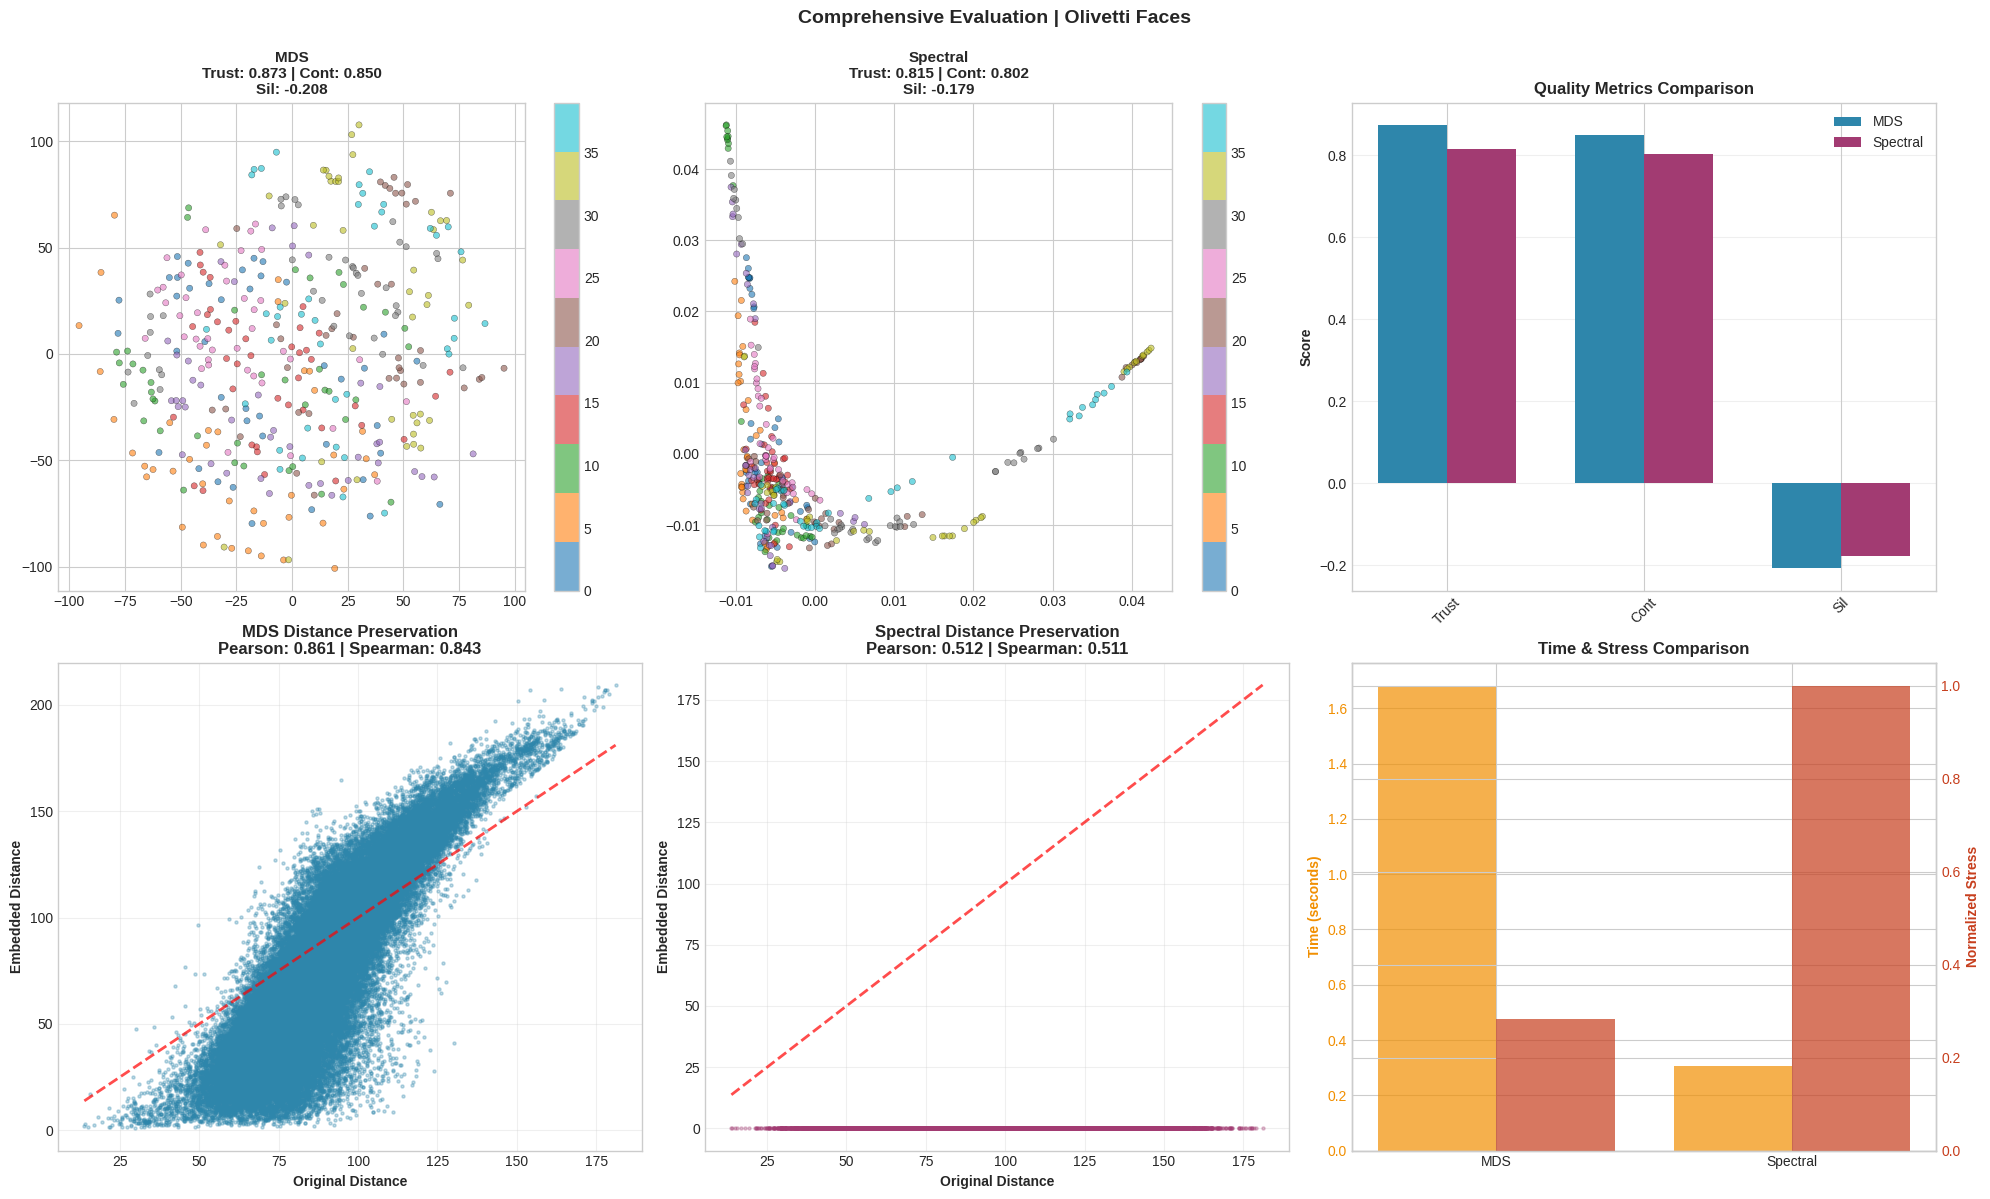


--- SUMMARY ---
MDS:
  Trust: 0.8735, Cont: 0.8499
  Stress: 0.2832, Sil: -0.20796085453276308
  Time: 1.68s

Spectral:
  Trust: 0.8153, Cont: 0.8021
  Stress: 0.9998, Sil: -0.1786370393189354
  Time: 0.30s
Loading Fashion MNIST...
--- Processing Fashion MNIST ---

COMPREHENSIVE EVALUATION
Dataset: Fashion MNIST
Shape: (5000, 784) | Samples: 5000 | Features: 784
Running MDS...
Running Spectral Embedding...


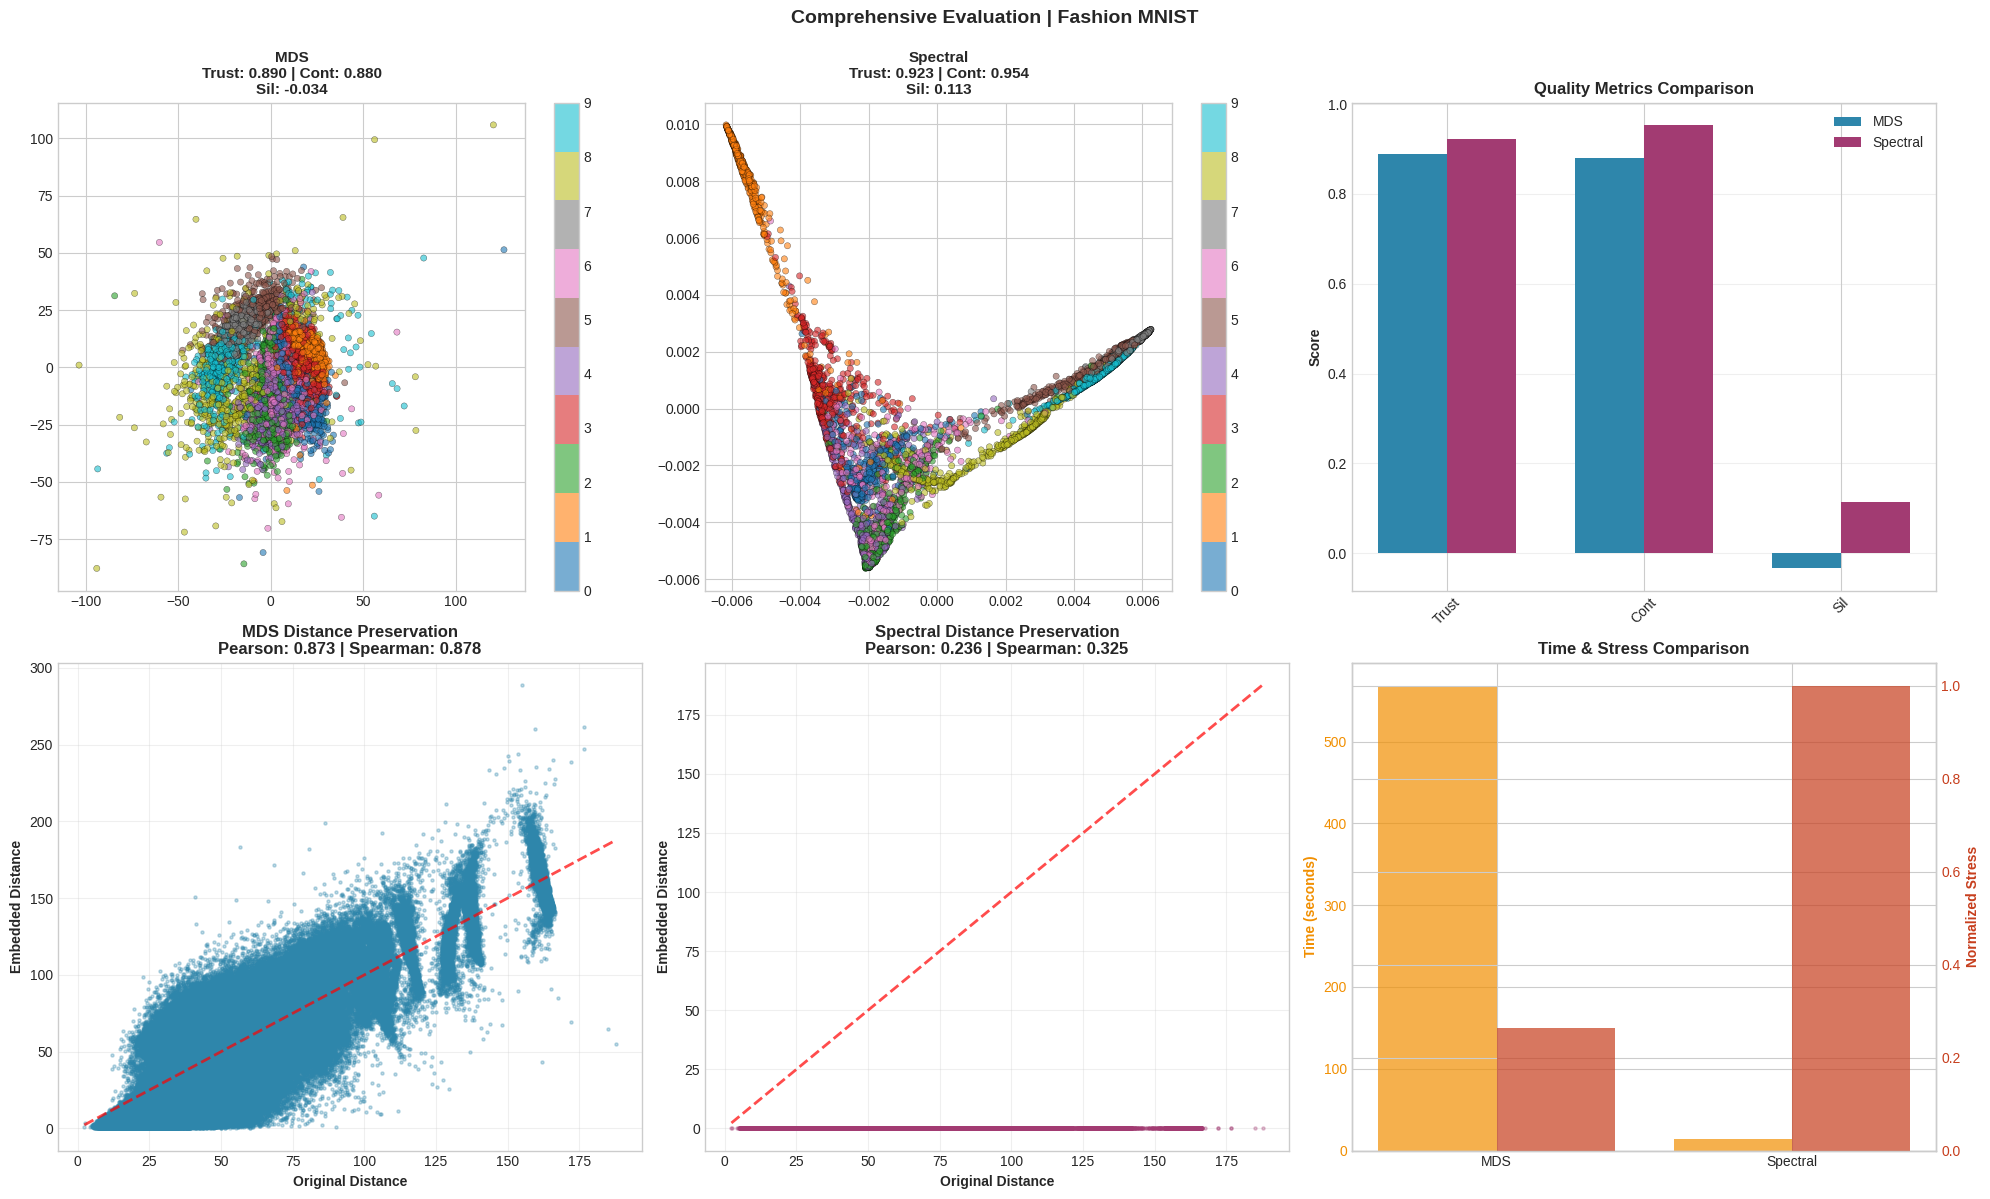


--- SUMMARY ---
MDS:
  Trust: 0.8896, Cont: 0.8805
  Stress: 0.2642, Sil: -0.03408948805057815
  Time: 567.91s

Spectral:
  Trust: 0.9229, Cont: 0.9538
  Stress: 0.9998, Sil: 0.11331062807644915
  Time: 14.15s
Loading 20 Newsgroups Dataset...
Error loading dataset: HTTP Error 403: Forbidden
Loading Covertype Dataset...
--- Processing Forest Covertype ---

COMPREHENSIVE EVALUATION
Dataset: Forest Covertype
Shape: (10000, 54) | Samples: 10000 | Features: 54
Running MDS...
Running Spectral Embedding...


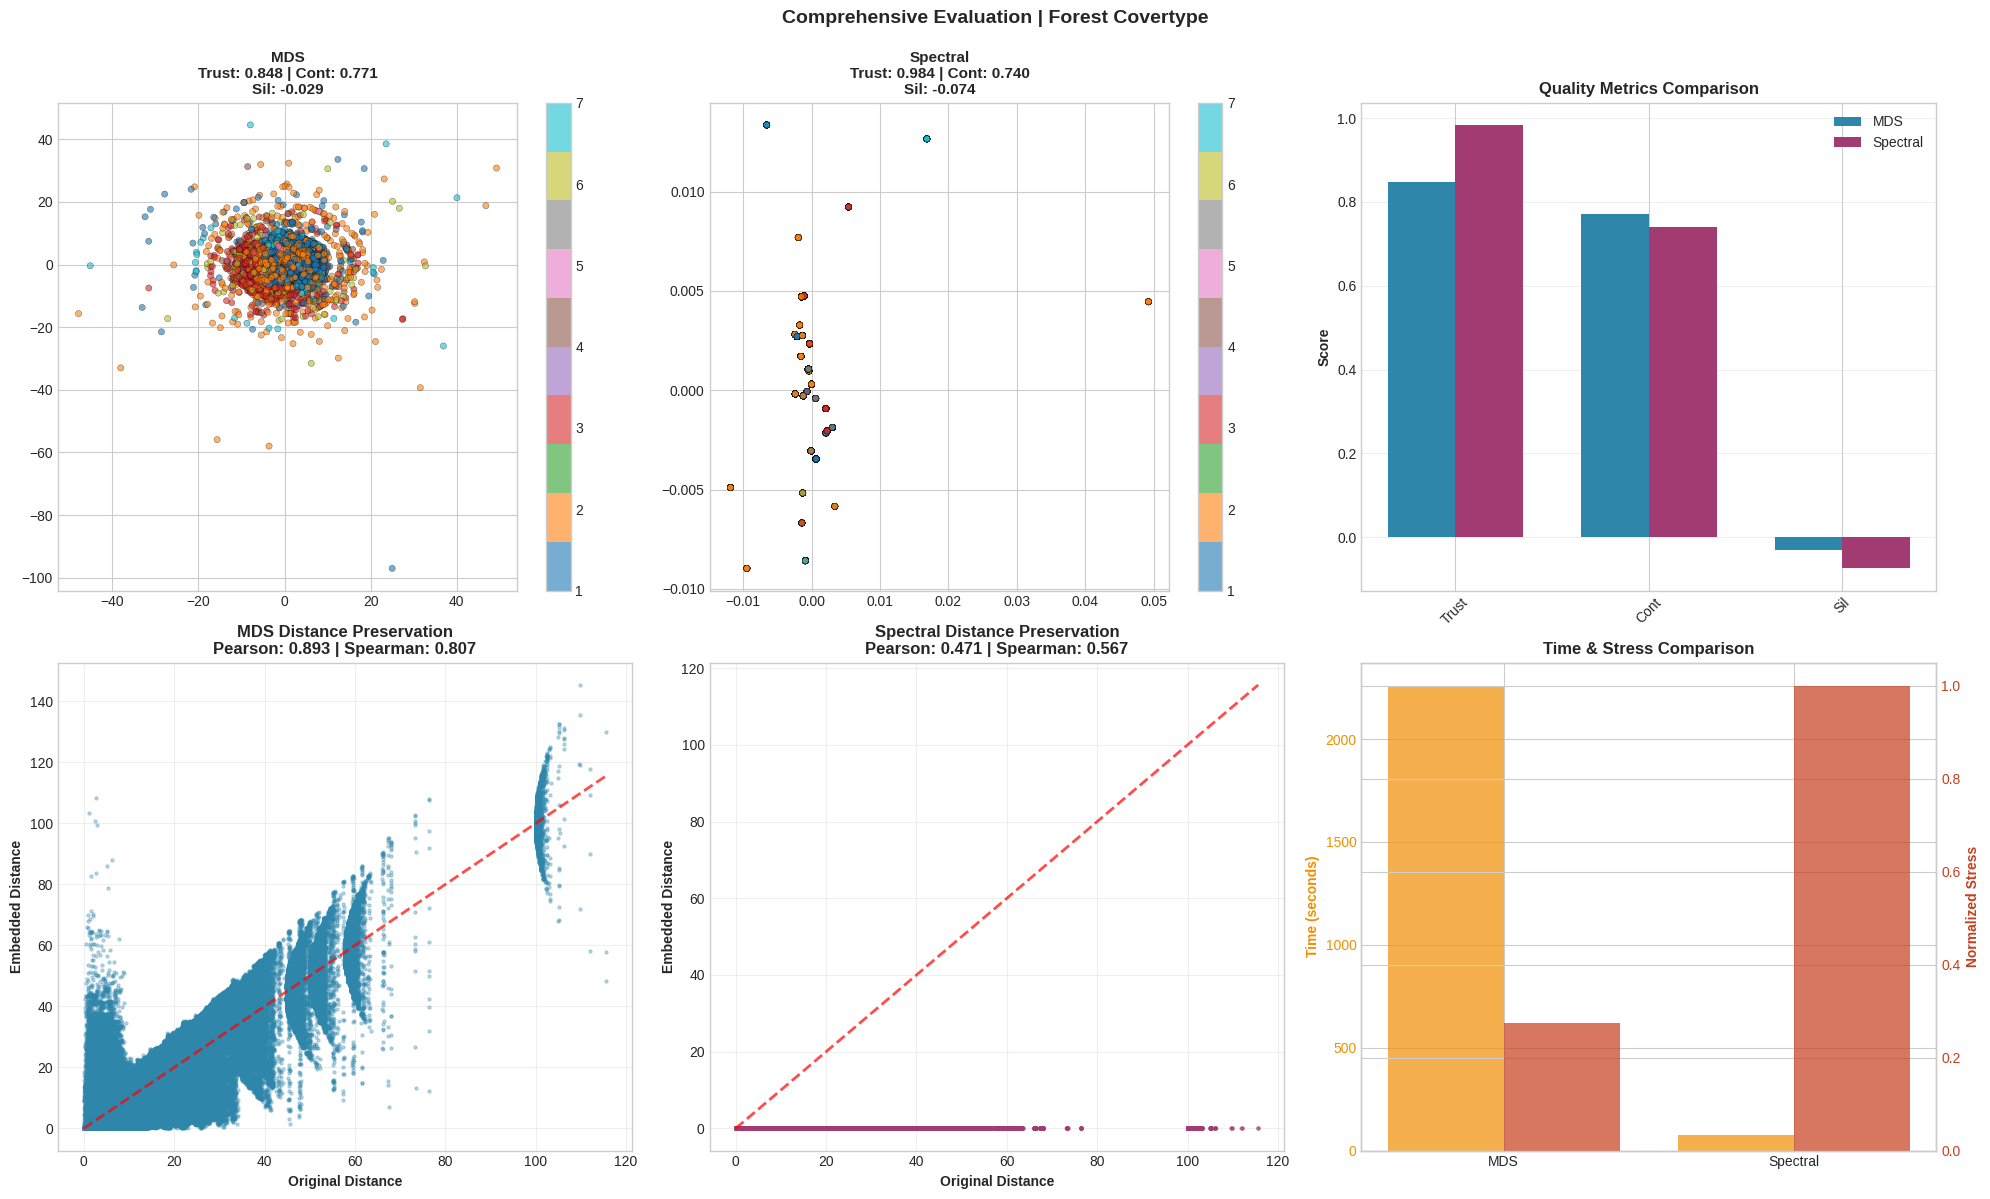


--- SUMMARY ---
MDS:
  Trust: 0.8475, Cont: 0.7711
  Stress: 0.2753, Sil: -0.029359836546093532
  Time: 2258.38s

Spectral:
  Trust: 0.9835, Cont: 0.7404
  Stress: 0.9997, Sil: -0.07436410682051343
  Time: 77.26s
Loading HAR Smartphone Dataset...
--- Processing HAR Smartphone ---

COMPREHENSIVE EVALUATION
Dataset: HAR Smartphone
Shape: (10000, 561) | Samples: 10000 | Features: 561
Running MDS...
Running Spectral Embedding...


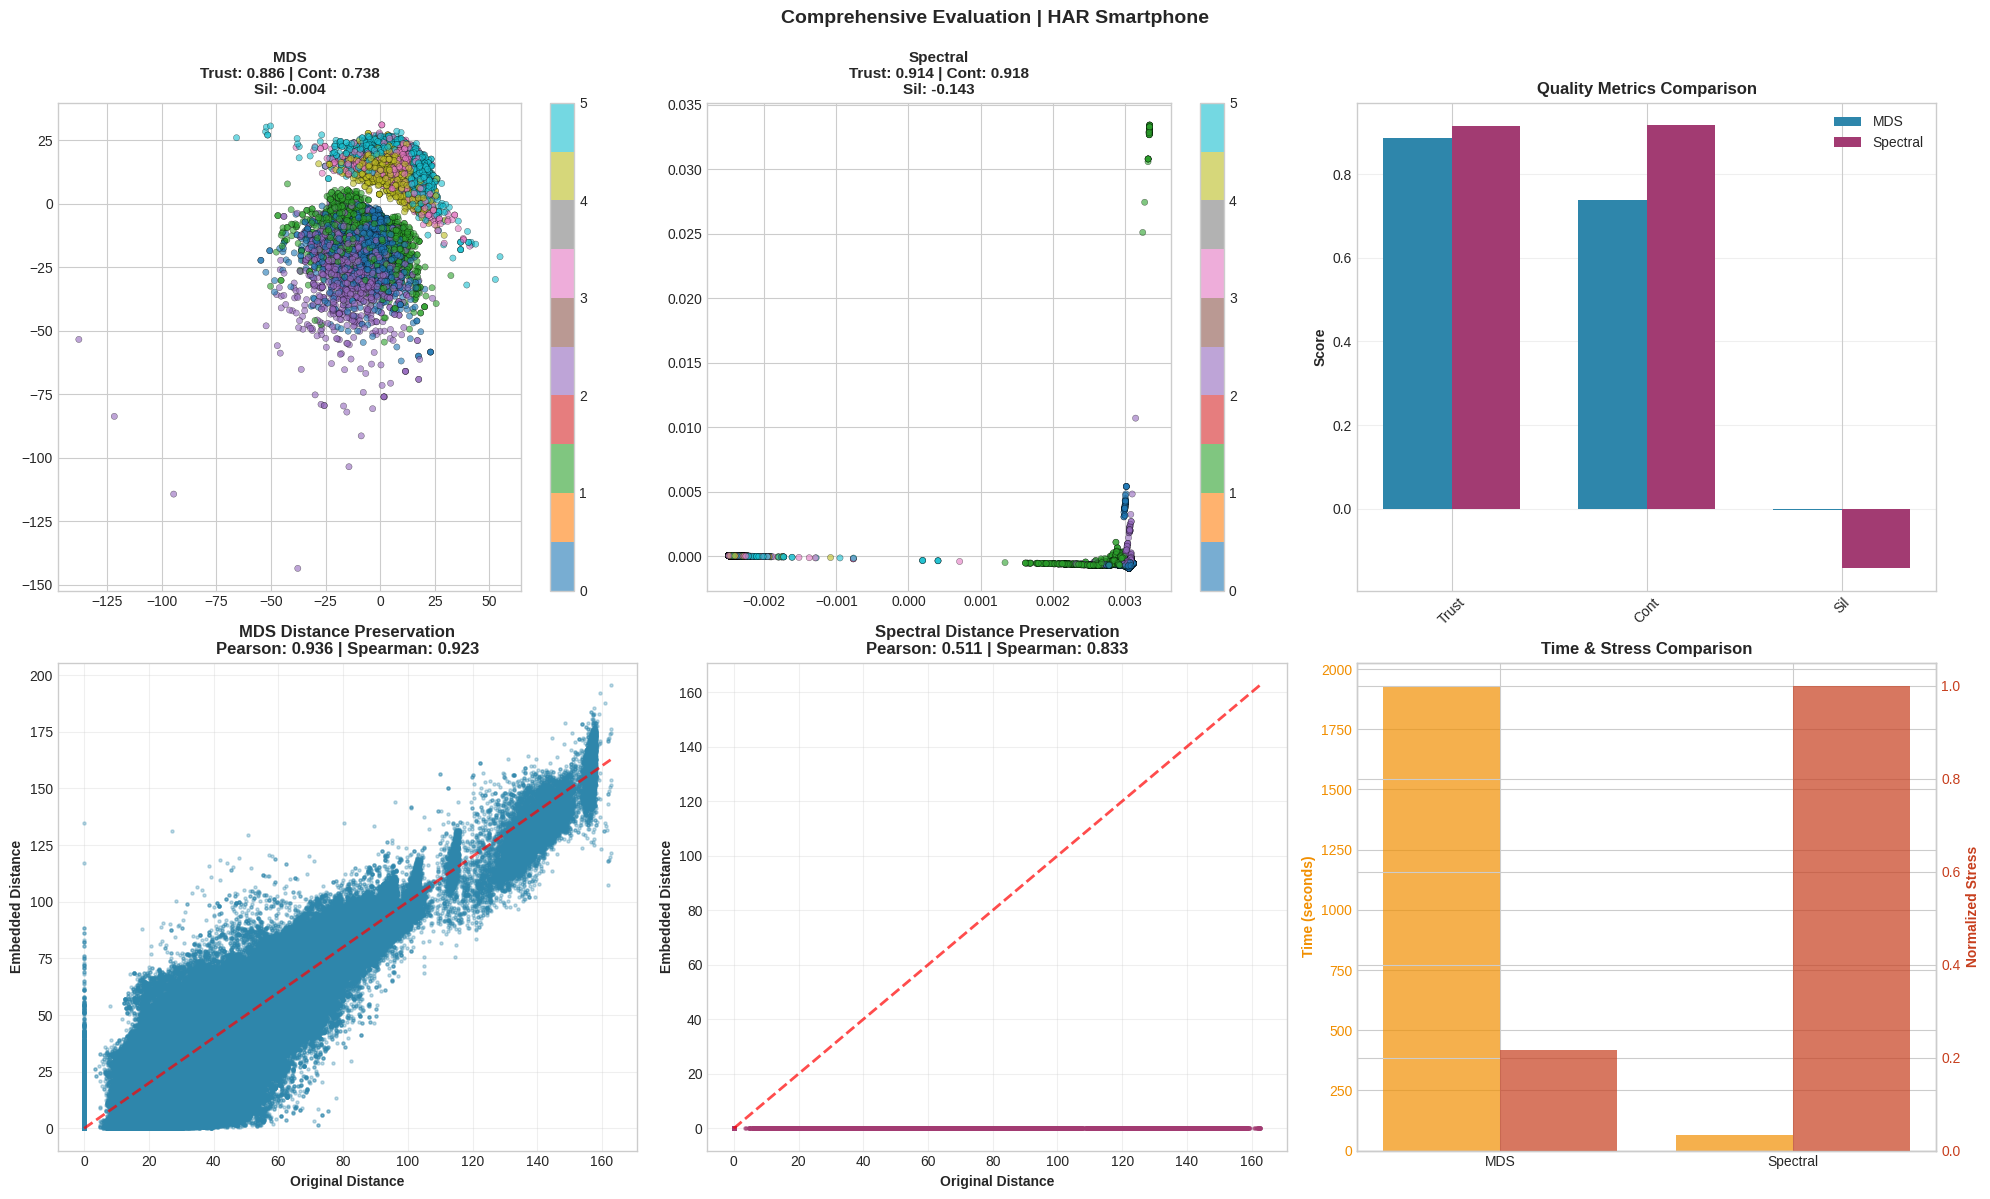


--- SUMMARY ---
MDS:
  Trust: 0.8857, Cont: 0.7381
  Stress: 0.2166, Sil: -0.003627760316995616
  Time: 1929.69s

Spectral:
  Trust: 0.9142, Cont: 0.9177
  Stress: 0.9999, Sil: -0.14283830151561772
  Time: 62.83s
Loading Spambase Dataset...
--- Processing Spambase ---

COMPREHENSIVE EVALUATION
Dataset: Spambase
Shape: (4601, 57) | Samples: 4601 | Features: 57
Running MDS...
Running Spectral Embedding...


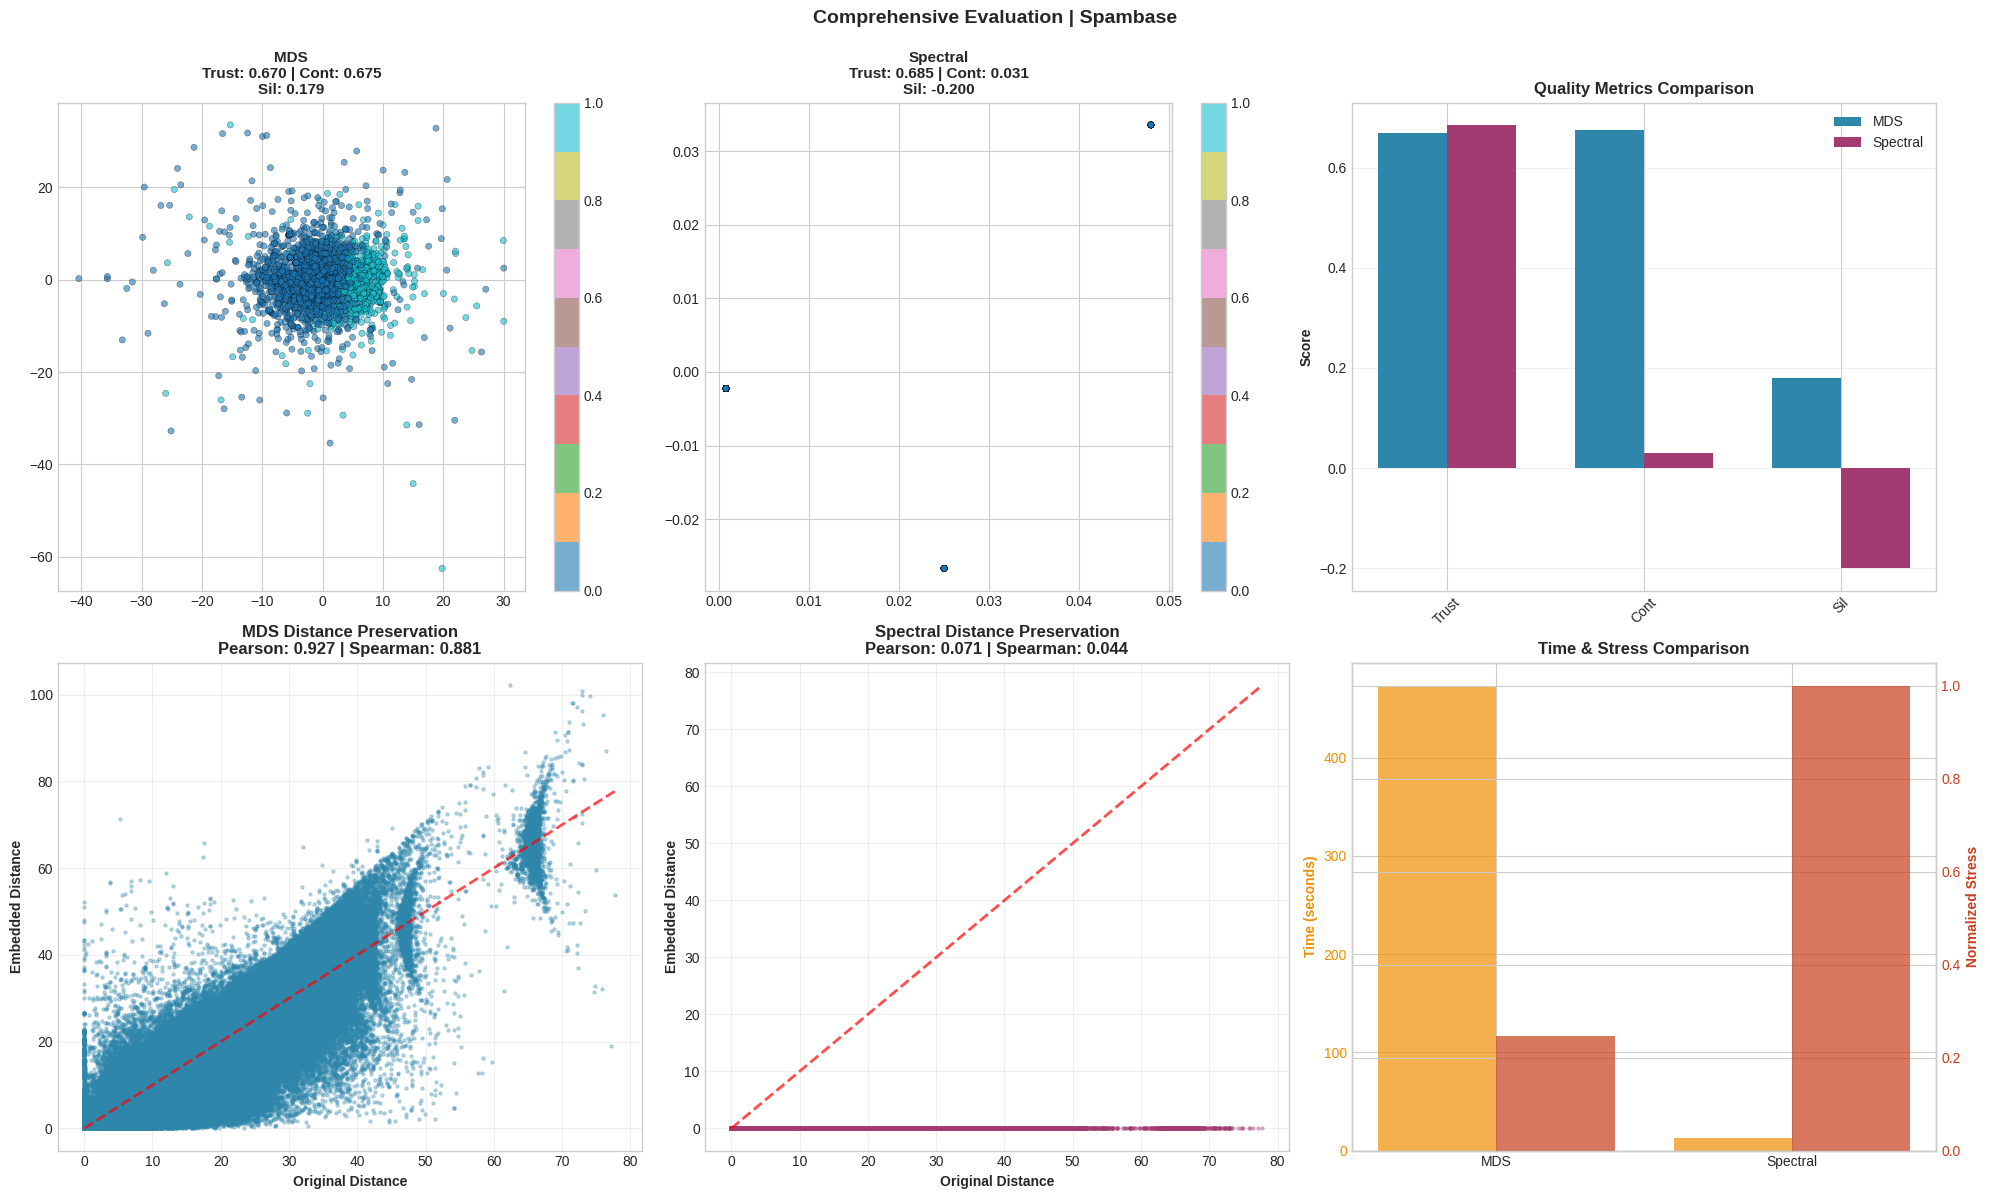


--- SUMMARY ---
MDS:
  Trust: 0.6697, Cont: 0.6748
  Stress: 0.2460, Sil: 0.1794762950897497
  Time: 472.95s

Spectral:
  Trust: 0.6851, Cont: 0.0307
  Stress: 0.9999, Sil: -0.19988664969680484
  Time: 12.38s

BẢNG TỔNG HỢP KẾT QUẢ ĐÁNH GIÁ TOÀN DIỆN



In [72]:
datasets = [
    load_olivetti_faces,
    load_fashion_mnist, 
    load_20newsgroups_tfidf,
    load_covertype,
    load_har_smartphone,
    load_spam_dataset,
]

print("\n" + "="*80)
print("PART 1: COMPREHENSIVE COMPARISON WITH ENHANCED METRICS")
print("="*80)

# Main comparison results
all_results = []

for loader in datasets:
    try:
        X, y, name = loader()
        if X is None: 
            continue
        print(f"--- Processing {name} ---")
        result = compare_algorithms(X, y, name)
        all_results.append(result)
    except Exception as e:
        print(f"Error loading dataset: {e}")
        continue

df_results = pd.DataFrame(all_results)

print("\n" + "="*80)
print("BẢNG TỔNG HỢP KẾT QUẢ ĐÁNH GIÁ TOÀN DIỆN")
print("="*80 + "\n")

def highlight_best_comprehensive(data):
    styles = pd.DataFrame('', index=data.index, columns=data.columns)
    
    for idx in data.index:
        # Trustworthiness & Continuity: higher is better
        for metric in ['Trust', 'Cont']:
            mds_col = f'MDS_{metric}'
            spec_col = f'Spectral_{metric}'
            if data.loc[idx, mds_col] > data.loc[idx, spec_col]:
                styles.loc[idx, mds_col] = 'color: green; font-weight: bold'
            else:
                styles.loc[idx, spec_col] = 'color: green; font-weight: bold'
        
        # Stress & Time: lower is better
        for metric in ['Stress', 'Time']:
            mds_col = f'MDS_{metric}'
            spec_col = f'Spectral_{metric}'
            if data.loc[idx, mds_col] < data.loc[idx, spec_col]:
                styles.loc[idx, mds_col] = 'color: green; font-weight: bold'
            else:
                styles.loc[idx, spec_col] = 'color: green; font-weight: bold'
        
        # Silhouette: higher is better
        if pd.notna(data.loc[idx, 'MDS_Sil']) and pd.notna(data.loc[idx, 'Spectral_Sil']):
            if data.loc[idx, 'MDS_Sil'] > data.loc[idx, 'Spectral_Sil']:
                styles.loc[idx, 'MDS_Sil'] = 'color: green; font-weight: bold'
            else:
                styles.loc[idx, 'Spectral_Sil'] = 'color: green; font-weight: bold'
    
    return styles

styled = df_results.style.format({
    'MDS_Trust': '{:.4f}',
    'MDS_Cont': '{:.4f}',
    'MDS_Stress': '{:.4f}',
    'MDS_Sil': '{:.4f}',
    'MDS_Time': '{:.2f}',
    'Spectral_Trust': '{:.4f}',
    'Spectral_Cont': '{:.4f}',
    'Spectral_Stress': '{:.4f}',
    'Spectral_Sil': '{:.4f}',
    'Spectral_Time': '{:.2f}'
}).apply(highlight_best_comprehensive, axis=None)

display(styled)

>>> Loading Datasets...
Loading Fashion MNIST...
Loading Olivetti Faces...
Loading Covertype Dataset...
Loading HAR Smartphone Dataset...

----------------------------------------
GROUP 1: MDS PARAMETERS ANALYSIS


>>> 1.1. Ablation: MDS Initialization Methods (Olivetti Faces)

ABLATION STUDY 1: MDS Initialization Methods
Dataset: Olivetti Faces

Testing n_init=1...
Testing n_init=4...
Testing n_init=10...


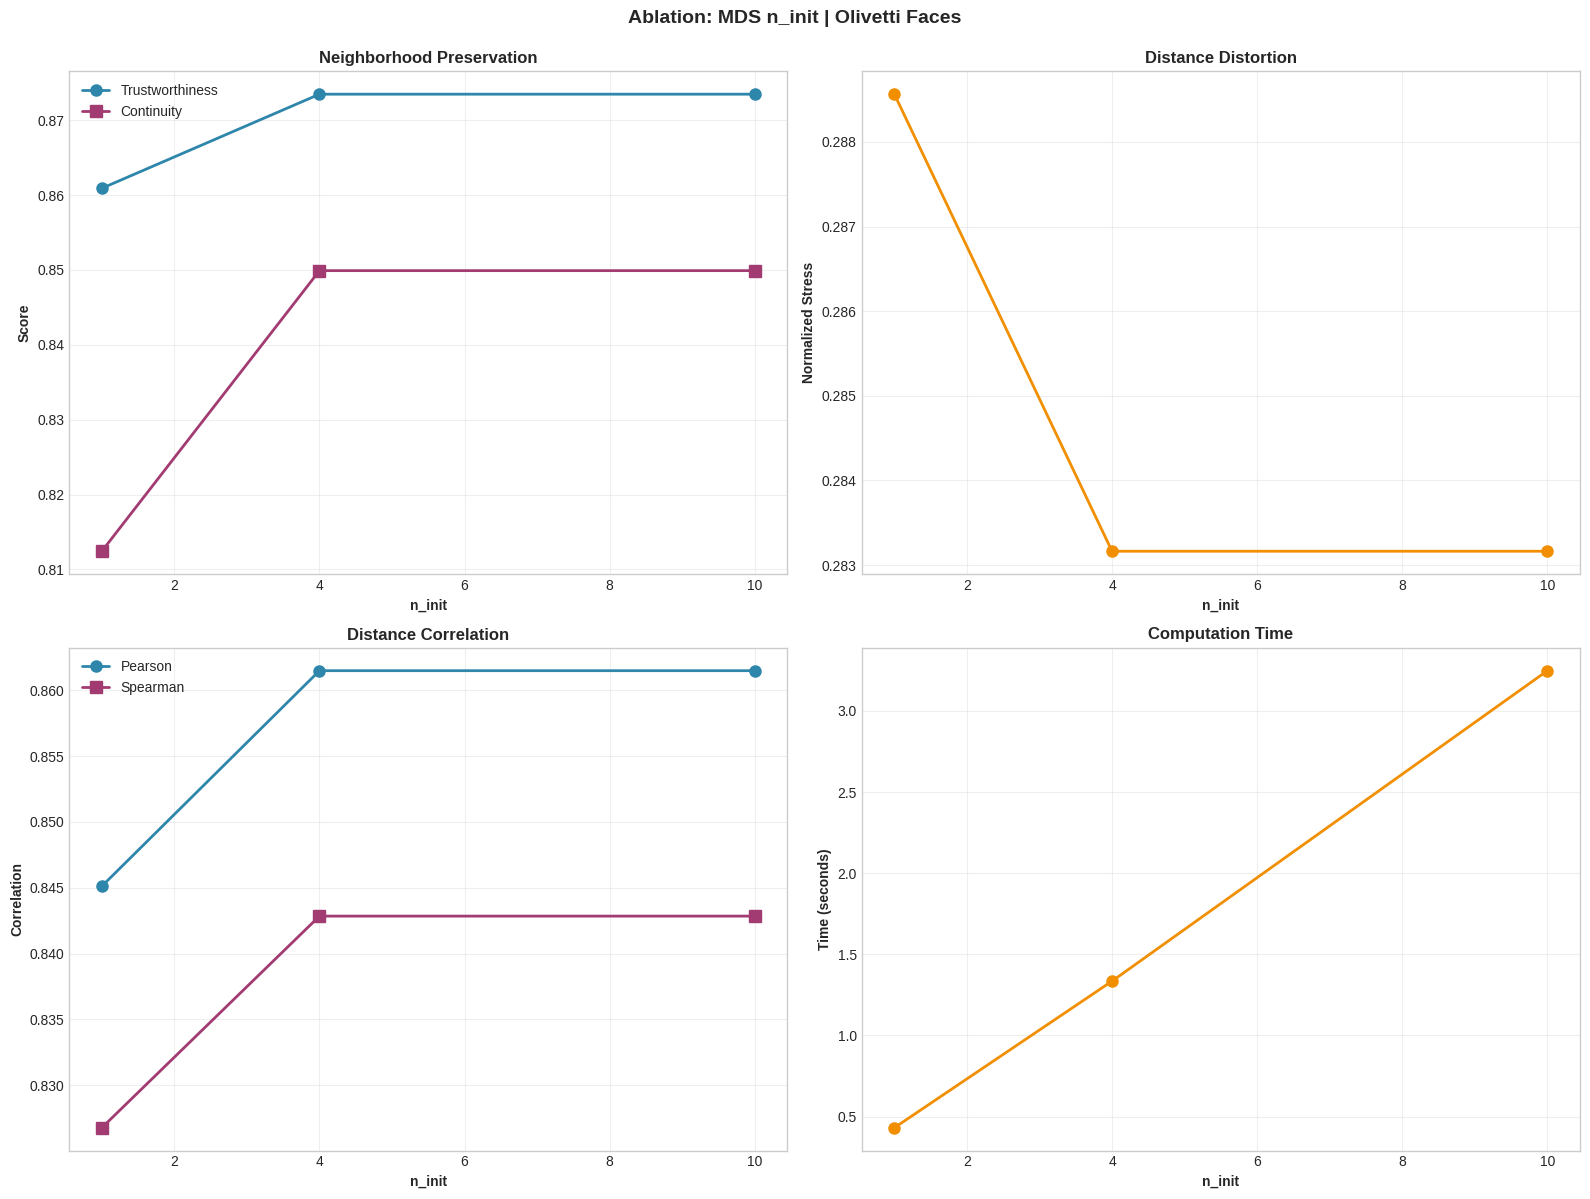


Results Table:
 trustworthiness  continuity   stress  distance_correlation  spearman_correlation  silhouette     time  n_init
        0.860910     0.81243 0.288563              0.845114              0.826780   -0.212916 0.430990       1
        0.873482     0.84991 0.283164              0.861477              0.842846   -0.207961 1.334688       4
        0.873482     0.84991 0.283164              0.861477              0.842846   -0.207961 3.248247      10

>>> 1.2. Ablation: MDS Convergence (max_iter) (Olivetti Faces)

ABLATION STUDY 3: MDS max_iter (Convergence)
Dataset: Olivetti Faces

Testing max_iter=50...
Testing max_iter=100...
Testing max_iter=200...
Testing max_iter=300...
Testing max_iter=500...


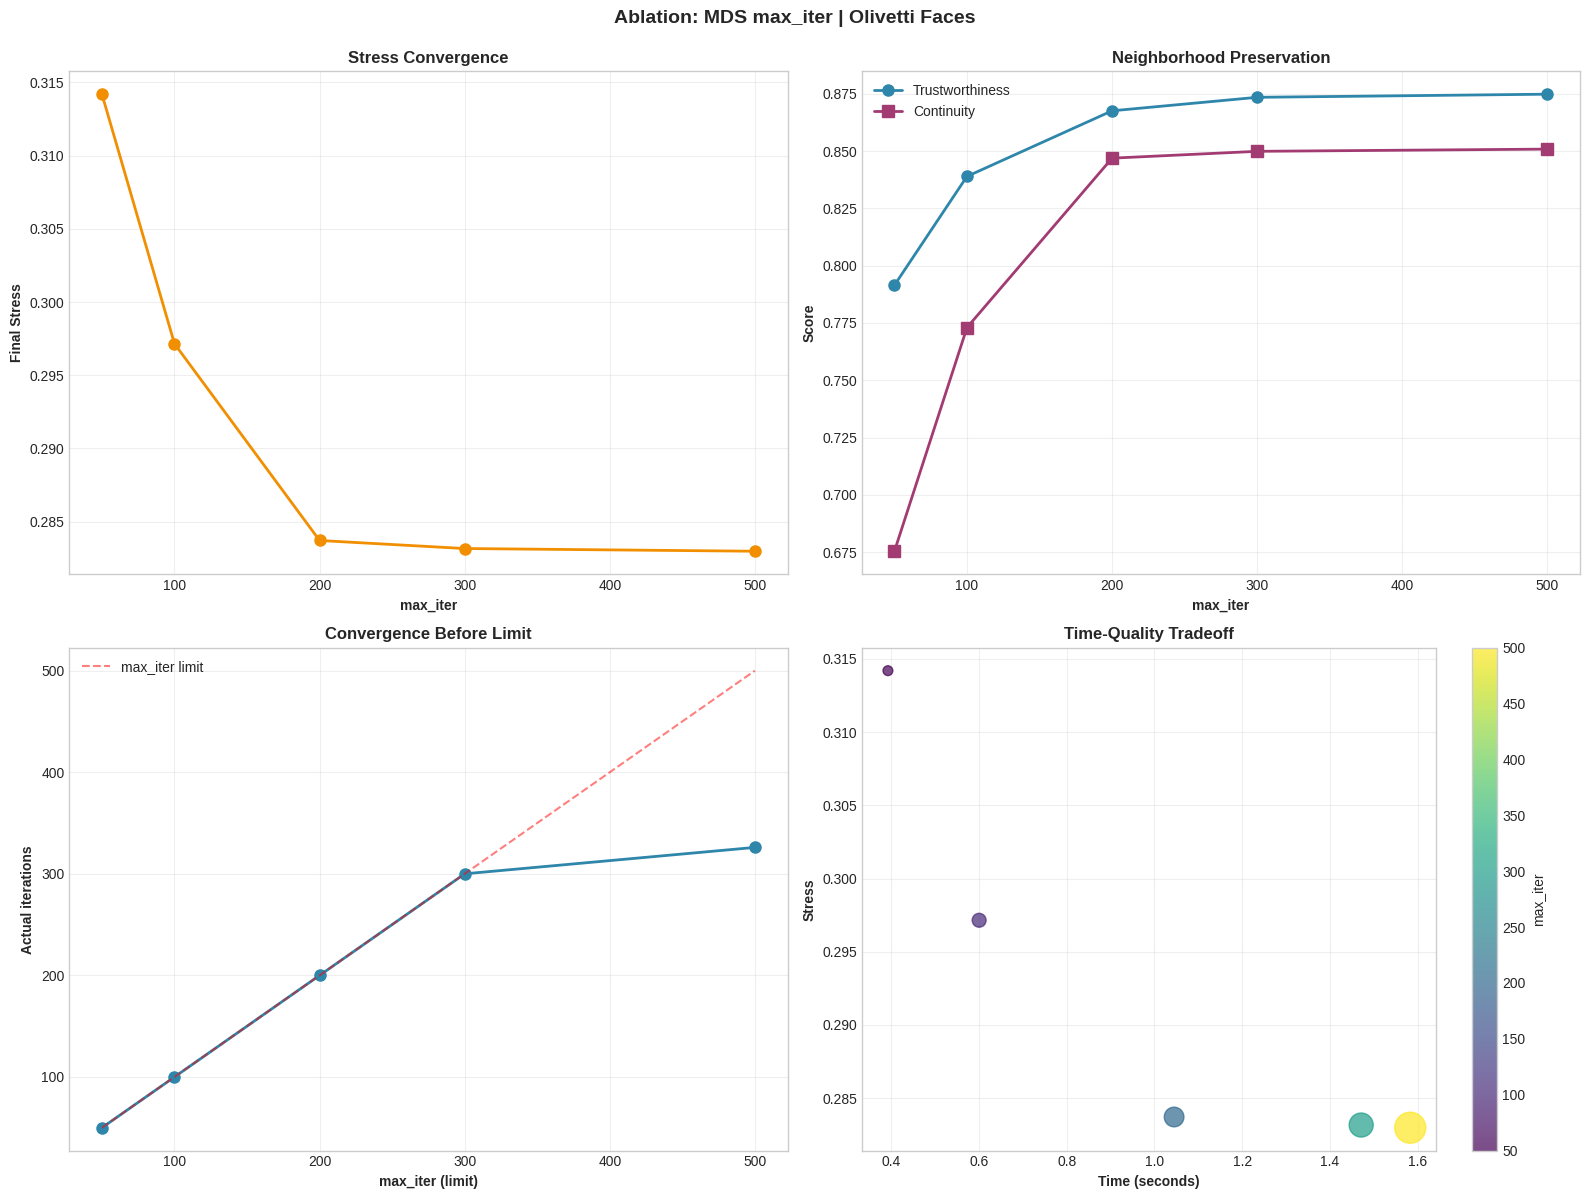


Results Table:
 trustworthiness  continuity   stress  distance_correlation  spearman_correlation  silhouette     time  max_iter  n_iter
        0.791486    0.675387 0.314194              0.766638              0.737279   -0.262141 0.392884        50      50
        0.838971    0.773010 0.297149              0.819668              0.797719   -0.223854 0.600675       100     100
        0.867596    0.846928 0.283714              0.859990              0.841258   -0.211858 1.044799       200     200
        0.873482    0.849910 0.283164              0.861477              0.842846   -0.207961 1.470951       300     300
        0.874848    0.850877 0.282980              0.862027              0.843404   -0.206650 1.582686       500     326

>>> 1.3. Ablation: Metric vs Non-Metric MDS (Olivetti Faces)

ABLATION 1: Metric vs Non-Metric MDS (ENHANCED)
Dataset: Olivetti Faces

Running Metric MDS...
Running Non-Metric MDS...

Metric                         Metric MDS           Non-Metric MDS       

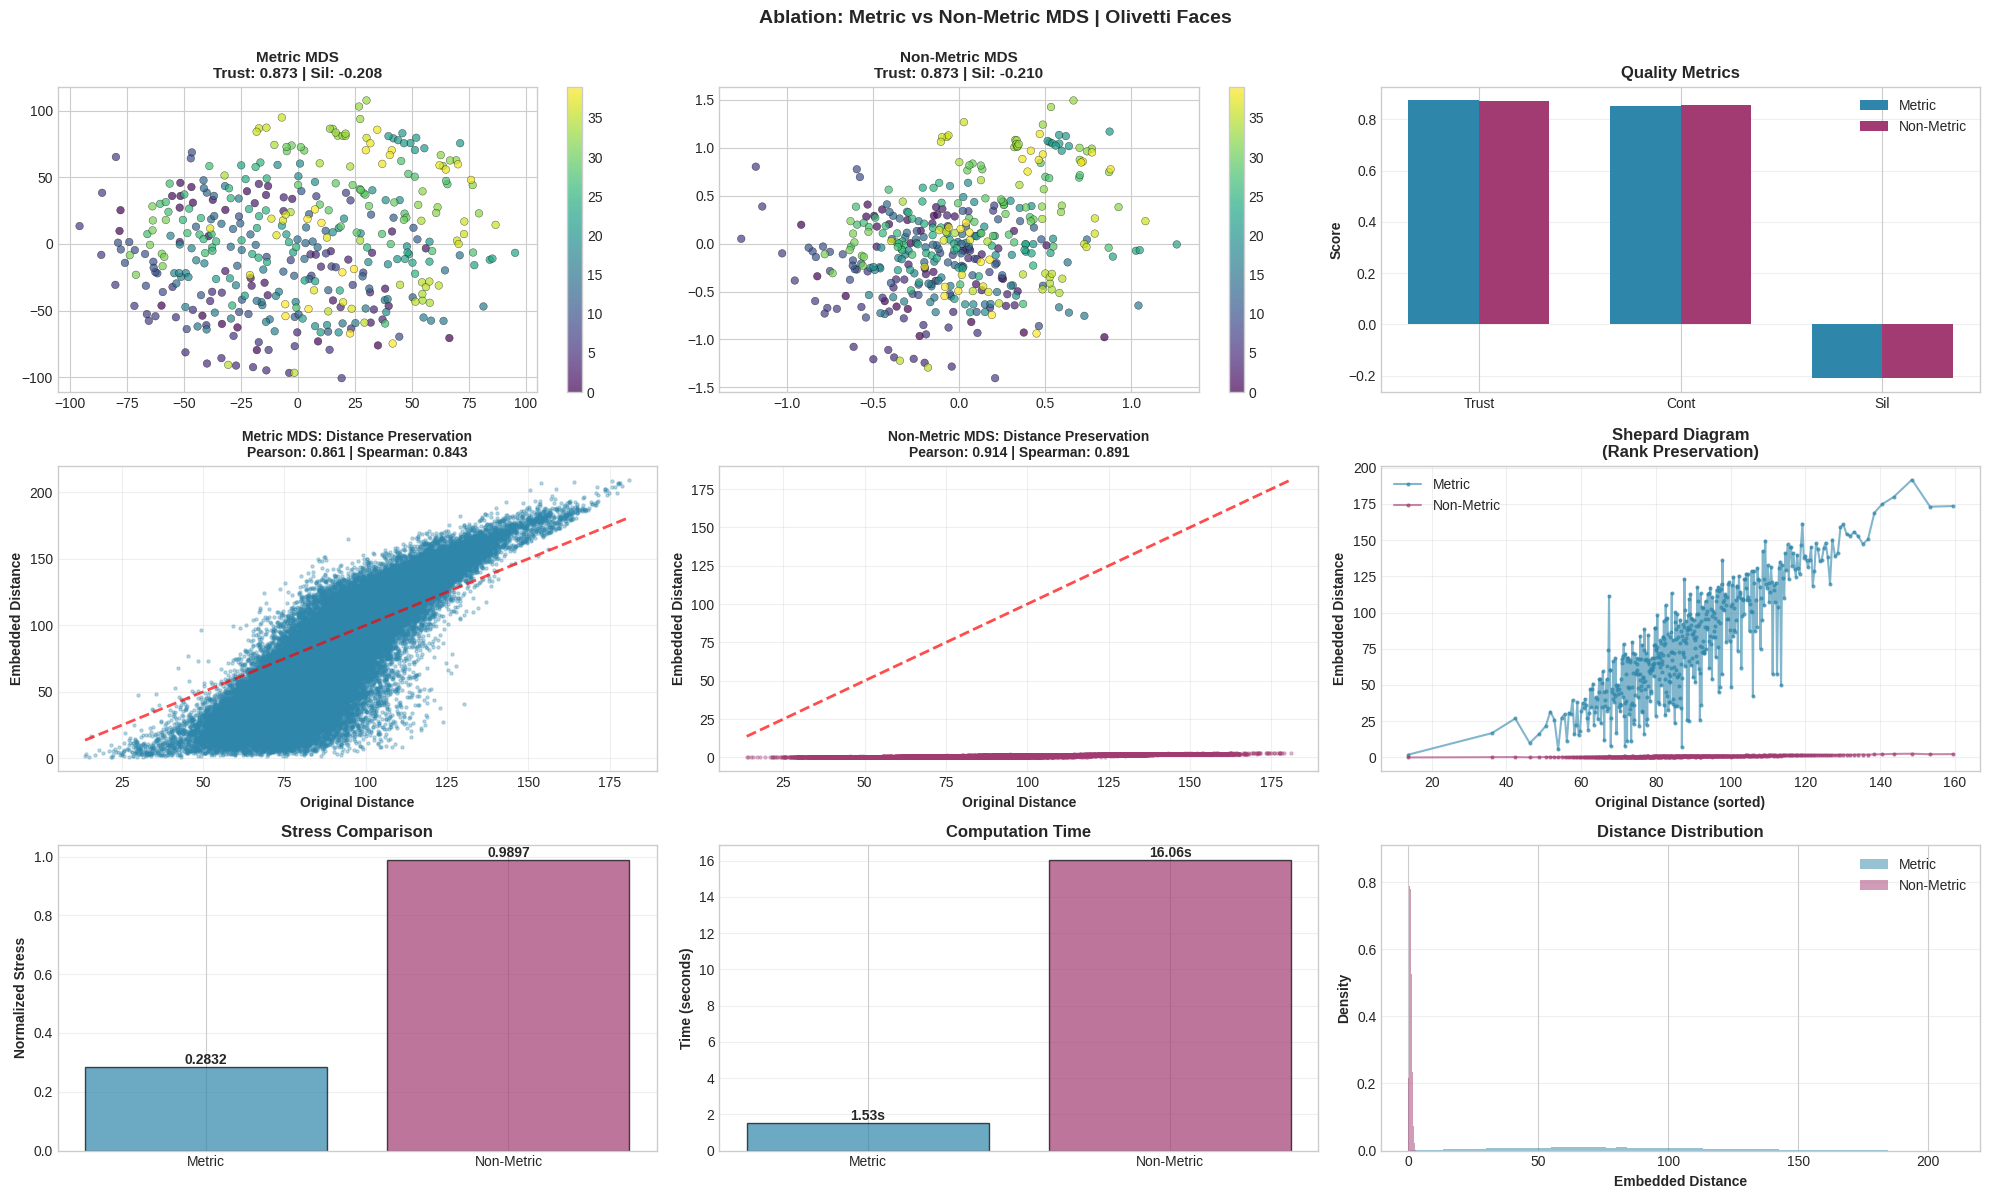


>>> 1.4. Ablation: MDS Dissimilarity Metrics (Olivetti Faces)

ABLATION 4: MDS Dissimilarity Metrics (NEW)
Dataset: Olivetti Faces

Computing dissimilarity matrices...
Running MDS with Euclidean distance...
Running MDS with Manhattan distance...
Running MDS with Cosine distance...

Metric                    Euclidean       Manhattan       Cosine         
----------------------------------------------------------------------
trustworthiness           0.8735          0.8758          0.8611         
continuity                0.8499          0.8490          0.8036         
stress                    0.2832          49.5741         0.9896         
silhouette                -0.2080         -0.1982         -0.2761        
time                      1.6269          1.0697          0.8195         


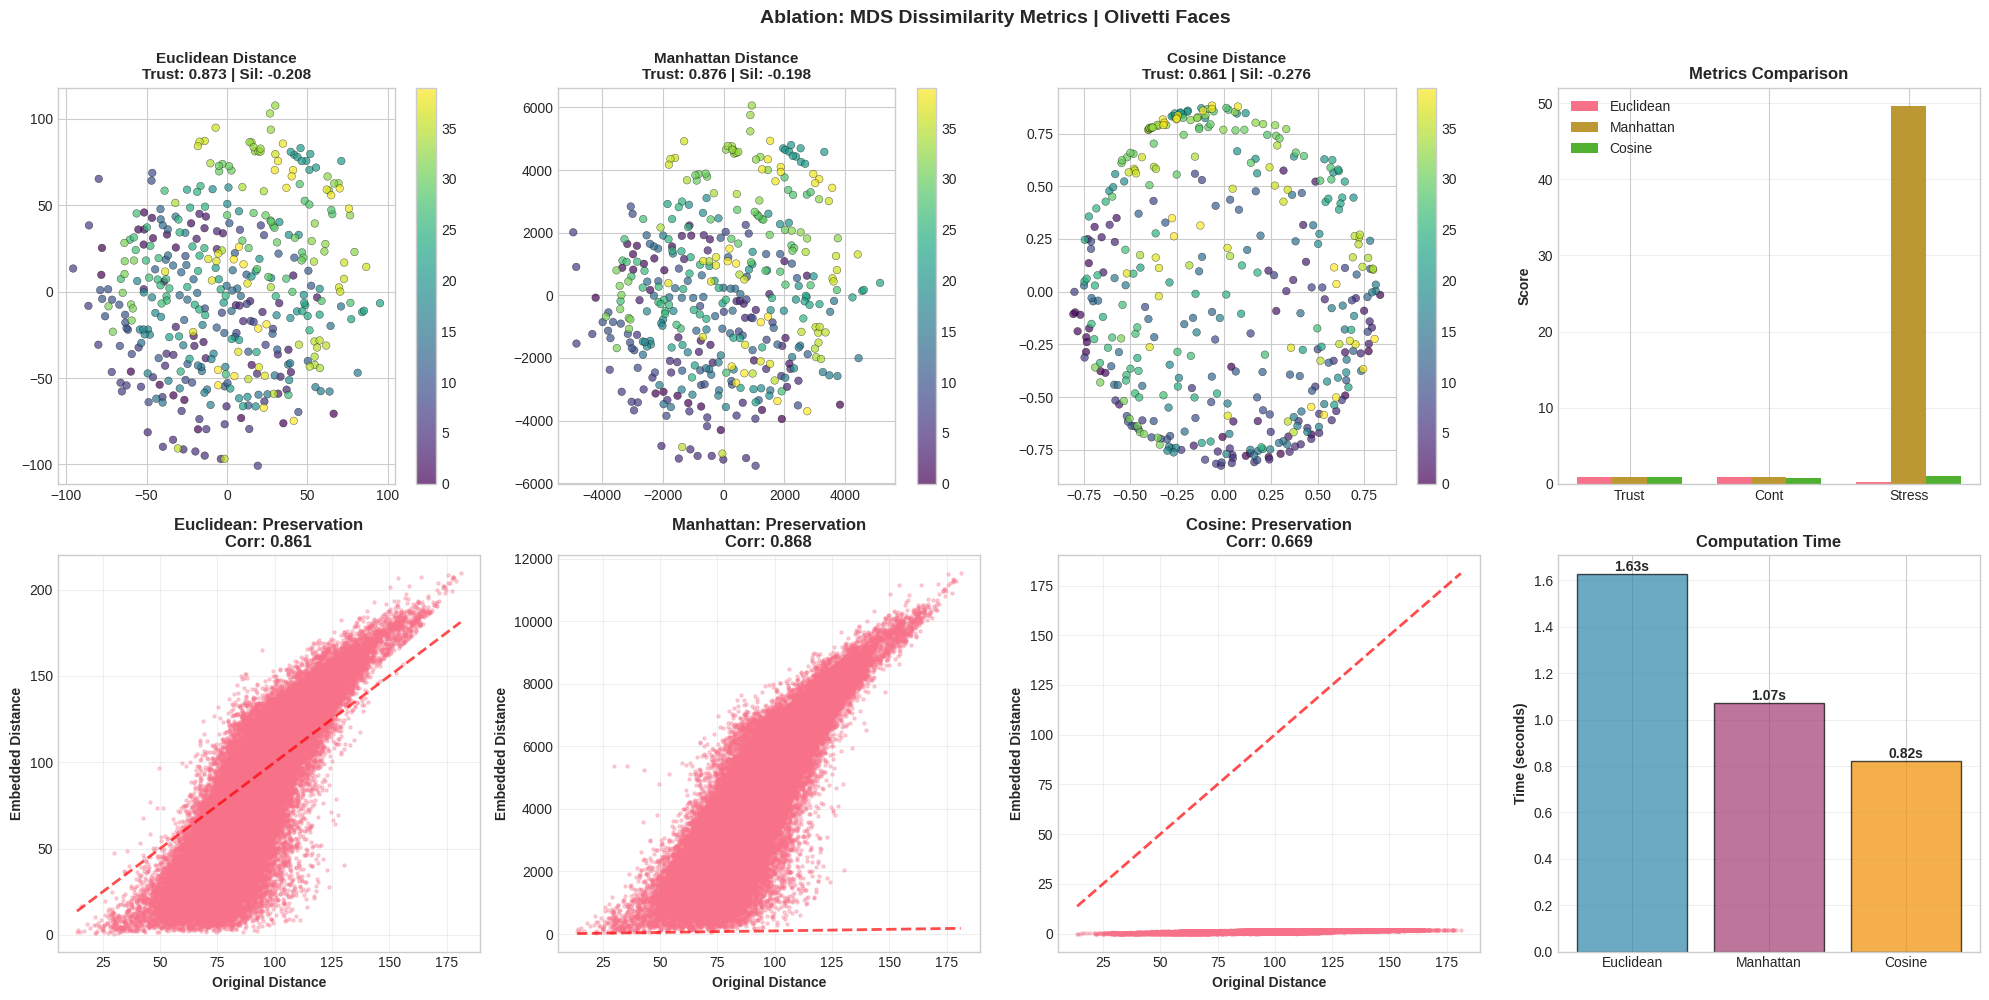


Results Table:
 trustworthiness  continuity    stress  distance_correlation  spearman_correlation  silhouette     time    method
        0.873482    0.849910  0.283164              0.861477              0.842846   -0.207961 1.626878 Euclidean
        0.875845    0.849015 49.574149              0.868499              0.846528   -0.198192 1.069731 Manhattan
        0.861097    0.803644  0.989601              0.668742              0.659472   -0.276100 0.819505    Cosine

----------------------------------------
GROUP 2: SPECTRAL EMBEDDING ANALYSIS


>>> 2.1. Ablation: Spectral RBF Gamma Parameter (Fashion MNIST)

ABLATION STUDY 2: Spectral Embedding RBF Gamma
Dataset: Fashion MNIST (Subset 2k)

Testing gamma=0.01...
Testing gamma=0.1...
Testing gamma=0.5...
Testing gamma=1.0...
Testing gamma=2.0...
Testing gamma=5.0...


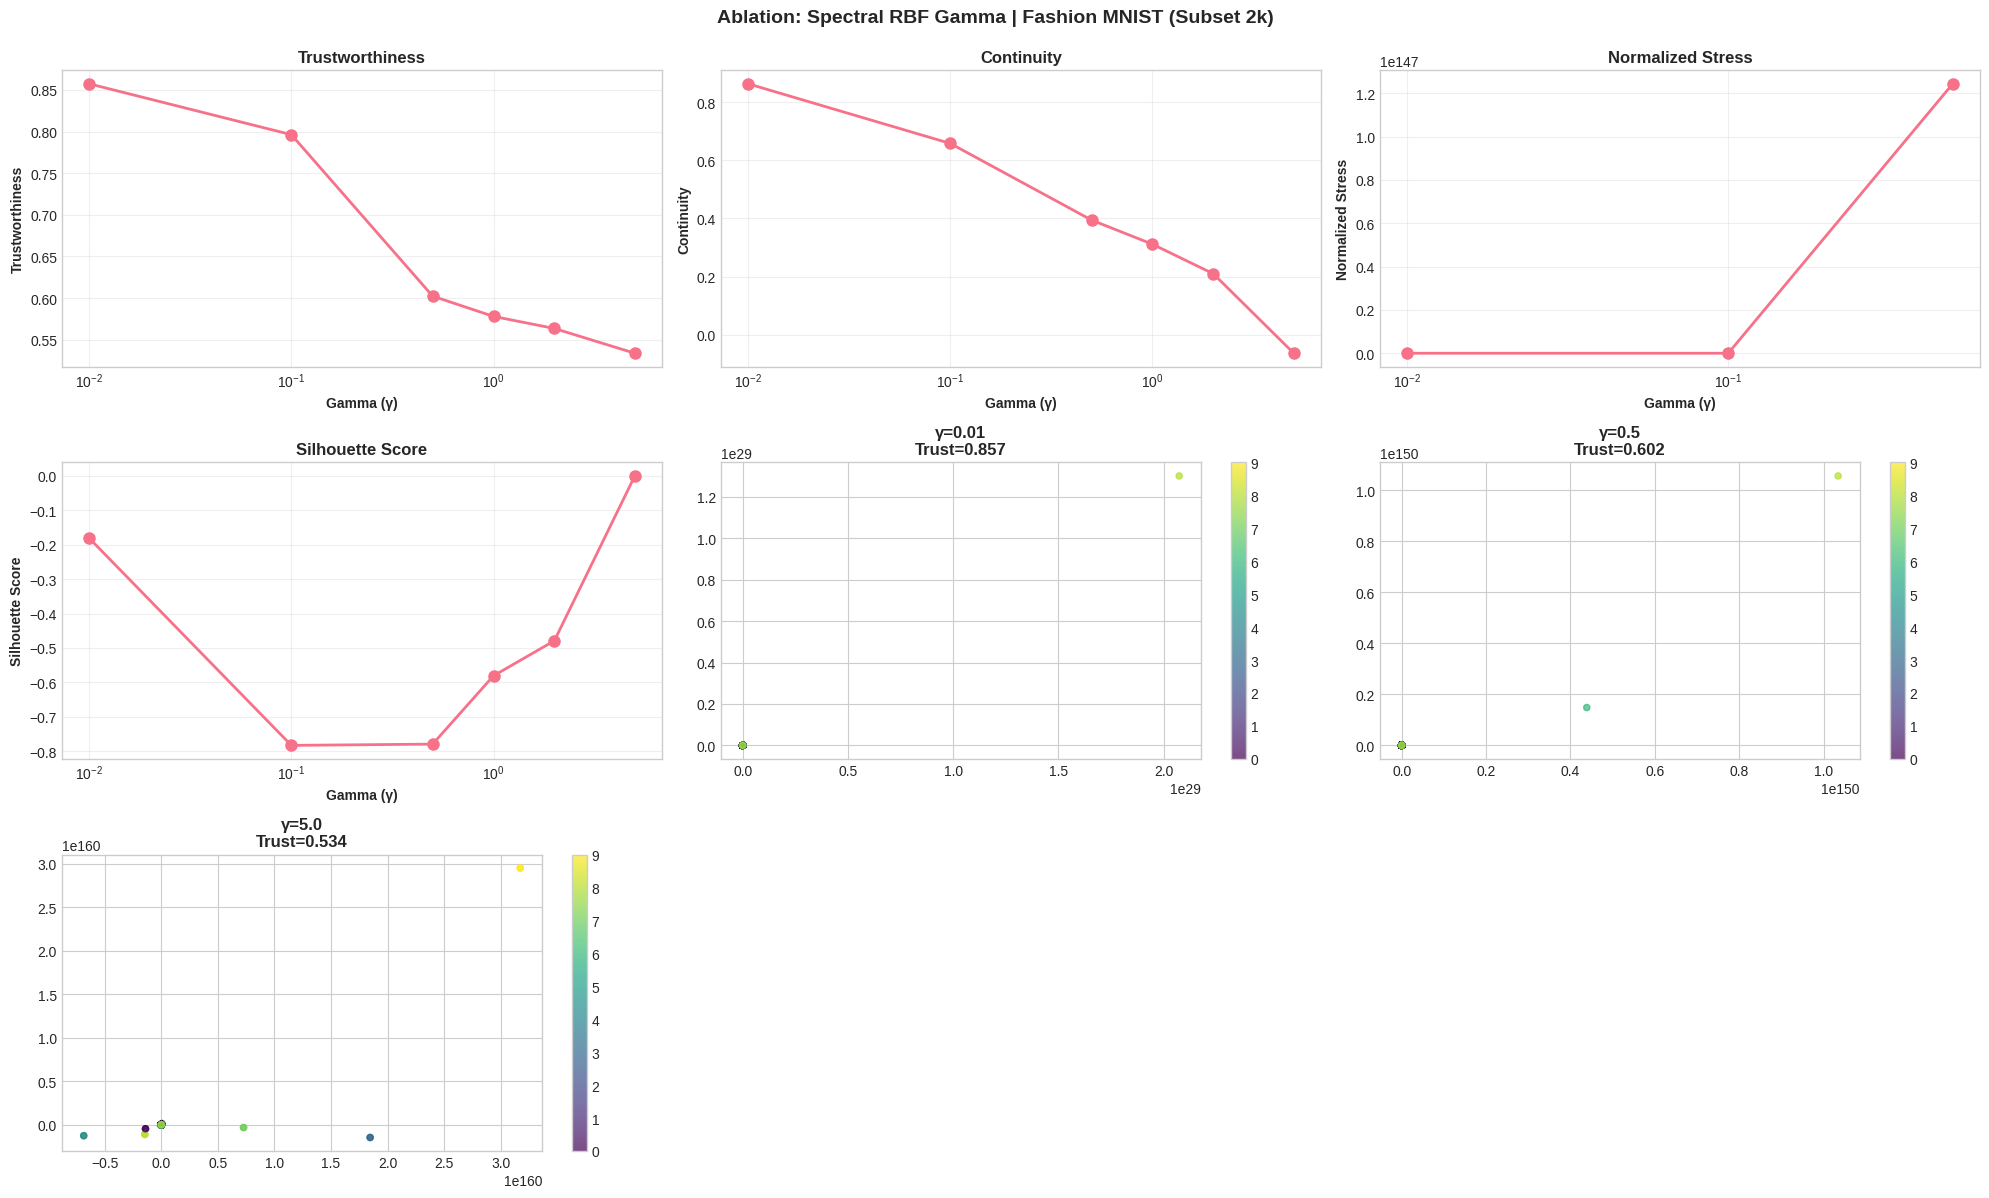


Results Table:
 trustworthiness  continuity        stress  distance_correlation  spearman_correlation  silhouette       time  gamma
        0.857378    0.864058  1.966394e+26              0.343293              0.678314   -0.180883   2.368958   0.01
        0.796288    0.658501 1.759188e+141              0.151045              0.612926   -0.783133 414.794898   0.10
        0.602416    0.394344 1.243304e+147              0.047934              0.486847   -0.779501 474.960792   0.50
        0.578074    0.311316           NaN                   NaN                   NaN   -0.580869 585.523388   1.00
        0.563580    0.209468           NaN                   NaN                   NaN   -0.479062 586.642372   2.00
        0.533828   -0.064416           NaN                   NaN                   NaN    0.000000 546.308099   5.00

>>> 2.2. Ablation: Spectral Adaptive k (Data Density) (Forest Covertype)

ABLATION STUDY 4: Spectral Adaptive k (Data Density)
Dataset: Forest Covertype (Subset 2k)

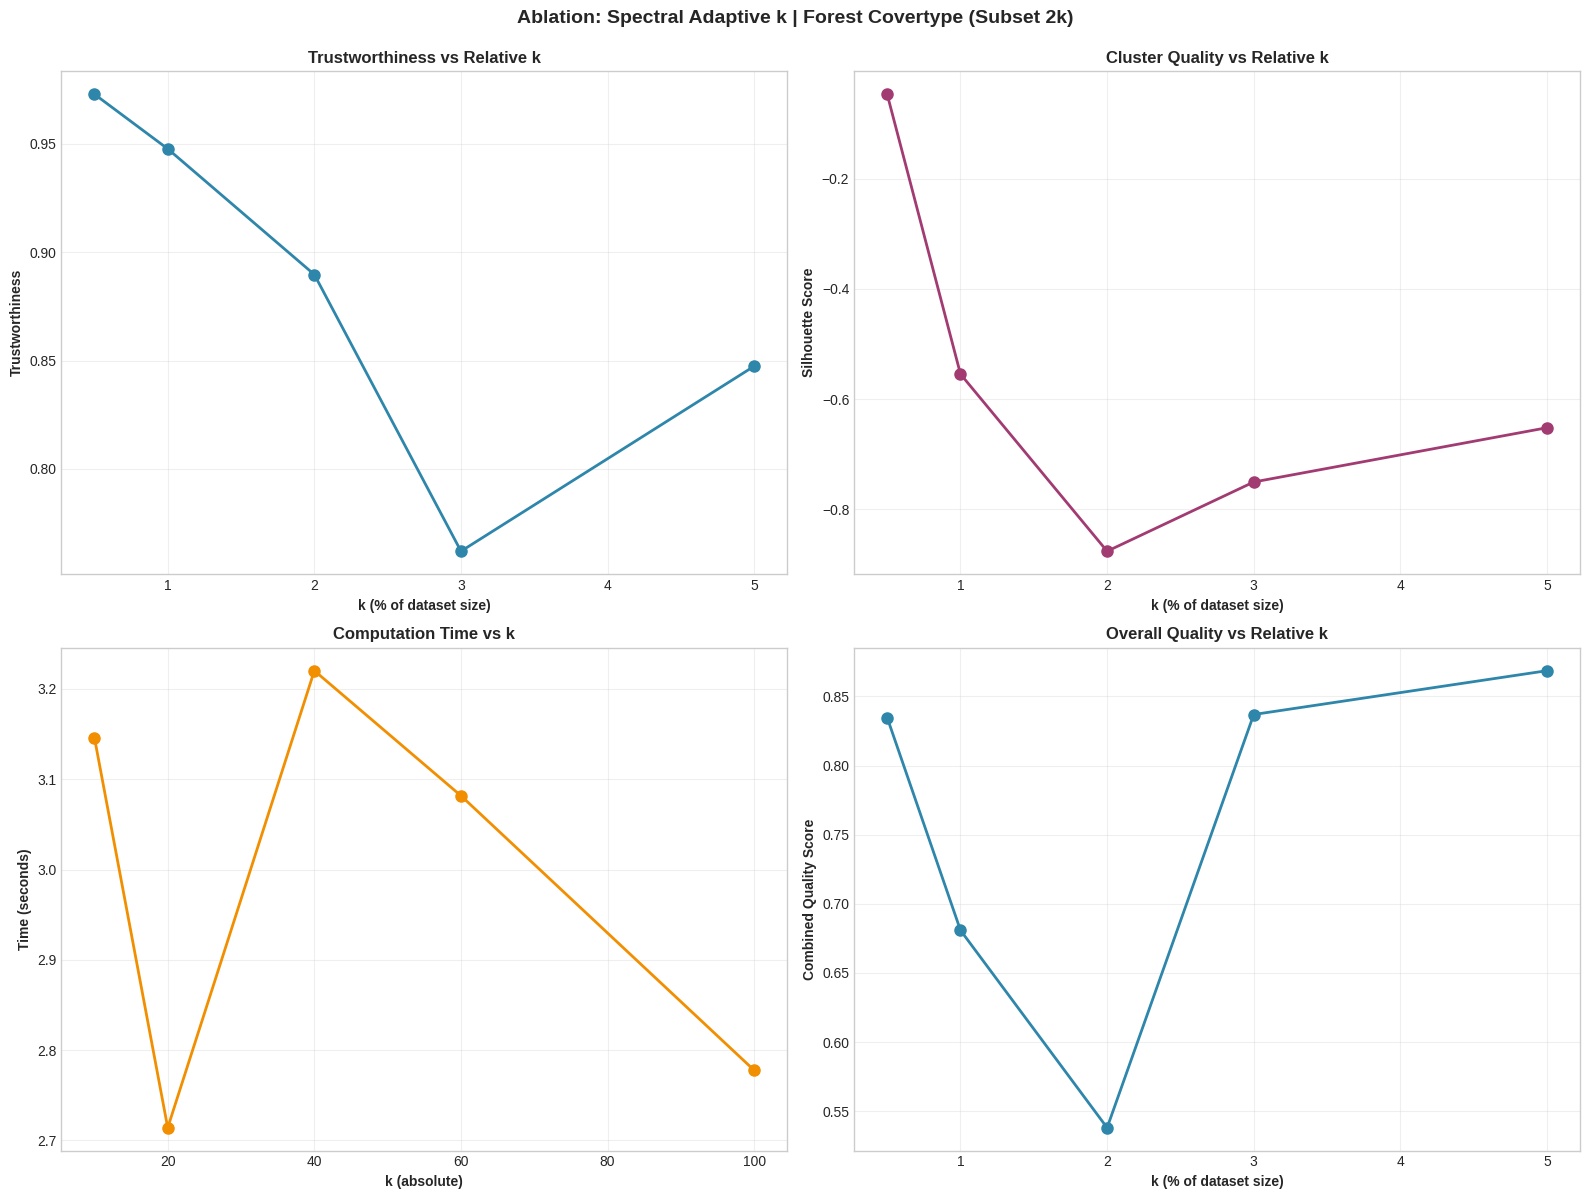


Results Table:
 trustworthiness  continuity   stress  distance_correlation  spearman_correlation  silhouette     time   k  k_percentage
        0.972874    0.696596 0.999097              0.240476              0.499806   -0.047092 3.146123  10           0.5
        0.947666    0.414105 0.999438              0.125952              0.384767   -0.554575 2.714094  20           1.0
        0.889651    0.186494 0.999823              0.069647              0.111586   -0.875820 3.220168  40           2.0
        0.762011    0.911842 0.999774             -0.043525             -0.016660   -0.750286 3.081648  60           3.0
        0.847407    0.889835 0.999805             -0.050752              0.059658   -0.651858 2.777610 100           5.0

Optimal k: 100.0 (5.0% of dataset)

>>> 2.3. Ablation: Spectral n_neighbors (Forest Covertype)

ABLATION 2: Spectral Embedding n_neighbors (ENHANCED)
Dataset: Forest Covertype (Subset 2k)

Testing k=5...
Testing k=10...
Testing k=15...
Testing k=20...
Testi

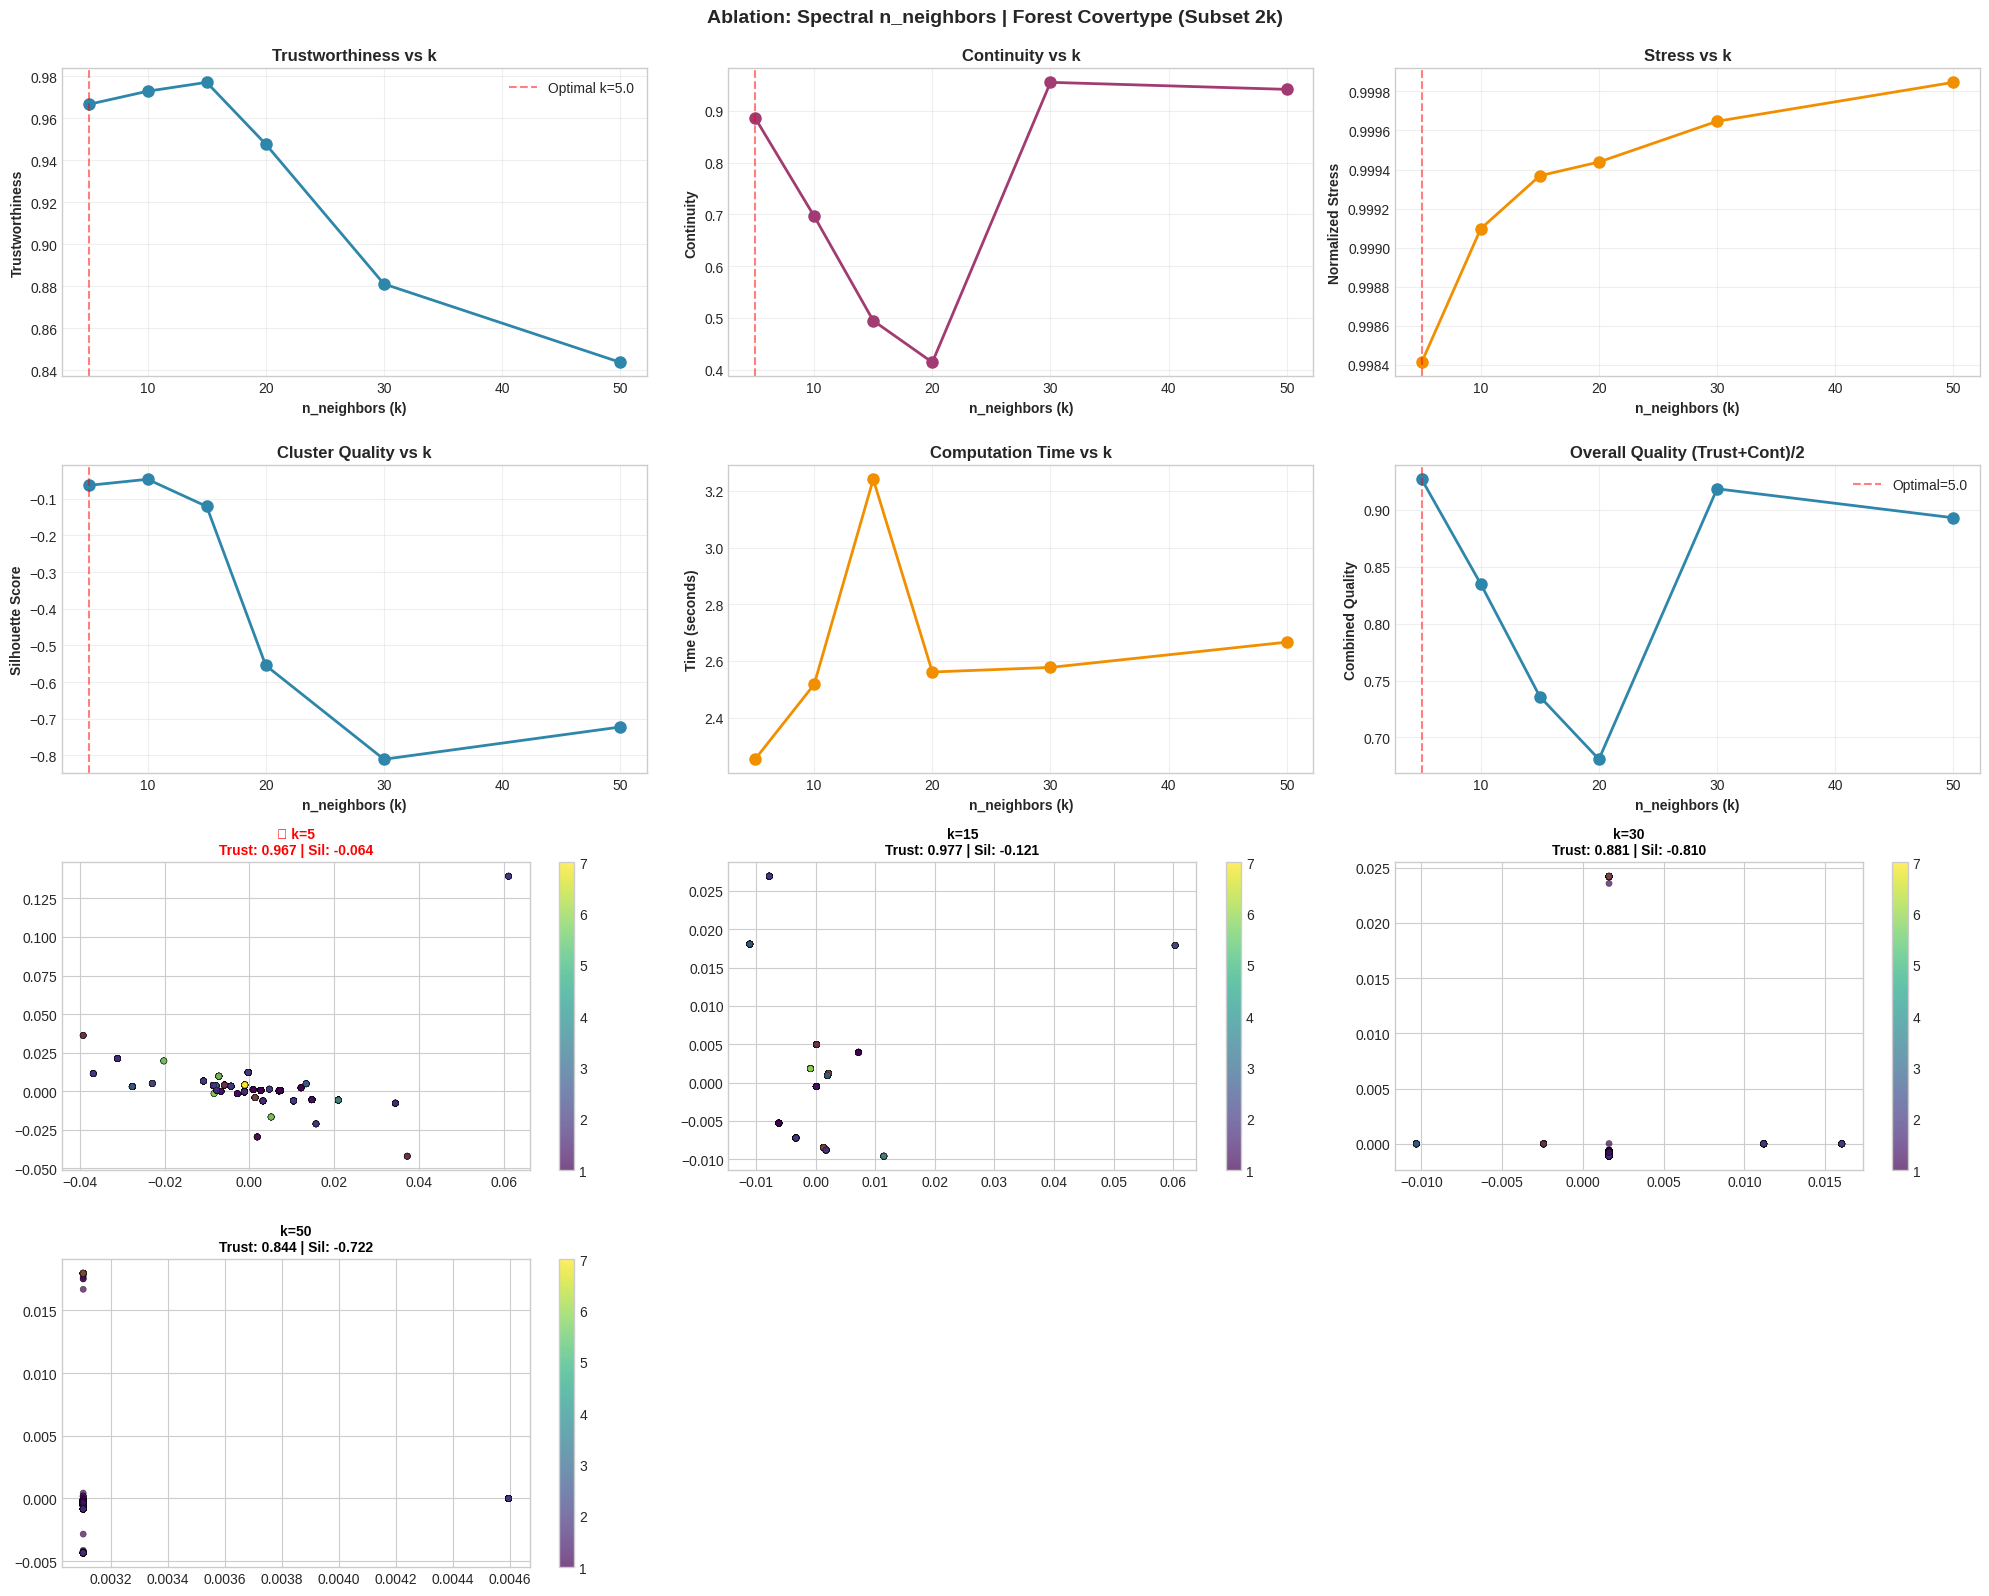


Results Table:
 trustworthiness  continuity   stress  distance_correlation  spearman_correlation  silhouette     time  k
        0.966587    0.886650 0.998412              0.436376              0.483078   -0.063759 2.253238  5
        0.972874    0.696596 0.999097              0.240476              0.499806   -0.047092 2.517447 10
        0.977105    0.494611 0.999368              0.230130              0.474805   -0.121140 3.241137 15
        0.947666    0.414105 0.999438              0.125952              0.384767   -0.554575 2.561137 20
        0.881120    0.955400 0.999647              0.071128              0.217703   -0.810381 2.577326 30
        0.843807    0.941803 0.999847              0.032753              0.067413   -0.722436 2.666472 50

>>> 2.4. Ablation: Spectral Affinity Functions (HAR Smartphone)

ABLATION 3: Spectral Affinity Functions (ENHANCED)
Dataset: HAR Smartphone (Subset 3k)

Running Nearest Neighbors...
Running RBF Kernel...

Metric                         Neare

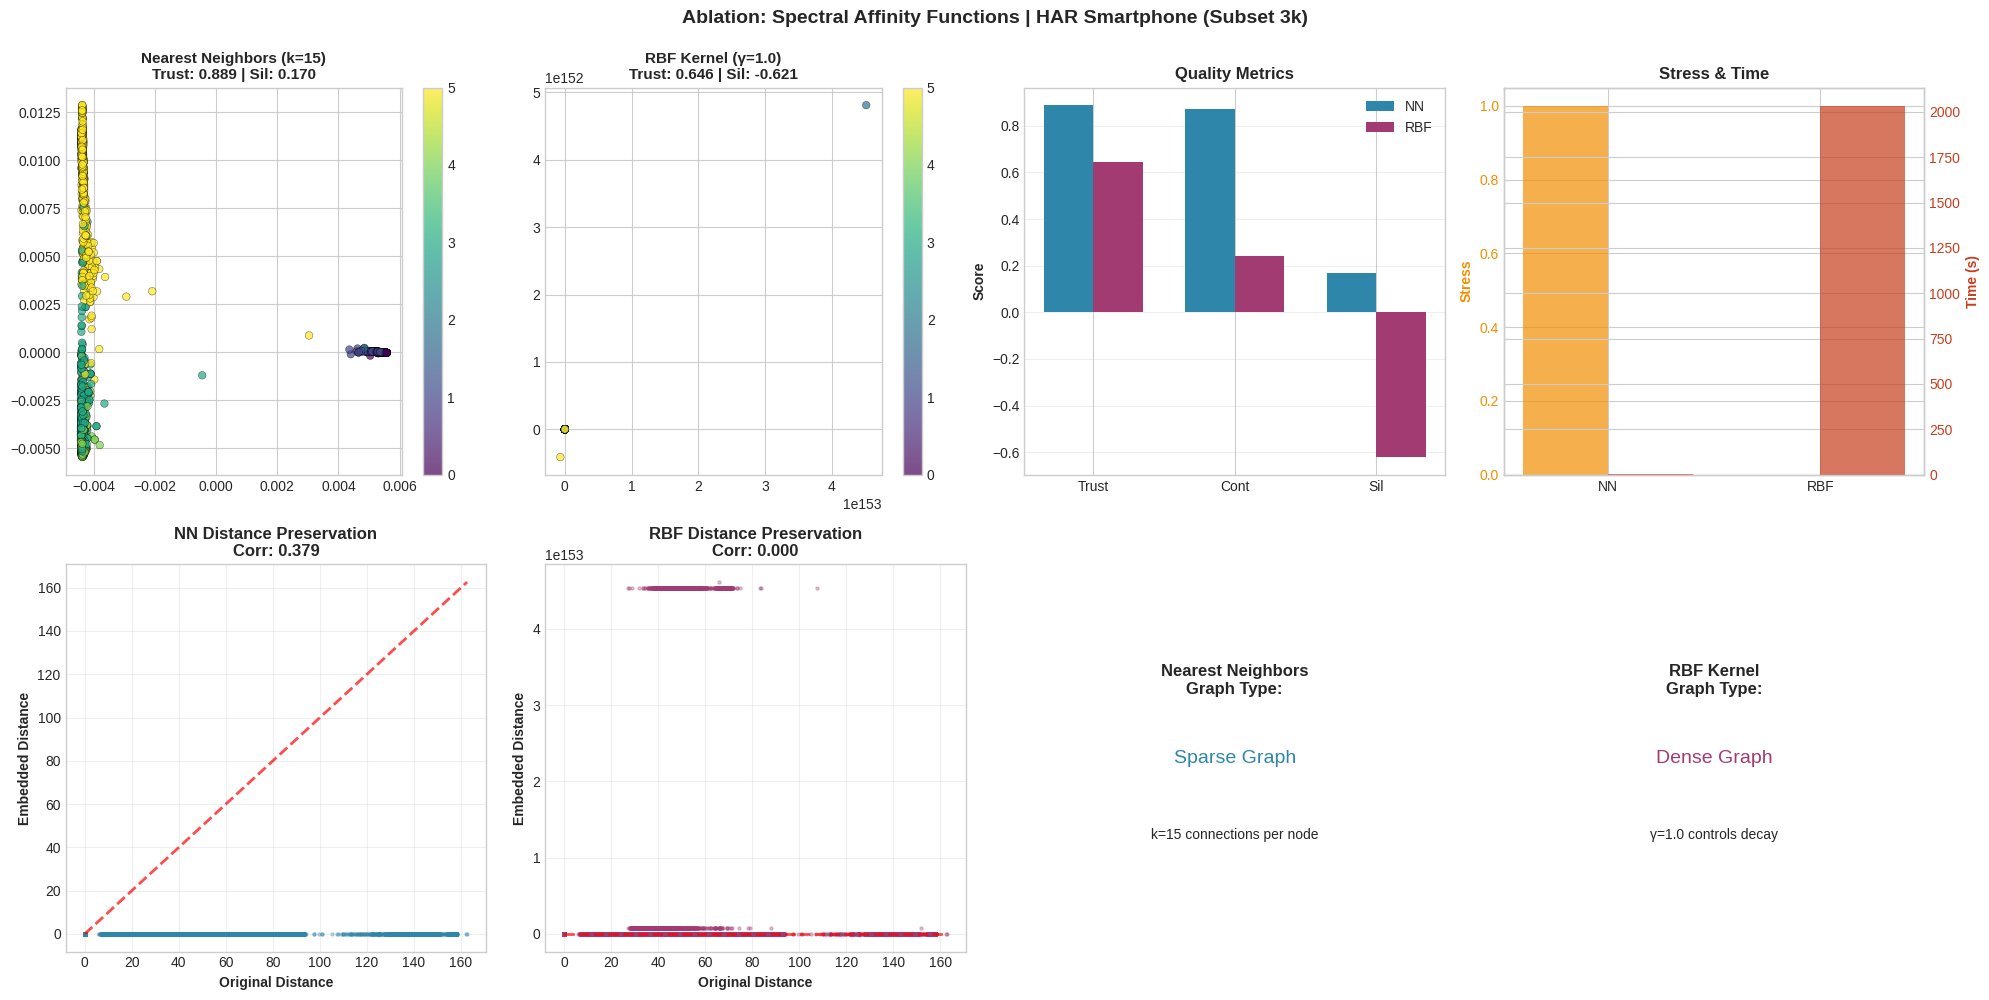


>>> 2.5. Ablation: Spectral Eigen Solver Methods (Fashion MNIST)

ABLATION 7: Spectral Eigen Solver Methods (NEW)
Dataset: Fashion MNIST (Subset 2k)

Testing eigen_solver=arpack...
Testing eigen_solver=lobpcg...


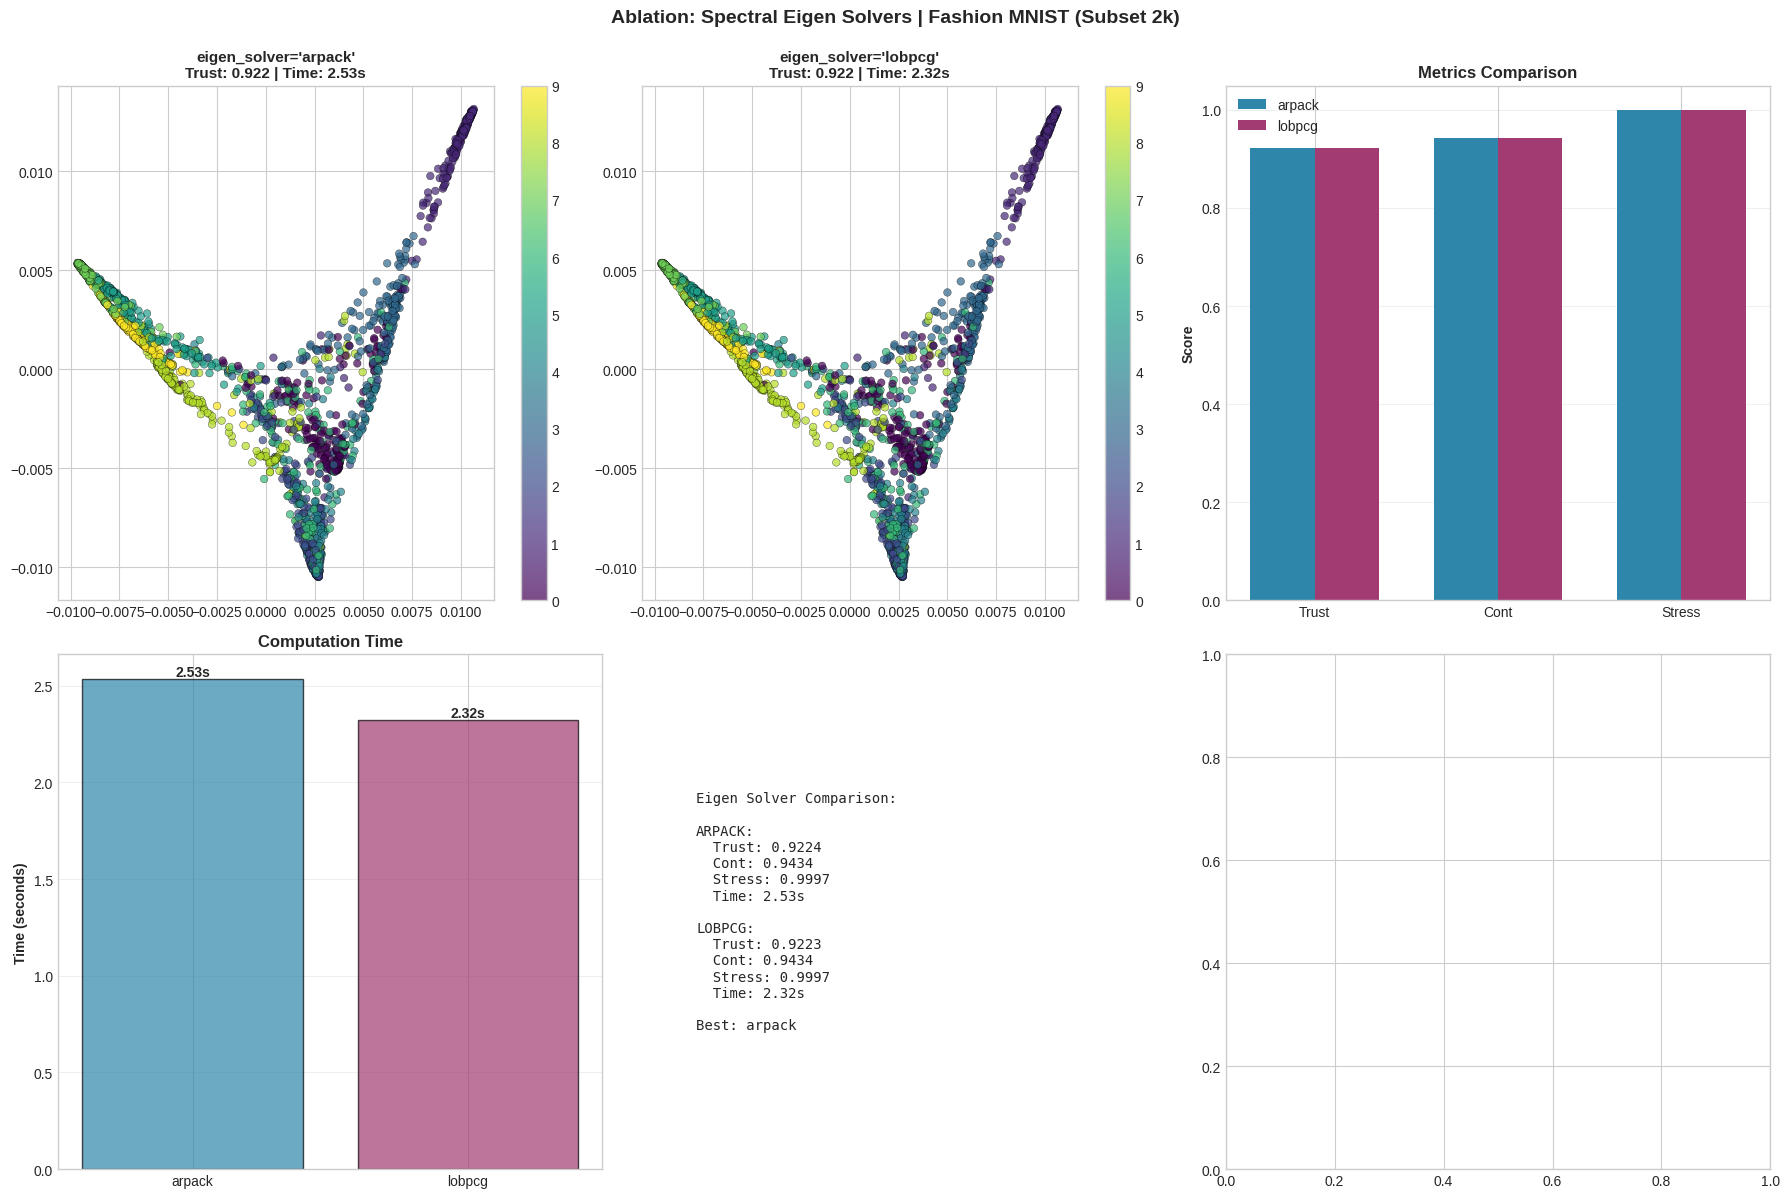


Results Table:
 trustworthiness  continuity  stress  distance_correlation  spearman_correlation  silhouette     time solver
        0.922351    0.943394 0.99974              0.273271              0.356814    0.099479 2.534381 arpack
        0.922348    0.943400 0.99974              0.273290              0.356830    0.099496 2.320443 lobpcg

----------------------------------------
GROUP 3: ROBUSTNESS & SCALABILITY


>>> 3.1. Ablation: Scalability Analysis (Fashion MNIST)

ABLATION STUDY 5: Scalability Analysis
Dataset: Fashion MNIST

Testing n_samples=500...
Testing n_samples=1000...
Testing n_samples=2000...
Testing n_samples=3000...
Testing n_samples=5000...


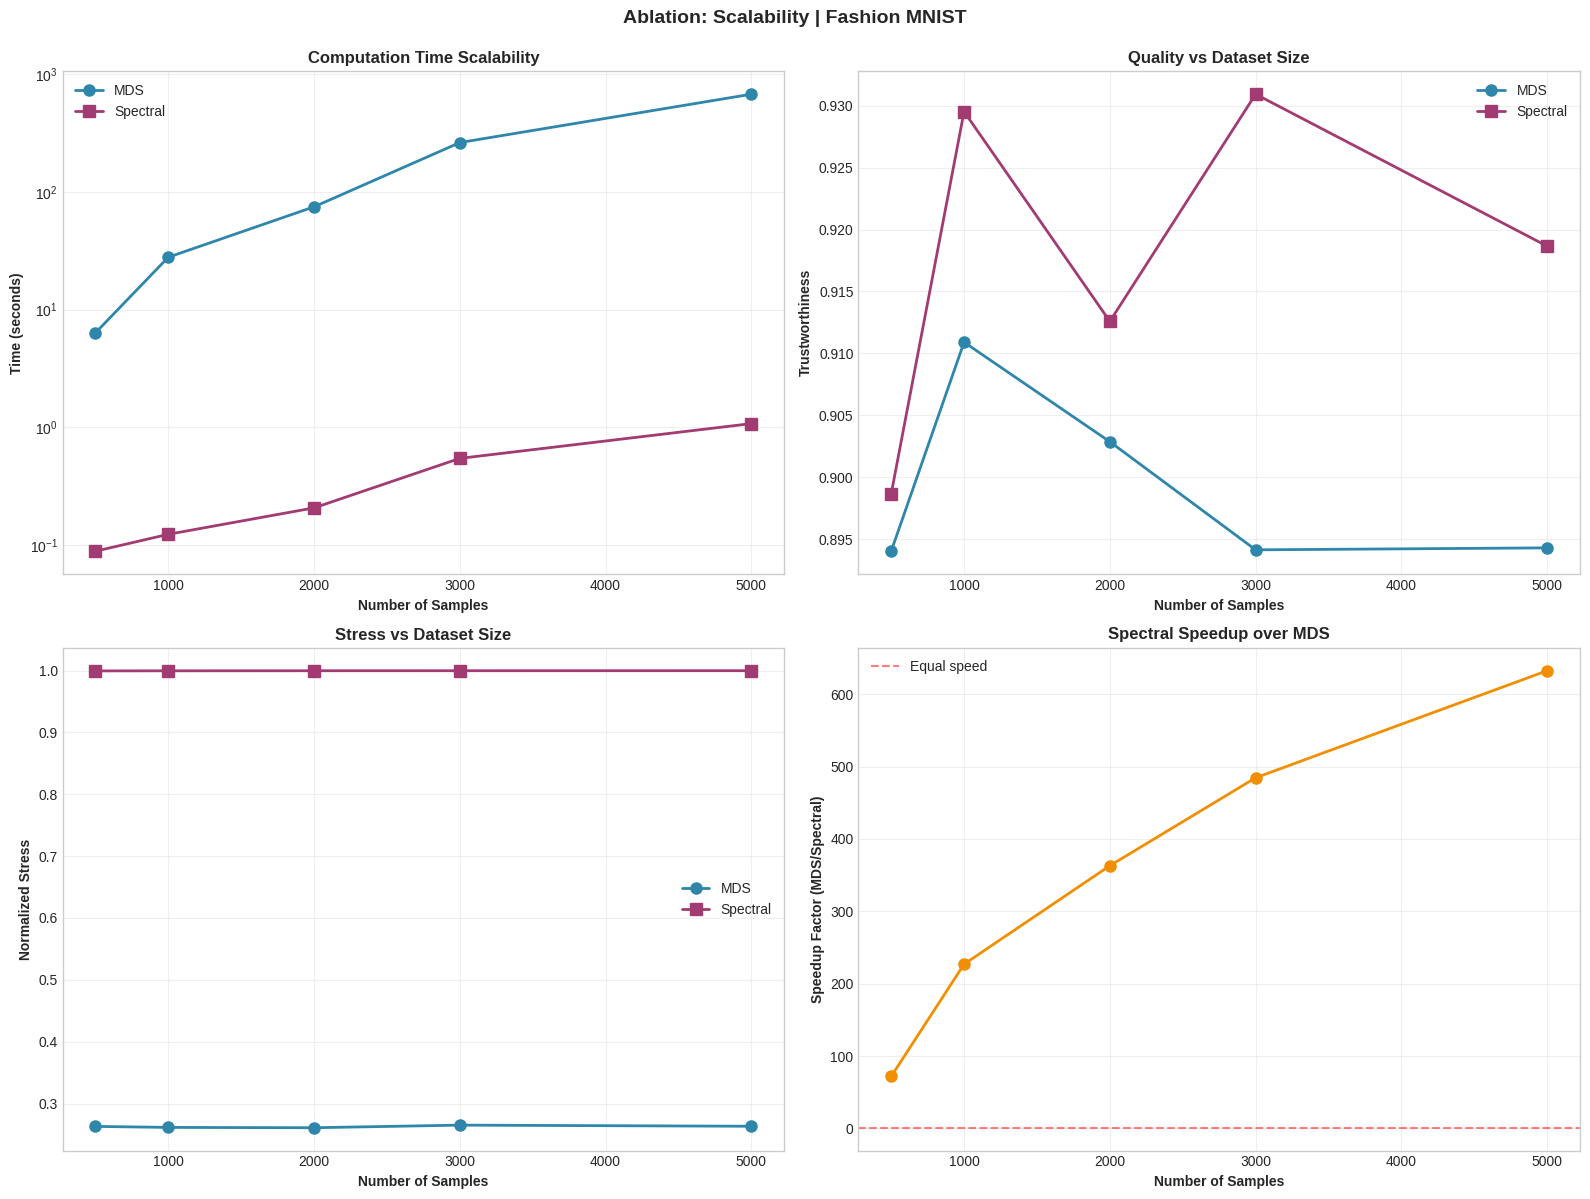


Results Table:
 n_samples   mds_time  mds_trust  mds_stress  spectral_time  spectral_trust  spectral_stress
       500   6.345416   0.894012    0.263005       0.088295        0.898636         0.999481
      1000  27.911967   0.910901    0.261385       0.122984        0.929533         0.999624
      2000  74.927211   0.902858    0.260864       0.206372        0.912584         0.999745
      3000 263.518702   0.894125    0.265068       0.543857        0.930939         0.999792
      5000 679.651781   0.894284    0.263258       1.074561        0.918657         0.999840

>>> 3.2. Ablation: Noise Robustness (Fashion MNIST)

ABLATION 5: Robustness to Noise/Outliers (NEW)
Dataset: Fashion MNIST (Subset 1k)

Testing noise level: 0.0
Testing noise level: 0.05
Testing noise level: 0.1
Testing noise level: 0.2
Testing noise level: 0.5


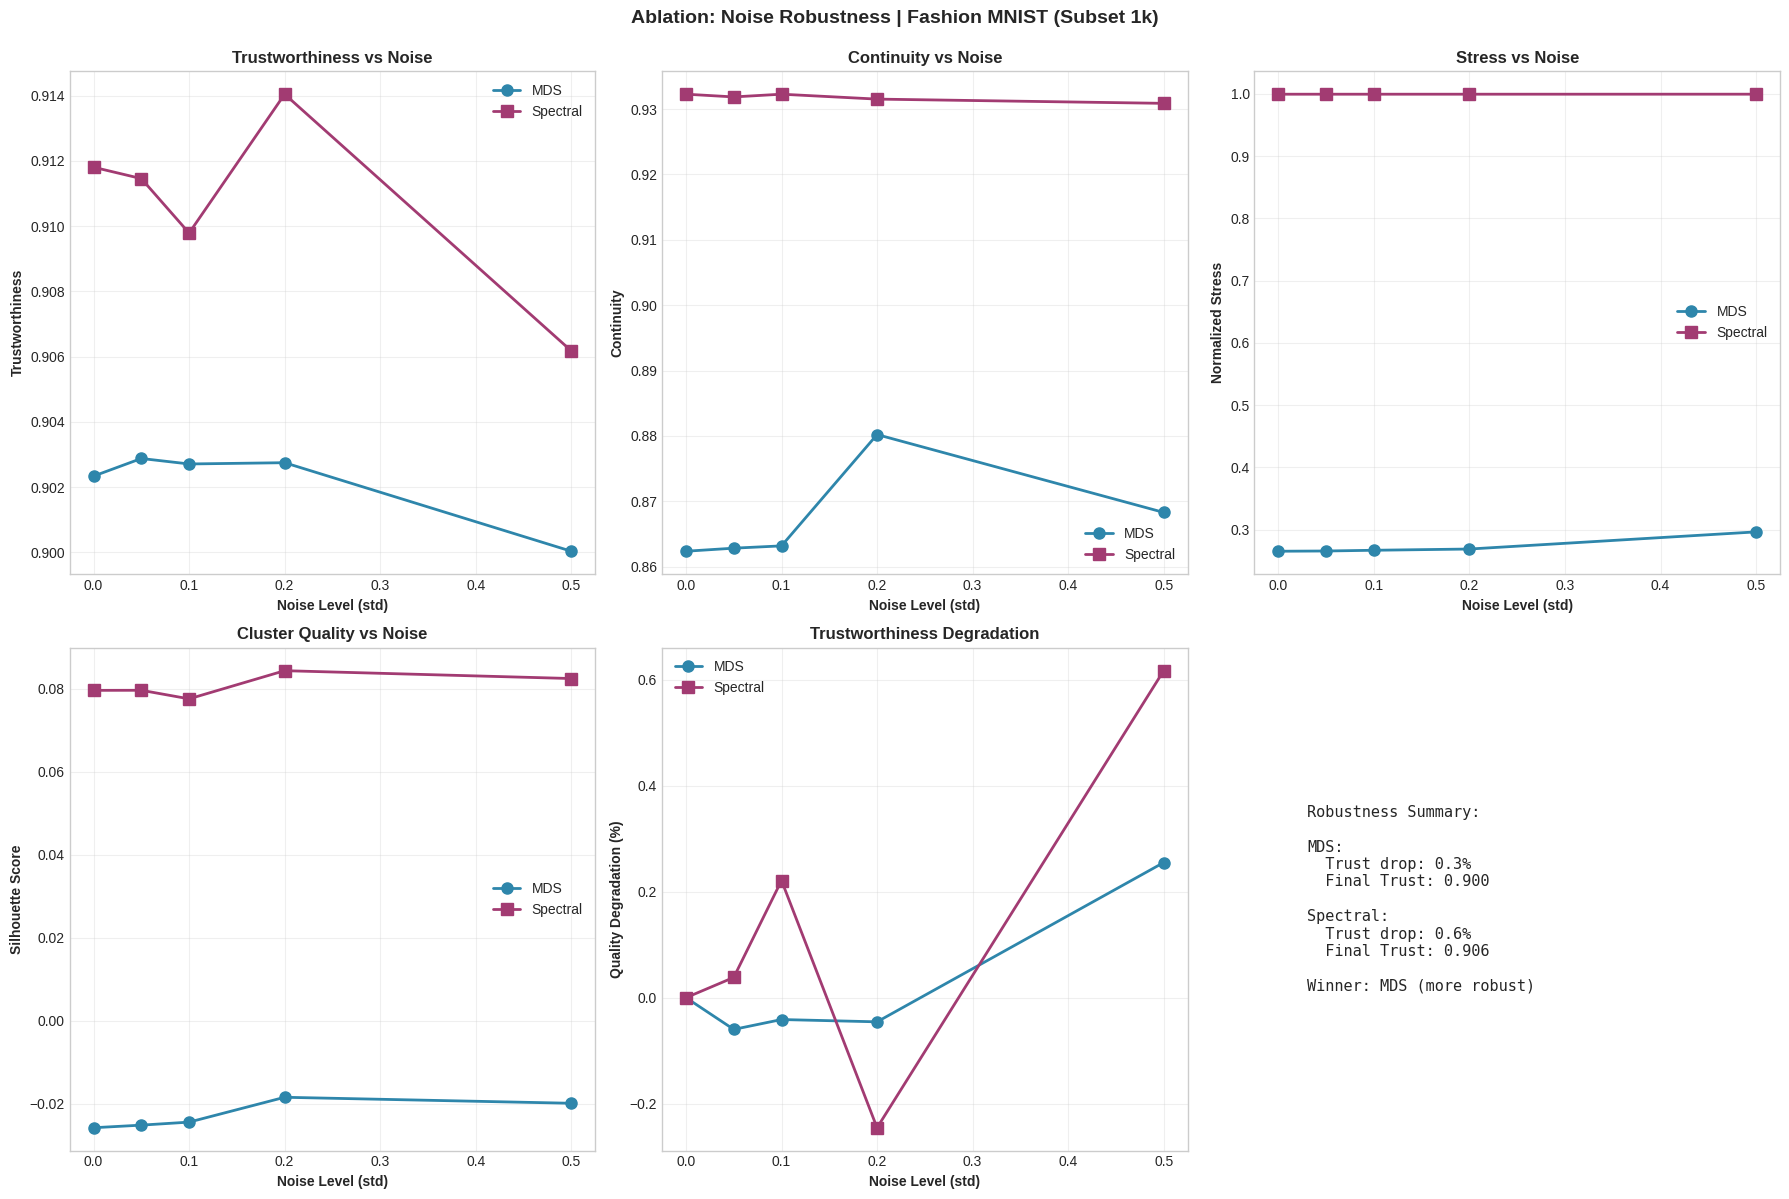


MDS Results:
 trustworthiness  continuity   stress  distance_correlation  spearman_correlation  silhouette      time  noise_level
        0.902339    0.862369 0.265499              0.871200              0.876970   -0.025808 34.904391         0.00
        0.902879    0.862836 0.265873              0.870867              0.876786   -0.025182 27.919175         0.05
        0.902711    0.863188 0.267056              0.869878              0.876144   -0.024455 44.917541         0.10
        0.902750    0.880210 0.269039              0.871034              0.878267   -0.018466 25.207808         0.20
        0.900036    0.868305 0.296574              0.839868              0.857300   -0.019912 16.619473         0.50

Spectral Results:
 trustworthiness  continuity   stress  distance_correlation  spearman_correlation  silhouette     time  noise_level
        0.911808    0.932268 0.999626              0.314063              0.392286    0.079629 0.770547         0.00
        0.911459    0.931850 0.99

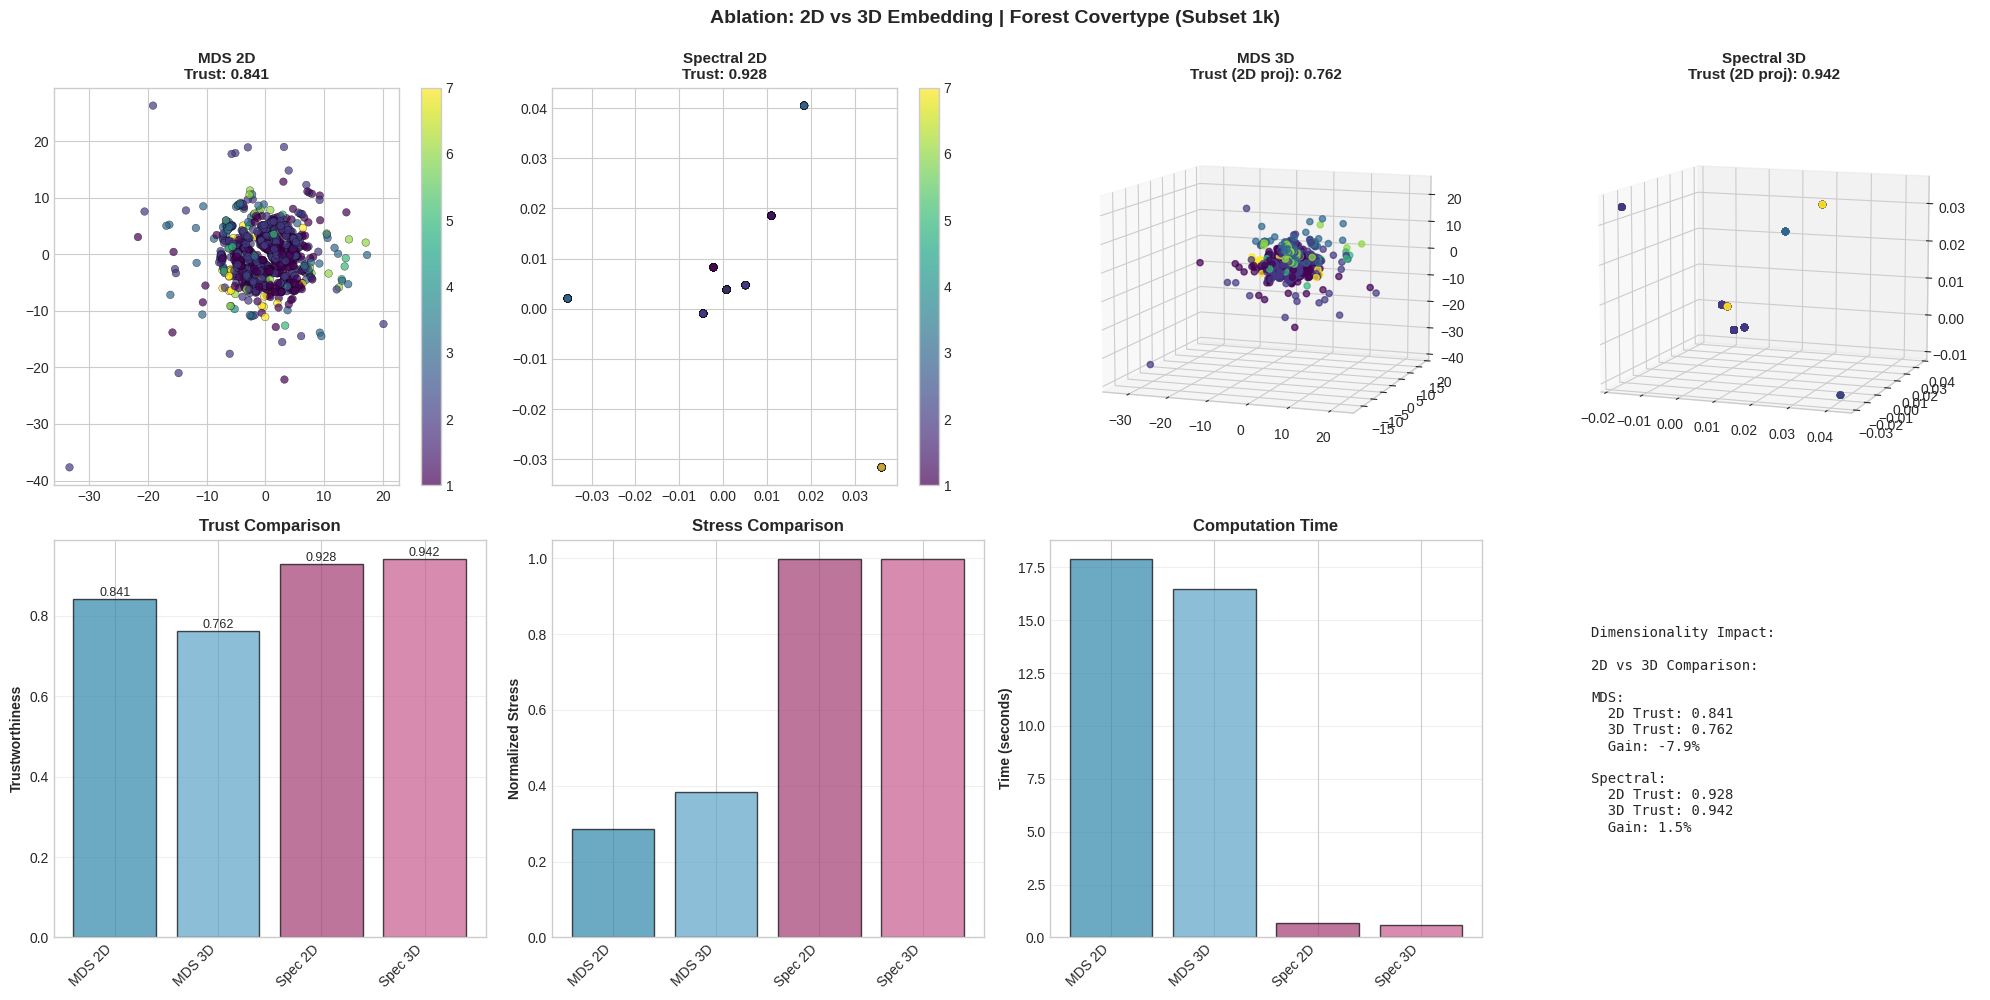


MDS Results:
 trustworthiness  continuity   stress  distance_correlation  spearman_correlation  silhouette      time  dimensions  stress_full
        0.840864    0.817100 0.285133              0.870866              0.807091   -0.057529 17.912458           2 3.940884e+06
        0.761697    0.873449 0.383189              0.764193              0.688556   -0.071155 16.473309           3 2.255938e+06

Spectral Results:
 trustworthiness  continuity   stress  distance_correlation  spearman_correlation  silhouette     time  dimensions
        0.927575    0.400027 0.999228              0.153576              0.280898   -0.810402 0.667481           2
        0.942324    0.409479 0.999252              0.153218              0.276396   -0.807199 0.598049           3

ALL EXPERIMENTS COMPLETED SUCCESSFULLY!


In [73]:
# 1. Load Datasets
# We load them once to reuse across experiments
print(">>> Loading Datasets...")
X_fashion, y_fashion, name_fashion = load_fashion_mnist()
X_olivetti, y_olivetti, name_olivetti = load_olivetti_faces()
X_covertype, y_covertype, name_covertype = load_covertype()
X_har, y_har, name_har = load_har_smartphone()

# ==============================================================================
# GROUP 1: MDS SPECIFIC ABLATIONS
# ==============================================================================
print("\n" + "-"*40)
print("GROUP 1: MDS PARAMETERS ANALYSIS")
print("-"*-40)

# 1.1. MDS Initialization (n_init)
# Use Olivetti: Small dataset, sensitive to initialization
print(f"\n>>> 1.1. Ablation: MDS Initialization Methods ({name_olivetti})")
ablation_mds_init_methods(X_olivetti, y_olivetti, name_olivetti)

# 1.2. MDS Convergence (max_iter)
# Use Olivetti: Fast enough to run multiple iterations for comparison
print(f"\n>>> 1.2. Ablation: MDS Convergence (max_iter) ({name_olivetti})")
ablation_mds_max_iter(X_olivetti, y_olivetti, name_olivetti)

# 1.3. Metric vs Non-Metric MDS
# Use Olivetti: Distinct clusters allow seeing if rank-order (Non-metric) helps
print(f"\n>>> 1.3. Ablation: Metric vs Non-Metric MDS ({name_olivetti})")
ablation_mds_metric(X_olivetti, y_olivetti, name_olivetti)

# 1.4. MDS Dissimilarity Metrics (Euclidean/Manhattan/Cosine) -- [PREVIOUSLY UNUSED]
# Use Olivetti: High-dim pixel data behaves differently with Cosine vs Euclidean
print(f"\n>>> 1.4. Ablation: MDS Dissimilarity Metrics ({name_olivetti})")
ablation_mds_dissimilarity(X_olivetti, y_olivetti, name_olivetti)

# ==============================================================================
# GROUP 2: SPECTRAL EMBEDDING SPECIFIC ABLATIONS
# ==============================================================================
print("\n" + "-"*40)
print("GROUP 2: SPECTRAL EMBEDDING ANALYSIS")
print("-"*-40)

# 2.1. Spectral RBF Gamma
# Use Fashion MNIST (subset): RBF is sensitive to scale on pixel data
print(f"\n>>> 2.1. Ablation: Spectral RBF Gamma Parameter ({name_fashion})")
# Slice to 2000 samples for speed
X_fashion_sub = X_fashion[:2000]
y_fashion_sub = y_fashion[:2000]
ablation_spectral_gamma(X_fashion_sub, y_fashion_sub, name_fashion + " (Subset 2k)")

# 2.2. Spectral Adaptive k (Density)
# Use Covertype (subset): Variable density data is perfect for this test
print(f"\n>>> 2.2. Ablation: Spectral Adaptive k (Data Density) ({name_covertype})")
X_cover_sub = X_covertype[:2000]
y_cover_sub = y_covertype[:2000]
ablation_spectral_adaptive_k(X_cover_sub, y_cover_sub, name_covertype + " (Subset 2k)")

# 2.3. Spectral n_neighbors
# Use Covertype (subset): Finding the right graph connectivity is key here
print(f"\n>>> 2.3. Ablation: Spectral n_neighbors ({name_covertype})")
ablation_spectral_neighbors(X_cover_sub, y_cover_sub, name_covertype + " (Subset 2k)")

# 2.4. Spectral Affinity Functions (NN vs RBF)
# Use HAR: Sensor data often works well with RBF (smooth changes)
if X_har is not None:
    print(f"\n>>> 2.4. Ablation: Spectral Affinity Functions ({name_har})")
    # HAR is usually around 10k samples, let's slice if needed or use full if machine is strong
    # Slicing to 3000 for safety
    ablation_spectral_affinity(X_har[:3000], y_har[:3000], name_har + " (Subset 3k)")

# 2.5. Spectral Eigen Solver Methods -- [PREVIOUSLY UNUSED]
# Use Fashion MNIST (subset): Test calculation stability and speed
print(f"\n>>> 2.5. Ablation: Spectral Eigen Solver Methods ({name_fashion})")
ablation_spectral_eigen_solver(X_fashion_sub, y_fashion_sub, name_fashion + " (Subset 2k)")

# ==============================================================================
# GROUP 3: COMPARATIVE & ROBUSTNESS ABLATIONS
# ==============================================================================
print("\n" + "-"*40)
print("GROUP 3: ROBUSTNESS & SCALABILITY")
print("-"*-40)

# 3.1. Scalability Analysis
# Use Fashion MNIST: We can easily step from 500 -> 10000 samples
print(f"\n>>> 3.1. Ablation: Scalability Analysis ({name_fashion})")
# We pass the full set, the function handles sampling internally
ablation_scalability(X_fashion[:10000], y_fashion[:10000], name_fashion)

# 3.2. Robustness to Noise/Outliers -- [PREVIOUSLY UNUSED]
# Use Fashion MNIST (subset): Visualizing noise impact on images is intuitive
print(f"\n>>> 3.2. Ablation: Noise Robustness ({name_fashion})")
# Use a small clean subset (1000 samples) so MDS runs fast repeatedly
ablation_noise_robustness(X_fashion[:1000], y_fashion[:1000], name_fashion + " (Subset 1k)")

# 3.3. Embedding Dimensions (2D vs 3D) -- [PREVIOUSLY UNUSED]
# Use Covertype (subset): Complex biological data often needs 3D to unfold
print(f"\n>>> 3.3. Ablation: Embedding Dimensions 2D vs 3D ({name_covertype})")
# Use subset of 1000 for MDS performance
ablation_embedding_dimensions(X_covertype[:1000], y_covertype[:1000], name_covertype + " (Subset 1k)")

print("\n" + "="*80)
print("ALL EXPERIMENTS COMPLETED SUCCESSFULLY!")
print("="*80)

## 10. Kết luận

### 10.1. Về hình học (Geometry):
- Spectral Embedding vượt trội với các dữ liệu dạng cuộn (Swiss Roll, S-Curve) nhờ khả năng "duỗi" cấu trúc dựa trên lân cận. Nó có chỉ số Trustworthiness rất cao.
- MDS gặp khó khăn với dữ liệu phi tuyến tính phức tạp, thường làm chồng chéo các điểm dữ liệu (Stress thấp nhưng Trustworthiness thấp).

### 10.2. Về ứng dụng:
- Dùng Spectral Embedding cho các bài toán Manifold Learning phức tạp (Image manifold, chuyển động robot).
- Dùng MDS khi muốn trực quan hóa sự khác biệt về khoảng cách giữa các đối tượng rời rạc (ví dụ: bản đồ khoảng cách các thành phố, sự khác biệt gene).